<a href="https://colab.research.google.com/github/valeman/Multi-class-probabilistic-classification/blob/main/multi_class_probabilistic_classification_satimage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi class probabilistic classification - satimage

In [3]:
#install OpenML
!pip install openml
!pip install dtype_diet

#install XGBoost
!pip install xgboost
!pip install --upgrade xgboost

#install CatBoost
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

!git clone https://github.com/wxs/keras-mnist-tutorial.git

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
fatal: destination path 'keras-mnist-tutorial' already exists and is not an empty directory.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import gmean

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, \
roc_auc_score, precision_recall_curve, log_loss, brier_score_loss

from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import auc, multilabel_confusion_matrix,roc_curve, roc_auc_score

from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.naive_bayes import GaussianNB
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.preprocessing import label_binarize

import plotly.express as px

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import openml

from dtype_diet import report_on_dataframe, optimize_dtypes

from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression

from sklearn.neural_network import MLPClassifier

from VennABERS import ScoresToMultiProbs


# Load dataset

In [5]:
# List datasets https://docs.openml.org/Python-API/
datasets_df = openml.datasets.list_datasets(output_format="dataframe")
print(datasets_df.head(n=10))

datasets_df.set_index('did', inplace = True)

    did             name  version uploader  status format  MajorityClassSize  \
2     2           anneal        1        1  active   ARFF              684.0   
3     3         kr-vs-kp        1        1  active   ARFF             1669.0   
4     4            labor        1        1  active   ARFF               37.0   
5     5       arrhythmia        1        1  active   ARFF              245.0   
6     6           letter        1        1  active   ARFF              813.0   
7     7        audiology        1        1  active   ARFF               57.0   
8     8  liver-disorders        1        1  active   ARFF                NaN   
9     9            autos        1        1  active   ARFF               67.0   
10   10            lymph        1        1  active   ARFF               81.0   
11   11    balance-scale        1        1  active   ARFF              288.0   

    MaxNominalAttDistinctValues  MinorityClassSize  NumberOfClasses  \
2                           7.0                8

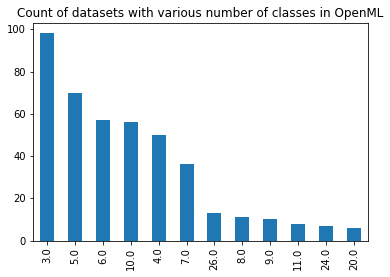

In [6]:
#plot number of datasets for each class size where class size is more than 2
datasets_df[datasets_df['NumberOfClasses'] > 2]['NumberOfClasses'].value_counts()[:20].plot(kind = 'bar')
plt.title('Count of datasets with various number of classes in OpenML')
plt.show()

In [7]:
# output information about selected dataset
datasets_df.loc[182]

name                                  satimage
version                                      1
uploader                                     1
status                                  active
format                                    ARFF
MajorityClassSize                       1531.0
MaxNominalAttDistinctValues                6.0
MinorityClassSize                        625.0
NumberOfClasses                            6.0
NumberOfFeatures                          37.0
NumberOfInstances                       6430.0
NumberOfInstancesWithMissingValues         0.0
NumberOfMissingValues                      0.0
NumberOfNumericFeatures                   36.0
NumberOfSymbolicFeatures                   1.0
Name: 182, dtype: object

In [8]:
# satimage dataset https://www.openml.org/d/182
dataset = openml.datasets.get_dataset(182)

# Print a summary
print(
    f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)
print(f"URL: {dataset.url}")
print(dataset.description[:500])

This is dataset 'satimage', the target feature is 'class'
URL: https://old.openml.org/data/v1/download/3619/satimage.arff
**Author**: Ashwin Srinivasan, Department of Statistics and Data Modeling, University of Strathclyde  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/Statlog+(Landsat+Satellite)) - 1993  
**Please cite**: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html)  

The database consists of the multi-spectral values of pixels in 3x3 neighbourhoods in a satellite image, and the classification associated with the central pixel in each neighbourhood. The aim is to predict this classifica


In [9]:
# openml API
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)
df = pd.DataFrame(X, columns=attribute_names)
df["class"] = y

In [10]:
df.head()

Aattr     Battr     Cattr     Dattr     Eattr     Fattr    A1attr  \
0  0.117596  1.241362  1.184036  0.815302 -0.158561  1.256483  1.193546   
1 -1.205362 -1.249654 -0.077532  0.444886 -0.895959 -0.447579 -0.786760   
2  0.779075  0.148811  0.042617 -0.243030  0.800057  0.164136  0.053370   
3  1.146564  0.585831  0.342991  0.021553  0.947536  0.601074  0.353416   
4 -0.764376 -1.162250 -0.137607  0.180303 -0.969698 -1.146681 -0.126658   

     B2attr    C3attr    D4attr  ...   D22attr   E23attr   F24attr   A25attr  \
0  0.818486 -0.141965  0.879481  ...  0.807707 -0.069968  1.219160  1.250463   
1 -0.554203 -0.364672  0.092157  ... -0.192752 -0.736996 -0.969292 -0.844805   
2 -0.448612  0.154978 -0.345245  ... -0.877277  0.671174 -0.006373 -0.425752   
3  0.026550  1.788164  1.010702  ...  0.281150  1.412317  1.044084  0.532085   
4  0.184937 -0.735851 -1.132569  ... -0.192752 -0.885225 -1.231906 -0.784941   

    B26attr   C27attr   D28attr   E29attr   F30attr  class  
0  0.597678 -0.054291  1.233342  1.262255  0.603258      0  
1 -0.400030 -0.725852 -0.344432 -0.594534 -0.183967      4  
2 -0.662584  0.691889  0.356801 -0.175259 -0.236449      5  
3  0.282612  1.438068  1.058033  0.842981  0.130923      2  
4 -0.347519 -0.875088 -1.220973 -0.774223 -0.551339      4  

[5 rows x 37 columns]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6430 entries, 0 to 6429
Data columns (total 37 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Aattr    6430 non-null   float32
 1   Battr    6430 non-null   float32
 2   Cattr    6430 non-null   float32
 3   Dattr    6430 non-null   float32
 4   Eattr    6430 non-null   float32
 5   Fattr    6430 non-null   float32
 6   A1attr   6430 non-null   float32
 7   B2attr   6430 non-null   float32
 8   C3attr   6430 non-null   float32
 9   D4attr   6430 non-null   float32
 10  E5attr   6430 non-null   float32
 11  F6attr   6430 non-null   float32
 12  A7attr   6430 non-null   float32
 13  B8attr   6430 non-null   float32
 14  C9attr   6430 non-null   float32
 15  D10attr  6430 non-null   float32
 16  E11attr  6430 non-null   float32
 17  F12attr  6430 non-null   float32
 18  A13attr  6430 non-null   float32
 19  B14attr  6430 non-null   float32
 20  C15attr  6430 non-null   float32
 21  D16attr  6430 

In [12]:
df.describe()

Aattr        Battr        Cattr        Dattr        Eattr  \
count  6430.000000  6430.000000  6430.000000  6430.000000  6430.000000   
mean     -0.000846    -0.000748    -0.000603    -0.000272    -0.000863   
std       0.999648     0.999943     0.999966     1.000202     0.999697   
min      -2.234329    -2.473310    -2.780894    -2.624275    -2.223275   
25%      -0.690878    -0.550421    -0.858503    -0.719279    -0.674739   
50%      -0.102897     0.148811     0.102692    -0.084280    -0.084821   
75%       0.779075     0.848043     0.823588     0.497802     0.800057   
max       2.543020     2.333912     2.445605     3.778629     2.569812   

             Fattr       A1attr       B2attr       C3attr       D4attr  ...  \
count  6430.000000  6430.000000  6430.000000  6430.000000  6430.000000  ...   
mean     -0.000787    -0.000611    -0.000333    -0.000767    -0.000779  ...   
std       0.999955     0.999969     1.000220     0.999806     0.999907  ...   
min      -2.457498    -2.947095    -2.824420    -2.146330    -2.444776  ...   
25%      -0.534967    -0.846770    -0.712591    -0.661615    -0.520206  ...   
50%       0.076748     0.113379    -0.079042    -0.141965     0.092157  ...   
75%       0.863238     0.833490     0.501711     0.748864     0.835741  ...   
max       2.348830     2.753787     3.933434     2.604758     2.060467  ...   

           D22attr      E23attr      F24attr      A25attr      B26attr  \
count  6430.000000  6430.000000  6430.000000  6430.000000  6430.000000   
mean     -0.000178    -0.000626    -0.000717    -0.000526    -0.000212   
std       1.000274     0.999900     1.000023     1.000017     1.000276   
min      -2.825539    -2.219281    -2.457440    -2.940074    -2.815531   
25%      -0.719309    -0.662882    -0.531602    -0.844805    -0.715095   
50%      -0.087440    -0.069968     0.081165     0.053167    -0.084964   
75%       0.491773     0.745289     0.869008     0.831409     0.492656   
max       3.756429     2.598145     2.050772     2.747083     3.905865   

           C27attr      D28attr      E29attr      F30attr        class  
count  6430.000000  6430.000000  6430.000000  6430.000000  6430.000000  
mean     -0.000596    -0.000666    -0.000469    -0.000126     2.435148  
std       0.999877     1.000010     1.000005     1.000286     1.876348  
min      -2.218211    -2.448131    -2.930494    -2.808050     0.000000  
25%      -0.651234    -0.519740    -0.834119    -0.761265     1.000000  
50%      -0.128909     0.050011     0.064327    -0.079004     2.000000  
75%       0.766507     0.838898     0.842981     0.498294     4.000000  
max       2.631955     2.066056     2.759666     3.909603     5.000000  

[8 rows x 37 columns]

In [13]:
# print number of classes
n_classes = df['class'].nunique()
print('Number of classes: {}'.format(n_classes))

Number of classes: 6


In [14]:
# print number of classes
classes = np.sort(df['class'].unique())

In [15]:
type(classes)

numpy.ndarray

In [16]:
classes

array([0, 1, 2, 3, 4, 5])

In [17]:
# compress memory footprint using dtype_diet whilst retaining information 
proposed_df = report_on_dataframe(df, unit="MB")
print('Original df memory: {} MB'.format(round(df.memory_usage(deep=True).sum()/1024/1024, 2)))

df = optimize_dtypes(df, proposed_df)

print('Optimized df memory: {} MB'.format(round(df.memory_usage(deep=True).sum()/1024/1024, 2)))

Original df memory: 0.93 MB
Optimized df memory: 0.89 MB


In [18]:
#df.to_csv('satimage.csv')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6430 entries, 0 to 6429
Data columns (total 37 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Aattr    6430 non-null   float32
 1   Battr    6430 non-null   float32
 2   Cattr    6430 non-null   float32
 3   Dattr    6430 non-null   float32
 4   Eattr    6430 non-null   float32
 5   Fattr    6430 non-null   float32
 6   A1attr   6430 non-null   float32
 7   B2attr   6430 non-null   float32
 8   C3attr   6430 non-null   float32
 9   D4attr   6430 non-null   float32
 10  E5attr   6430 non-null   float32
 11  F6attr   6430 non-null   float32
 12  A7attr   6430 non-null   float32
 13  B8attr   6430 non-null   float32
 14  C9attr   6430 non-null   float32
 15  D10attr  6430 non-null   float32
 16  E11attr  6430 non-null   float32
 17  F12attr  6430 non-null   float32
 18  A13attr  6430 non-null   float32
 19  B14attr  6430 non-null   float32
 20  C15attr  6430 non-null   float32
 21  D16attr  6430 

In [20]:
# imbalanced class problem
df['class'].value_counts()

0    1531
5    1508
2    1356
4     707
1     703
3     625
Name: class, dtype: int64

# Experiments

In [21]:
algos = ['Naive Bayes', 'KNN', 'Support Vector Machine', 'logistic regression', 'neural network', 'Random Forest', \
         'LightGBM', 'XGBoost', 'CatBoost', 'Ada Boost']

number_baseline_algos = len(algos)
print('Number of baseline algorithms: {}'.format(number_baseline_algos))

calibration_algos = ['no calibration', 'sigmoid', 'isotonic', 'sigmoid cv', 'isotonic cv', 'ivap', 'cvap']
number_calibration_algos = len(calibration_algos)

Number of baseline algorithms: 10


In [22]:
# function initialize_array creates an 2d array of size m x n and initializes it with NaNs
def initialize_array(size = (number_baseline_algos, number_calibration_algos)):
  an_array = np.empty(size)
  an_array[:] = np.NaN
  return an_array

In [23]:
# setup dataframes to store results for the Brier and the Log loss
brier_loss_df = pd.DataFrame(data = initialize_array(), index = algos, columns = calibration_algos)
log_loss_df = brier_loss_df.copy()

In [24]:
brier_loss_df.head()

no calibration  sigmoid  isotonic  sigmoid cv  \
Naive Bayes                        NaN      NaN       NaN         NaN   
KNN                                NaN      NaN       NaN         NaN   
Support Vector Machine             NaN      NaN       NaN         NaN   
logistic regression                NaN      NaN       NaN         NaN   
neural network                     NaN      NaN       NaN         NaN   

                        isotonic cv  ivap  cvap  
Naive Bayes                     NaN   NaN   NaN  
KNN                             NaN   NaN   NaN  
Support Vector Machine          NaN   NaN   NaN  
logistic regression             NaN   NaN   NaN  
neural network                  NaN   NaN   NaN

In [25]:
log_loss_df.head()

no calibration  sigmoid  isotonic  sigmoid cv  \
Naive Bayes                        NaN      NaN       NaN         NaN   
KNN                                NaN      NaN       NaN         NaN   
Support Vector Machine             NaN      NaN       NaN         NaN   
logistic regression                NaN      NaN       NaN         NaN   
neural network                     NaN      NaN       NaN         NaN   

                        isotonic cv  ivap  cvap  
Naive Bayes                     NaN   NaN   NaN  
KNN                             NaN   NaN   NaN  
Support Vector Machine          NaN   NaN   NaN  
logistic regression             NaN   NaN   NaN  
neural network                  NaN   NaN   NaN

## Create proper training, validation and test set

In [26]:
n_folds = 5

In [27]:
df.head()

Aattr     Battr     Cattr     Dattr     Eattr     Fattr    A1attr  \
0  0.117596  1.241362  1.184036  0.815302 -0.158561  1.256483  1.193546   
1 -1.205362 -1.249654 -0.077532  0.444886 -0.895959 -0.447579 -0.786760   
2  0.779075  0.148811  0.042617 -0.243030  0.800057  0.164136  0.053370   
3  1.146564  0.585831  0.342991  0.021553  0.947536  0.601074  0.353416   
4 -0.764376 -1.162250 -0.137607  0.180303 -0.969698 -1.146681 -0.126658   

     B2attr    C3attr    D4attr  ...   D22attr   E23attr   F24attr   A25attr  \
0  0.818486 -0.141965  0.879481  ...  0.807707 -0.069968  1.219160  1.250463   
1 -0.554203 -0.364672  0.092157  ... -0.192752 -0.736996 -0.969292 -0.844805   
2 -0.448612  0.154978 -0.345245  ... -0.877277  0.671174 -0.006373 -0.425752   
3  0.026550  1.788164  1.010702  ...  0.281150  1.412317  1.044084  0.532085   
4  0.184937 -0.735851 -1.132569  ... -0.192752 -0.885225 -1.231906 -0.784941   

    B26attr   C27attr   D28attr   E29attr   F30attr  class  
0  0.597678 -0.054291  1.233342  1.262255  0.603258      0  
1 -0.400030 -0.725852 -0.344432 -0.594534 -0.183967      4  
2 -0.662584  0.691889  0.356801 -0.175259 -0.236449      5  
3  0.282612  1.438068  1.058033  0.842981  0.130923      2  
4 -0.347519 -0.875088 -1.220973 -0.774223 -0.551339      4  

[5 rows x 37 columns]

In [28]:
len_test_set = int(0.2 * len(df))
print('Test set size: {}'.format(len_test_set))

Test set size: 1286


In [29]:
len_train_cal_set = len(df) - len_test_set
print('Train and calibration set size: {}'.format(len_train_cal_set))

Train and calibration set size: 5144


In [30]:
df_train_cal, df_test = train_test_split(df, test_size = len_test_set, random_state = 42, shuffle = True)

In [31]:
print('Training and calibration set size: {}'.format(len(df_train_cal)))
print('Test set size: {}'.format(len(df_test)))

Training and calibration set size: 5144
Test set size: 1286


In [32]:
len_cal_set = len_test_set

In [33]:
df_proper_train, df_cal = train_test_split(df_train_cal, test_size = len_cal_set, random_state = 42, 
                                           shuffle = True)

In [34]:
print('Proper training set size: {}'.format(len(df_proper_train)))
print('Calibration set size: {}'.format(len(df_cal)))

Proper training set size: 3858
Calibration set size: 1286


In [35]:
df_proper_train.head()

Aattr     Battr     Cattr     Dattr     Eattr     Fattr    A1attr  \
3439 -1.425855 -1.511866 -1.939848 -1.671777 -1.412137 -1.321457 -1.506872   
5398 -1.646348 -2.167396  1.184036  2.296965 -1.633357 -2.151641  0.893500   
5819 -0.984869 -1.817780  0.883663  1.979466 -2.002056 -2.239028  1.853648   
3736 -0.102897 -0.550421 -1.459250 -1.407194 -0.379780 -0.360191 -1.446863   
3937  0.705578  1.197660  1.123962  0.709468 -0.158561  0.688462  0.833490   

        B2attr    C3attr    D4attr  ...   D22attr   E23attr   F24attr  \
3439 -1.293344 -1.403973 -1.307530  ... -1.245867 -0.959339 -1.144368   
5398  2.296766 -1.626680 -2.138594  ...  2.018789 -1.922824 -2.063518   
5819  3.352681 -1.997859 -2.138594  ... -0.350719 -0.885225 -1.494521   
3736 -1.398935 -0.067729 -0.520206  ... -1.456490 -0.440539 -0.531602   
3937  0.501711 -1.032794  0.179637  ...  0.386461 -0.736996  0.343779   

       A25attr   B26attr   C27attr   D28attr   E29attr   F30attr  class  
3439 -1.203994 -1.030160 -0.651234 -1.264800 -1.433084 -1.233600      4  
5398  1.130733  2.015472 -1.695885 -2.053687  1.142463  2.387634      1  
5819  0.951139  1.595385 -1.621268 -2.272822  1.921116  3.122378      1  
3736 -1.383589 -1.450248 -0.427380 -0.519740 -1.552876 -1.233600      5  
3937  0.113031  0.387634 -0.949706  0.050011 -0.354948  0.025959      0  

[5 rows x 37 columns]

In [36]:
X_train = df_train_cal.drop('class', axis=1)
y_train = df_train_cal['class']

In [37]:
X_proper_train = df_proper_train.drop('class', axis=1)
y_proper_train = df_proper_train['class']

X_cal = df_cal.drop('class', axis=1)
y_cal = df_cal['class']

X_test = df_test.drop('class', axis=1)
y_test = df_test['class']

In [38]:
X_proper_train.head()

Aattr     Battr     Cattr     Dattr     Eattr     Fattr    A1attr  \
3439 -1.425855 -1.511866 -1.939848 -1.671777 -1.412137 -1.321457 -1.506872   
5398 -1.646348 -2.167396  1.184036  2.296965 -1.633357 -2.151641  0.893500   
5819 -0.984869 -1.817780  0.883663  1.979466 -2.002056 -2.239028  1.853648   
3736 -0.102897 -0.550421 -1.459250 -1.407194 -0.379780 -0.360191 -1.446863   
3937  0.705578  1.197660  1.123962  0.709468 -0.158561  0.688462  0.833490   

        B2attr    C3attr    D4attr  ...   C21attr   D22attr   E23attr  \
3439 -1.293344 -1.403973 -1.307530  ... -1.457622 -1.245867 -0.959339   
5398  2.296766 -1.626680 -2.138594  ...  1.130788  2.018789 -1.922824   
5819  3.352681 -1.997859 -2.138594  ... -0.313906 -0.350719 -0.885225   
3736 -1.398935 -0.067729 -0.520206  ... -1.397426 -1.456490 -0.440539   
3937  0.501711 -1.032794  0.179637  ...  0.890006  0.386461 -0.736996   

       F24attr   A25attr   B26attr   C27attr   D28attr   E29attr   F30attr  
3439 -1.144368 -1.203994 -1.030160 -0.651234 -1.264800 -1.433084 -1.233600  
5398 -2.063518  1.130733  2.015472 -1.695885 -2.053687  1.142463  2.387634  
5819 -1.494521  0.951139  1.595385 -1.621268 -2.272822  1.921116  3.122378  
3736 -0.531602 -1.383589 -1.450248 -0.427380 -0.519740 -1.552876 -1.233600  
3937  0.343779  0.113031  0.387634 -0.949706  0.050011 -0.354948  0.025959  

[5 rows x 36 columns]

In [39]:
X_proper_train.tail()

Aattr     Battr     Cattr     Dattr     Eattr     Fattr    A1attr  \
6173  0.485085  0.236215 -0.317831 -0.348863  0.505098  0.076748 -0.306686   
4217  1.073066  0.848043  0.282916  0.233219  0.726317  1.038013  0.593453   
1286 -0.470385 -0.200805 -1.279026 -1.301361 -0.158561 -0.360191 -1.266835   
2711 -1.646348 -2.036290  0.703439  1.609050 -1.633357 -2.020559  0.713472   
5139 -1.866841 -2.298502  1.484410  2.826131 -1.854576 -2.282722  1.493592   

        B2attr    C3attr    D4attr  ...   C21attr   D22attr   E23attr  \
6173 -0.343020  0.526157  0.660780  ... -0.614884 -0.613998  0.152375   
4217  0.501711  0.748864  1.054442  ... -0.554688 -0.561342  0.448832   
1286 -1.082161 -0.141965 -0.170284  ... -1.457622 -1.403834  0.152375   
2711  1.188056 -1.403973 -1.876153  ... -0.855666 -0.824621 -0.144082   
5139  2.666337 -1.849387 -2.269815  ...  0.829810  1.281609 -1.404024   

       F24attr   A25attr   B26attr   C27attr   D28attr   E29attr   F30attr  
6173  0.168703 -0.605346 -0.610073  0.468035  0.006184 -0.594534 -0.603821  
4217  0.037396 -0.545481 -0.400030  0.766507  0.532109  0.363809  0.025959  
1286 -0.356526 -1.443454 -1.397737 -0.054291 -0.344432 -1.433084 -1.233600  
2711 -0.356526 -1.084265 -1.082671 -0.128909 -0.475913 -1.313291 -1.496009  
5139 -2.151056  1.370192  2.750625 -1.919739 -2.360476  2.040909  2.755006  

[5 rows x 36 columns]

In [40]:
X_cal.head()

Aattr     Battr     Cattr     Dattr     Eattr     Fattr    A1attr  \
2675 -0.102897  0.979150  0.943738  0.603635  0.210138  0.994319  0.953509   
5128  1.220062  0.716937  0.523215  0.339052  0.652577  0.732156  0.773481   
4516 -1.278860 -0.768932 -0.798429 -0.560529 -1.264658 -0.753436 -1.026798   
1015  0.117596  1.197660  1.424335  0.921135  0.136399  1.038013  1.433583   
1780  1.146564  1.197660  0.883663  0.391969  1.168756  0.994319  0.893500   

        B2attr    C3attr    D4attr  ...   C21attr   D22attr   E23attr  \
2675  0.818486  0.229214  1.010702  ...  1.130788  0.702396  0.152375   
5128  0.501711  0.674628  0.923221  ...  0.348246  0.597084 -0.144082   
4516 -0.765386 -0.958558 -0.563946  ... -0.554688 -0.350719 -1.181682   
1015  0.924077  0.154978  1.229403  ...  1.190984  0.807707  0.152375   
1780  0.607303  0.971571  0.835741  ...  0.829810  0.281150  1.115860   

       F24attr   A25attr   B26attr   C27attr   D28attr   E29attr   F30attr  
2675  0.869008  0.591950  0.492656  0.169563  0.707417  0.842981  0.498294  
5128  0.606393  0.651815  0.597678 -0.875088  0.619763  0.663291  0.603258  
4516 -0.444064 -0.545481 -0.347519 -1.173560 -0.432086 -0.534637 -0.183967  
1015  1.087853  1.190598  0.807721 -0.128909  1.101860  1.202359  0.813184  
1780  0.869008  0.831409  0.492656  1.438068  0.882725  0.842981  0.708221  

[5 rows x 36 columns]

In [41]:
X_cal.tail()

Aattr     Battr     Cattr     Dattr     Eattr     Fattr    A1attr  \
2601 -0.470385 -0.725230 -1.819698 -1.618860 -0.748479 -1.190375 -2.226983   
1182 -1.058367 -1.293356 -2.540595 -2.412609 -0.748479 -1.277763 -2.166974   
1547 -0.470385  0.498427  0.583289  0.497802  0.431358  0.688462  1.133537   
5422 -1.719846 -1.905184  1.184036  2.984881 -2.002056 -2.326416  2.153695   
4000 -0.176394  0.192513  1.184036  0.815302  0.431358  0.338911  0.653462   

        B2attr    C3attr    D4attr  ...   C21attr   D22attr   E23attr  \
2601 -1.821301 -0.958558 -1.307530  ... -2.601338 -2.035703 -1.181682   
1182 -2.138076 -1.032794 -1.263790  ... -1.638209 -1.351178 -0.959339   
1547  0.712894  0.451921  0.704520  ... -0.133319 -0.192752 -0.440539   
5422  3.933434 -1.997859 -2.313555  ...  0.950202  1.597543 -1.404024   
4000  0.607303  0.748864  0.354598  ...  0.167659  0.439117 -0.366425   

       F24attr   A25attr   B26attr   C27attr   D28attr   E29attr   F30attr  
2601 -1.319444 -2.341426 -2.027868 -0.875088 -1.308627 -1.912255 -1.443527  
1182 -1.406983 -1.862507 -1.555270 -0.949706 -1.264800 -1.612773 -1.758417  
1547  0.212472  0.352491  0.020058 -0.128909  0.050011  0.363809  0.603258  
5422 -1.625828  0.711680  1.752918 -1.845121 -2.272822  1.921116  3.122378  
4000 -0.268987  0.412356  0.807721 -0.054291 -0.607395  0.723188  0.813184  

[5 rows x 36 columns]

In [42]:
X_test.head()

Aattr     Battr     Cattr     Dattr     Eattr     Fattr    A1attr  \
4091 -1.719846 -2.254800  2.025082  2.826131 -1.707096 -2.239028  1.673620   
6280  1.220062  0.891745  0.523215  0.339052  1.242496  0.906932  0.293407   
5771  0.044099 -0.025997 -0.918578 -0.878029 -0.232300 -0.360191 -1.146816   
1891  1.514052  1.285064  1.664634  0.709468  1.537455  1.125401  1.073527   
5009  1.514052  0.716937  0.042617 -0.084280  1.242496  0.732156  0.533444   

        B2attr    C3attr    D4attr  ...   C21attr   D22attr   E23attr  \
4091  2.824724 -1.478209 -2.226075  ...  1.792940  3.019248 -1.848710   
6280  0.132141  0.971571  0.573299  ...  1.491962  0.597084  2.079345   
5771 -1.029365  0.080742 -0.170284  ... -0.855666 -0.719309  0.078260   
1891  0.712894  1.936636  1.141922  ...  1.792940  0.965674  1.782888   
5009 -0.079042  1.268514  0.748260  ...  0.107463 -0.350719  0.967631   

       F24attr   A25attr   B26attr   C27attr   D28attr   E29attr   F30attr  
4091 -2.151056  1.489922  2.803136 -1.845121 -2.141341  1.501841  2.807487  
6280  1.394236  1.489922  0.755211  1.811158  1.014206  0.902877  0.603258  
5771  0.212472 -0.365887 -0.505051  0.393417  0.225319 -0.594534 -0.498857  
1891  1.394236  1.489922  0.965254  1.512686  1.014206  0.902877  0.603258  
5009  0.606393  0.113031 -0.137475  1.214214  0.838898  0.663291  0.235886  

[5 rows x 36 columns]

In [43]:
X_test.tail()

Aattr     Battr     Cattr     Dattr     Eattr     Fattr    A1attr  \
2328 -0.470385 -0.550421 -1.519325 -1.301361 -0.453520 -0.534967 -1.266835   
5007 -1.866841 -2.167396  1.184036  3.037797 -1.854576 -2.151641  1.493592   
6288  1.293559  1.066554  0.643364  0.391969  1.684934  1.081707  0.653462   
151   1.367057  0.848043  0.282916  0.021553  1.095016  0.513687  0.053370   
2440 -0.102897 -0.288209 -1.519325 -0.930945 -0.084821 -0.272803 -1.506872   

        B2attr    C3attr    D4attr  ...   C21attr   D22attr   E23attr  \
2328 -1.082161 -0.141965 -0.345245  ... -1.216839 -1.245867 -0.366425   
5007  3.035907 -1.849387 -2.138594  ...  2.033722  2.966593 -1.700481   
6288  0.184937  1.342750  0.879481  ...  0.950202  0.017871  1.708774   
151  -0.184633  0.748864  0.704520  ... -0.133319 -0.192752  1.041746   
2440 -1.134957 -0.067729 -0.432726  ... -0.855666 -0.824621 -0.440539   

       F24attr   A25attr   B26attr   C27attr   D28attr   E29attr   F30attr  
2328 -0.181449 -0.964535 -1.030160 -0.054291 -0.169124 -0.953912 -1.023674  
5007 -2.282363  2.028705  3.170712 -1.695885 -2.272822  2.040909  2.964933  
6288  1.219160  0.951139  0.440145  1.438068  1.233342  0.723188  0.235886  
151   0.518855  0.352491  0.020058  1.064978  0.532109  0.124223 -0.183967  
2440 -0.356526 -1.084265 -1.082671 -0.128909 -0.475913 -1.313291 -1.076155  

[5 rows x 36 columns]

In [44]:
y_proper_train.tail()

6173    5
4217    2
1286    5
2711    1
5139    1
Name: class, dtype: int8

In [45]:
y_cal.tail()

2601    4
1182    4
1547    4
5422    1
4000    4
Name: class, dtype: int8

In [46]:
y_test.tail()

2328    5
5007    1
6288    2
151     2
2440    5
Name: class, dtype: int8

In [47]:
assert(len(X_train) == len(X_proper_train) + len(X_cal))

In [48]:
assert(len(df) == len(X_train) + len(X_test))

In [49]:
# function initialize_array creates a 3d array size and initializes it with NaNs

def initialize_3d_array(size = (n_classes, n_classes, len_test_set)):
  an_array = np.empty(size)
  an_array[:] = np.NaN
  return an_array

In [50]:
# function initialize_array creates a 4d array and initializes it with NaNs

def initialize_4d_array(size = (n_classes, n_classes, len_test_set, n_folds)):
  an_array = np.empty(size)
  an_array[:] = np.NaN
  return an_array

## Binary classification

In [51]:
algos

['Naive Bayes',
 'KNN',
 'Support Vector Machine',
 'logistic regression',
 'neural network',
 'Random Forest',
 'LightGBM',
 'XGBoost',
 'CatBoost',
 'Ada Boost']

In [52]:
# given pairwise probabilities compute multiclass probabilities
def multi_probabilities(scores_pairwise, len_test_set):
    prob = np.empty(shape = (n_classes,1))
    probs = np.empty(shape = (n_classes,len_test_set))

    for idx in range(len_test_set):
        prob[0]=1/(1/(scores_pairwise[0,1,idx])+1/(scores_pairwise[0,2,idx])
                   + 1/(scores_pairwise[0,3,idx])+ 1/(scores_pairwise[0,4,idx])
                   + 1/(scores_pairwise[0,5,idx])-(n_classes-2))
                   
        prob[1]=1/(1/(scores_pairwise[1,0,idx])+1/(scores_pairwise[1,2,idx])
                   + 1/(scores_pairwise[1,3,idx])+ 1/(scores_pairwise[1,4,idx])
                   + 1/(scores_pairwise[1,5,idx])-(n_classes-2))

        prob[2]=1/(1/(scores_pairwise[2,0,idx])+1/(scores_pairwise[2,1,idx])
                   + 1/(scores_pairwise[2,3,idx])+ 1/(scores_pairwise[2,4,idx])
                   + 1/(scores_pairwise[2,5,idx])-(n_classes-2))

        prob[3]=1/(1/(scores_pairwise[3,0,idx])+1/(scores_pairwise[3,1,idx])
                   + 1/(scores_pairwise[3,2,idx])+ 1/(scores_pairwise[3,4,idx])
                   + 1/(scores_pairwise[3,5,idx])-(n_classes-2))

        prob[4]=1/(1/(scores_pairwise[4,0,idx])+1/(scores_pairwise[4,1,idx])
                   + 1/(scores_pairwise[4,2,idx])+ 1/(scores_pairwise[4,3,idx])
                   + 1/(scores_pairwise[4,5,idx])-(n_classes-2))


        prob[5]=1/(1/(scores_pairwise[5,0,idx])+1/(scores_pairwise[5,1,idx])
                   + 1/(scores_pairwise[5,2,idx])+ 1/(scores_pairwise[5,3,idx])
                   + 1/(scores_pairwise[5,4,idx])-(n_classes-2))            
        
        #normalize probabilities 
        probs[0,idx] = prob[0]/(prob[0]+prob[1]+prob[2]+prob[3]+prob[4]+prob[5])
        probs[1,idx] = prob[1]/(prob[0]+prob[1]+prob[2]+prob[3]+prob[4]+prob[5])
        probs[2,idx] = prob[2]/(prob[0]+prob[1]+prob[2]+prob[3]+prob[4]+prob[5])
        probs[3,idx] = prob[3]/(prob[0]+prob[1]+prob[2]+prob[3]+prob[4]+prob[5])
        probs[4,idx] = prob[4]/(prob[0]+prob[1]+prob[2]+prob[3]+prob[4]+prob[5])
        probs[5,idx] = prob[5]/(prob[0]+prob[1]+prob[2]+prob[3]+prob[4]+prob[5])
    return probs    

In [53]:
classes

array([0, 1, 2, 3, 4, 5])

In [54]:
# # given pairwise probabilities compute multiclass probabilities
# def multi_probabilities(scores_pairwise, len_test_set):
#   prob = np.empty(shape = (n_classes,1))
#   probs = np.empty(shape = (n_classes,len_test_set))
  
#   for idx in range(len_test_set):
#       for i in range(n_classes):
#           sum_denom  = 0
#           for j in range(n_classes): 
#               # if the same class number continue to next element
#               if i == j:
#                   continue
#               else:
#                   sum_denom = sum_denom + 1/(scores_pairwise[i,j,idx])            
#           prob = 1/(sum_denom - (n_classes-2))
#           #normalize probabilities 
#           probs[i, idx] = prob / np.sum(prob)
    
#   return probs  

In [55]:
# compute uncalibrated probabilities and predicted classes
def uncalibrated_predictions(model,n_classes=n_classes, X_train=X_train, y_train=y_train):
    
    # initialize 3D array of uncalibrated pairwise prediction scores 
    scores_pairwise_nocal = np.empty((n_classes,n_classes, len(X_test)), dtype = 'float')
    scores_pairwise_nocal[:] = np.nan

    # compute pairwise uncalibrated prediction scores 
    print('\nComputing pairwise uncalibrated predictions')
    for i in range(0,n_classes): # iterate over n_classes
        for j in range(0,n_classes): 
            print('fitting model for i: {}, j:{}'.format(i,j))
            class1_train_idx = y_train[y_train == i].index
            class0_train_idx = y_train[y_train == j].index
        
            # create pairwise datasets 
            y_train_pairwise_0 = y_train.loc[class0_train_idx]
            y_train_pairwise_0 = pd.Series(data = 0, index = y_train_pairwise_0.index)
            y_train_pairwise_1 = y_train.loc[class1_train_idx]
            y_train_pairwise_1 = pd.Series(data = 1, index = y_train_pairwise_1.index)

            X_train_pairwise = pd.concat([X_train.loc[class0_train_idx], X_train.loc[class1_train_idx]])
            y_train_pairwise = pd.concat([y_train_pairwise_0, y_train_pairwise_1])

            model.fit(X_train_pairwise, y_train_pairwise)

            # predict probabilities of class 1
            scores_pairwise_nocal[i,j,:] = model.predict_proba(X_test)[:,1]
 
    # compute multiclass uncalibrated prediction scores
    y_pred_probs = multi_probabilities(scores_pairwise_nocal, len_test_set)
    
    #compute class and probability of predicted class - in turn equals to maximum probability for each test object  
    y_pred_class = np.argmax(y_pred_probs, axis=0)
    
    return [y_pred_class, y_pred_probs]

In [56]:
# plot ROC curve, y_test - actual labels, y_pred_probs - predicted probabilities  
def plot_roc_curve(y_test, y_pred_probs, y_pred_class, n_classes = n_classes):
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    y_test_binarized = label_binarize(y_test, classes=classes)
    y_score = y_pred_probs.T

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #plot Plot of a ROC curve for a specific class - index in roc_auc

    plt.figure()
    lw = 2
    plt.plot(
        fpr[2],
        tpr[2],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.4f)" % roc_auc[1],
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()
    print(multilabel_confusion_matrix(y_test, y_pred_class))
    
        # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(15,10), dpi=80)
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    plt.show()

In [57]:
#The function that implements the Venn-ABERS Predictor is ScoresToMultiProbs().
# p0,p1 = ScoresToMultiProbs(calibrPts,testScores)
# calibrPts: a list of pairs (score,label) corresponding to the scores and labels of the calibration examples. The score is a float and the label is an integer meant to take values 0 or 1.
# testScores: a list of floats corresponding to the scores for the test objects.
# The function returns a pair of Numpy arrays with the probabilistic predictions.

In [58]:
# function creates pairwise datasets based on indices for 0 an 1 class
def create_pairwise_datasets(X, y, index_0, index_1):
    
    class0_idx = y[y == index_0].index
    class1_idx = y[y == index_1].index
    
    # create pairwise datasets 
    y_pairwise_0 = pd.Series(data = 0, index = y.loc[class0_idx].index)
    y_pairwise_1 = pd.Series(data = 1, index = y.loc[class1_idx].index)

    X_pairwise = pd.concat([X.loc[class0_idx],X.loc[class1_idx]])
    y_pairwise = pd.concat([y_pairwise_0, y_pairwise_1])
    return [X_pairwise, y_pairwise]

In [59]:
# compute calibrated probabilities and predicted classes
def compute_predictions(model,model_name, n_classes=n_classes, X_proper_train=X_proper_train, \
        y_proper_train=y_proper_train,X_cal=X_cal, y_cal=y_cal, y_test = y_test):
    
    y_test_binarized = label_binarize(y_test, classes=classes)
    
    # stratified KFold required for CVAP
    rskf = StratifiedKFold(n_splits=n_folds,shuffle=True, random_state=42)
    
    # compute uncalibrated probabilities and predicted classes
    [y_pred_class_nocal, y_pred_probs_nocal] = uncalibrated_predictions(model)

    # initialize 3D arrays of calibrated pairwise prediction scores
    # function initialize_array creates an array size m x n and initializes it with NaNs
    probs_pairwise_test_sigm = initialize_3d_array((n_classes, n_classes, len_test_set))
    probs_pairwise_test_iso = initialize_3d_array((n_classes, n_classes, len_test_set))
    probs_pairwise_test_sigm_cv = initialize_3d_array((n_classes, n_classes, len_test_set))
    probs_pairwise_test_iso_cv = initialize_3d_array((n_classes, n_classes, len_test_set))
    probs_pairwise_test_ivap = initialize_3d_array((n_classes, n_classes, len_test_set))
    probs_pairwise_test_cvap = initialize_3d_array((n_classes, n_classes, len_test_set)) 
    
    probs_test_ivap = initialize_3d_array((n_classes, n_classes, len_test_set))
    probs_test_cvap = initialize_3d_array((n_classes, n_classes, len_test_set))
    
    p0_folds_cvap = initialize_array((len_test_set, n_folds))
    p1_folds_cvap = initialize_array((len_test_set, n_folds))
    
    # compute pairwise uncalibrated prediction scores
    print('\nComputing pairwise calibrated predictions')
    for i in range(n_classes): # iterate over n_classes
        for j in range(n_classes):
            if i == j:
              continue 
            print('fitting model for i: {}, j:{}'.format(i,j))
            # create pairwise datasets
            X_proper_train_pairwise, y_proper_train_pairwise = create_pairwise_datasets(X_proper_train,\
                y_proper_train, index_0 = classes[j], index_1 = classes[i])
            
            X_train_pairwise, y_train_pairwise = create_pairwise_datasets(X_train, y_train, index_0 = classes[j], index_1 = classes[i])
            X_cal_pairwise, y_cal_pairwise = create_pairwise_datasets(X_cal, y_cal, index_0 = classes[j], index_1 = classes[i])
            
            # fit pairwise base model on the proper training dataset
            model.fit(X_proper_train_pairwise, y_proper_train_pairwise)
            
            # calibrate model on calibration data set 
            # Already fitted classifiers can be calibrated via the parameter cv="prefit".
            # In this case, no cross-validation is used and all provided data is used for calibration. 

            # Platt's scaler
            cal_sigm = CalibratedClassifierCV(model, method='sigmoid', cv='prefit', n_jobs = -1)
            cal_sigm.fit(X_cal_pairwise, y_cal_pairwise)
            # predict probabilities of class 1
            probs_pairwise_test_sigm[i,j,:] = cal_sigm.predict_proba(X_test)[:,1]

            # Isotonic regression 
            cal_iso = CalibratedClassifierCV(model, method='isotonic', cv='prefit', n_jobs = -1)
            cal_iso.fit(X_cal_pairwise, y_cal_pairwise)
            # predict probabilities of class 1
            probs_pairwise_test_iso[i,j,:] = cal_iso.predict_proba(X_test)[:,1]
            
            ## Cross-validated calibration 
            # Platt's scaler
            cal_sigm_cv = CalibratedClassifierCV(model, method='sigmoid', cv=5, n_jobs = -1)
            cal_sigm_cv.fit(X_train_pairwise, y_train_pairwise)
            # predict probabilities of class 1
            probs_pairwise_test_sigm_cv[i,j,:] = cal_sigm_cv.predict_proba(X_test)[:,1]

            # Isotonic regression
            cal_iso_cv = CalibratedClassifierCV(model, method='isotonic', cv=5,n_jobs = -1)
            cal_iso_cv.fit(X_train_pairwise, y_train_pairwise)
            # predict probabilities of class 1
            probs_pairwise_test_iso_cv[i,j,:] = cal_iso_cv.predict_proba(X_test)[:,1]
        
            # Venn-Abers IVAP
            model.fit(X_proper_train_pairwise, y_proper_train_pairwise)

            # predict probabilities of class 1
            probability_pairwise_cal_ivap = model.predict_proba(X_cal_pairwise)[:,1]
            probability_pairwise_test_ivap = model.predict_proba(X_test)[:,1]

            p0_ivap,p1_ivap = ScoresToMultiProbs(list(zip(probability_pairwise_cal_ivap,y_cal_pairwise)),\
                                                 probability_pairwise_test_ivap)
    
            probs_pairwise_test_ivap[i,j,:] = p1_ivap/(1-p0_ivap+p1_ivap)
            
            
            # Venn-Abers CVAP - Support Vector Classifier
            
            idx = 0
            
            for proper_train_index, cal_index in rskf.split(X_train_pairwise, y_train_pairwise):
            #print("TRAIN:", proper_train_index[:20], "TEST:", cal_index[:20])
                X_proper_train_fold, X_cal_fold = X_train_pairwise.iloc[proper_train_index],X_train_pairwise.iloc[cal_index]
                y_proper_train_fold, y_cal_fold = y_train_pairwise.iloc[proper_train_index],y_train_pairwise.iloc[cal_index]

                # fit base model on the proper training dataset
                model.fit(X_proper_train_fold, y_proper_train_fold)

                # predict probabilities of class 1
                probability_folds_cal_cvap = model.predict_proba(X_cal_fold)[:,1]
                probability_folds_test_cvap = model.predict_proba(X_test)[:,1]

                p0_folds_cvap[:, idx],p1_folds_cvap[:,idx] = ScoresToMultiProbs(list(zip(probability_folds_cal_cvap,
                        y_cal_fold)),probability_folds_test_cvap)


                idx = idx + 1

                if idx == n_folds:
                    break

            assert(1 - np.isnan(p0_folds_cvap).any())
            assert(1 - np.isnan(p1_folds_cvap).any())                                                                           

            GM1_p0 = gmean(1- p0_folds_cvap, 1)
            GMp1 = gmean(p1_folds_cvap,1)

            probs_pairwise_test_cvap[i,j,:] = GMp1/(GM1_p0+GMp1) 

            # check if probabilities >= 0 and <= 1    
            assert(1 - np.isnan(probs_pairwise_test_sigm[i,j,:]).any())
            assert(1 - np.isnan(probs_pairwise_test_iso[i,j,:]).any())
            assert(1 - np.isnan(probs_pairwise_test_sigm_cv[i,j,:]).any())
            assert(1 - np.isnan(probs_pairwise_test_iso_cv[i,j,:]).any())
            assert(1 - np.isnan(probs_pairwise_test_ivap[i,j,:]).any()) 
            assert(1 - np.isnan(probs_pairwise_test_cvap[i,j,:]).any())   

    # compute multiclass calibrated probabilities
    y_pred_probs_sigm = multi_probabilities(probs_pairwise_test_sigm, len_test_set)                                               
    y_pred_probs_iso = multi_probabilities(probs_pairwise_test_iso, len_test_set) 
    y_pred_probs_sigm_cv = multi_probabilities(probs_pairwise_test_sigm_cv, len_test_set)                                                
    y_pred_probs_iso_cv = multi_probabilities(probs_pairwise_test_iso_cv, len_test_set)
    y_pred_probs_ivap = multi_probabilities(probs_pairwise_test_ivap, len_test_set)
    y_pred_probs_cvap = multi_probabilities(probs_pairwise_test_cvap, len_test_set)
    
    # check if probabilities >= 0 and <= 1    
    assert(1 - np.isnan(y_pred_probs_sigm).any())
    assert(1 - np.isnan(y_pred_probs_iso).any())
    assert(1 - np.isnan(y_pred_probs_sigm_cv).any())
    assert(1 - np.isnan(y_pred_probs_iso_cv).any())
    assert(1 - np.isnan(y_pred_probs_ivap).any())
    assert(1 - np.isnan(y_pred_probs_cvap).any())
     
    #compute predicted class  
    y_pred_class_sigm = np.argmax(y_pred_probs_sigm, axis=0)
    y_pred_class_iso = np.argmax(y_pred_probs_iso, axis=0)
    y_pred_class_sigm_cv = np.argmax(y_pred_probs_sigm_cv, axis=0)
    y_pred_class_iso_cv = np.argmax(y_pred_probs_iso_cv, axis=0)    
    y_pred_class_ivap = np.argmax(y_pred_probs_ivap, axis=0)
    y_pred_class_cvap = np.argmax(y_pred_probs_cvap, axis=0)
    
    # output predicted classes and class probabilities
    y_pred_class_list = [y_pred_class_sigm, y_pred_class_iso, y_pred_class_sigm_cv, y_pred_class_iso_cv, 
                         y_pred_class_ivap, y_pred_class_cvap]
    y_pred_probs_list = [y_pred_probs_sigm, y_pred_probs_iso, y_pred_probs_sigm_cv, y_pred_probs_iso_cv,
                         y_pred_probs_ivap, y_pred_probs_cvap]
    
    # insert uncalibrated scores and predicted class from underlying algorithm
    y_pred_probs_list.insert(0,y_pred_probs_nocal)
    y_pred_class_list.insert(0,y_pred_class_nocal)

    log_loss_score = np.empty(shape = (len_test_set))
    brier_score = np.empty(shape = (len_test_set))

    log_loss_score[:] = np.NaN
    brier_score[:] = np.NaN

    for algo_number, cal_algo_name in enumerate(calibration_algos):
        for idx in range(len_test_set):
            log_loss_score[idx] = log_loss(y_test_binarized[idx], y_pred_probs_list[algo_number][:,idx])
            brier_score[idx] = brier_score_loss(y_test_binarized[idx], y_pred_probs_list[algo_number][:,idx])
        log_loss_df.loc[model_name, cal_algo_name] = np.mean(log_loss_score)
        brier_loss_df.loc[model_name, cal_algo_name] = np.mean(brier_score)
        print('\nModel name: {}, calibration algo: {}'.format(model_name, cal_algo_name))
        plot_roc_curve(y_test, y_pred_probs_list[0], y_pred_class_list[0], n_classes = n_classes)
        print(classification_report(y_test, y_pred_class_list[algo_number], labels=classes))
        
    return [y_pred_probs_list, y_pred_class_list]

### Naive Bayes


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:0
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 0, j:4
fitting model for i: 0, j:5
fitting model for i: 1, j:0
fitting model for i: 1, j:1
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 1, j:4
fitting model for i: 1, j:5
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:2
fitting model for i: 2, j:3
fitting model for i: 2, j:4
fitting model for i: 2, j:5
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2
fitting model for i: 3, j:3
fitting model for i: 3, j:4
fitting model for i: 3, j:5
fitting model for i: 4, j:0
fitting model for i: 4, j:1
fitting model for i: 4, j:2
fitting model for i: 4, j:3
fitting model for i: 4, j:4
fitting model for i: 4, j:5
fitting model for i: 5, j:0
fitting model for i: 5, j:1
fitting model for i: 5, j:2
fitting model for i: 5, j:3
fit

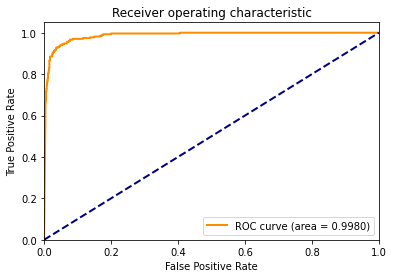

[[[ 969   28]
  [  48  241]]

 [[1125    1]
  [  13  147]]

 [[ 998   18]
  [  33  237]]

 [[1063   84]
  [  47   92]]

 [[1081   69]
  [  42   94]]

 [[ 946   48]
  [  65  227]]]


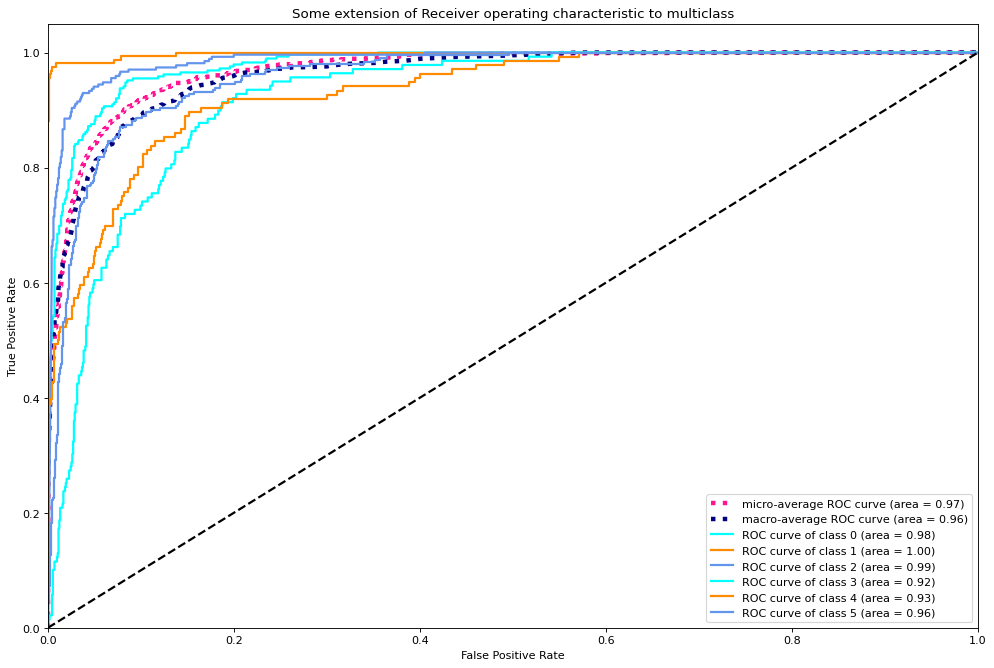

              precision    recall  f1-score   support

           0       0.90      0.83      0.86       289
           1       0.99      0.92      0.95       160
           2       0.93      0.88      0.90       270
           3       0.52      0.66      0.58       139
           4       0.58      0.69      0.63       136
           5       0.83      0.78      0.80       292

    accuracy                           0.81      1286
   macro avg       0.79      0.79      0.79      1286
weighted avg       0.82      0.81      0.81      1286


Model name: Naive Bayes, calibration algo: sigmoid


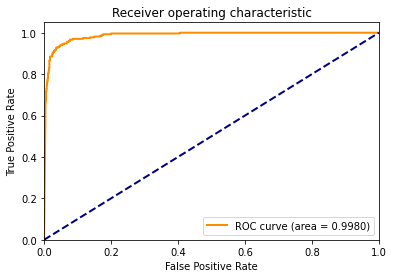

[[[ 969   28]
  [  48  241]]

 [[1125    1]
  [  13  147]]

 [[ 998   18]
  [  33  237]]

 [[1063   84]
  [  47   92]]

 [[1081   69]
  [  42   94]]

 [[ 946   48]
  [  65  227]]]


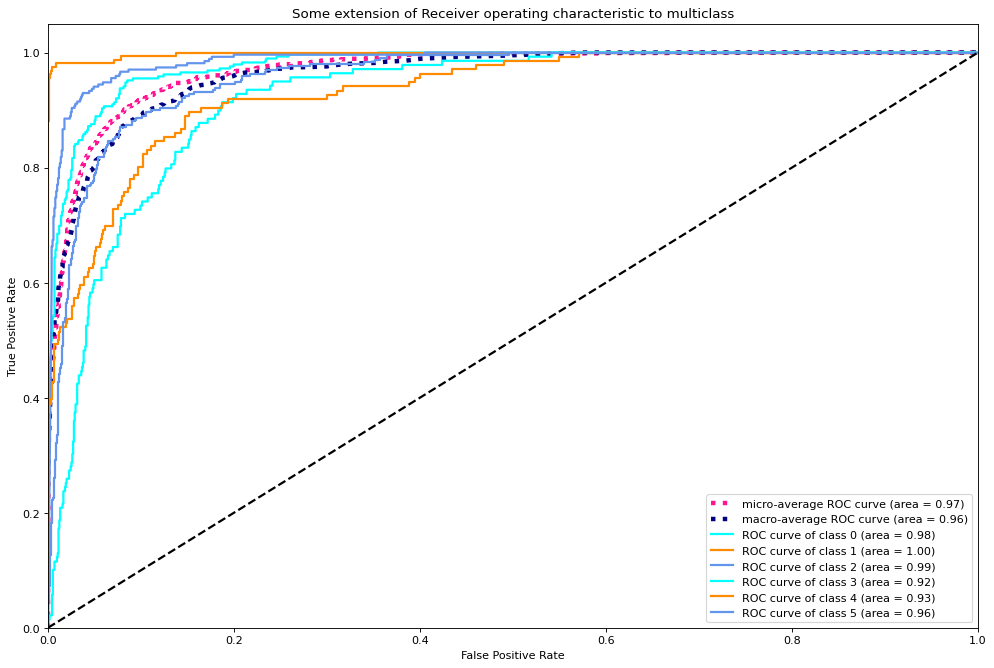

              precision    recall  f1-score   support

           0       0.89      0.84      0.86       289
           1       0.99      0.92      0.95       160
           2       0.93      0.88      0.90       270
           3       0.54      0.65      0.59       139
           4       0.58      0.68      0.62       136
           5       0.82      0.79      0.80       292

    accuracy                           0.81      1286
   macro avg       0.79      0.79      0.79      1286
weighted avg       0.82      0.81      0.82      1286


Model name: Naive Bayes, calibration algo: isotonic


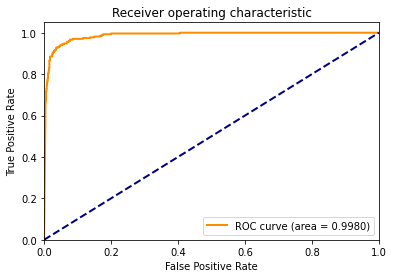

[[[ 969   28]
  [  48  241]]

 [[1125    1]
  [  13  147]]

 [[ 998   18]
  [  33  237]]

 [[1063   84]
  [  47   92]]

 [[1081   69]
  [  42   94]]

 [[ 946   48]
  [  65  227]]]


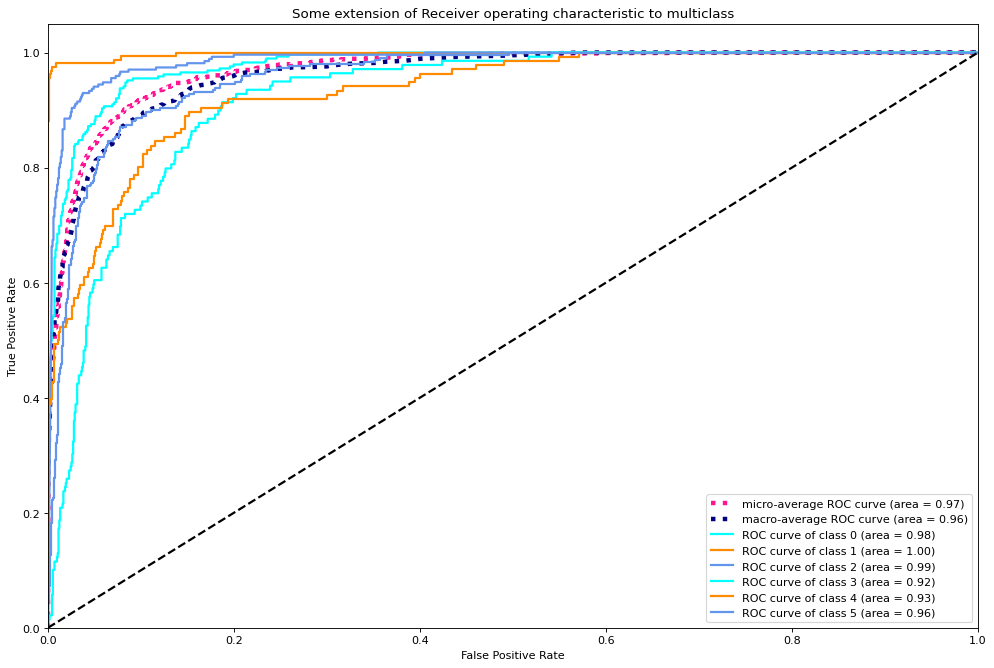

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       289
           1       0.99      0.92      0.95       160
           2       0.88      0.93      0.90       270
           3       0.56      0.55      0.55       139
           4       0.62      0.64      0.63       136
           5       0.82      0.80      0.81       292

    accuracy                           0.82      1286
   macro avg       0.79      0.79      0.79      1286
weighted avg       0.82      0.82      0.82      1286


Model name: Naive Bayes, calibration algo: sigmoid cv


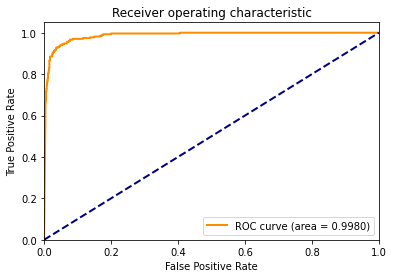

[[[ 969   28]
  [  48  241]]

 [[1125    1]
  [  13  147]]

 [[ 998   18]
  [  33  237]]

 [[1063   84]
  [  47   92]]

 [[1081   69]
  [  42   94]]

 [[ 946   48]
  [  65  227]]]


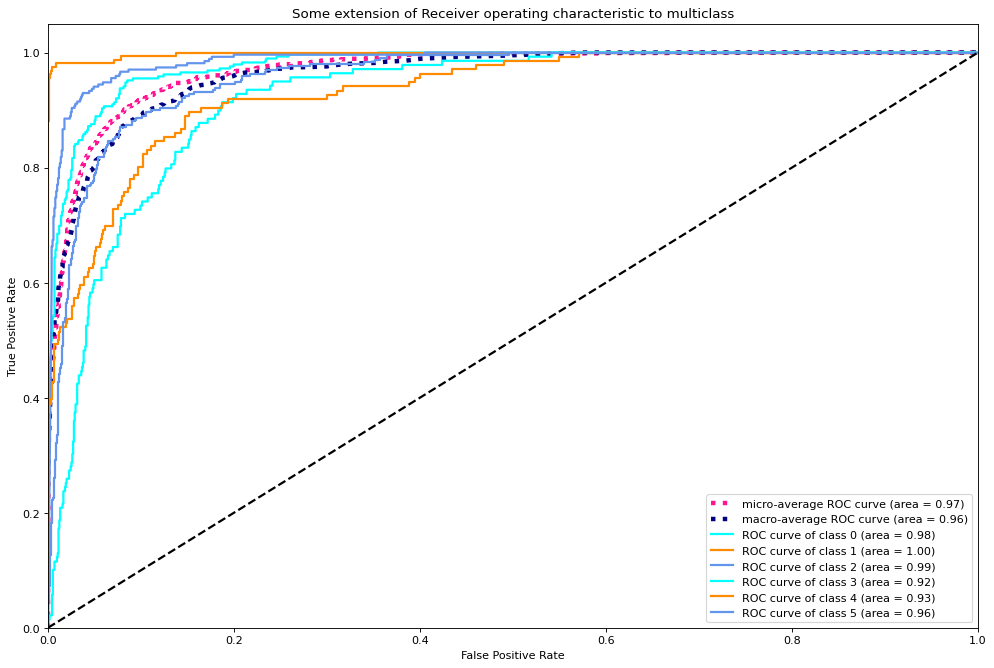

              precision    recall  f1-score   support

           0       0.89      0.84      0.87       289
           1       0.99      0.92      0.95       160
           2       0.93      0.89      0.91       270
           3       0.54      0.65      0.59       139
           4       0.58      0.68      0.63       136
           5       0.82      0.80      0.81       292

    accuracy                           0.81      1286
   macro avg       0.79      0.80      0.79      1286
weighted avg       0.83      0.81      0.82      1286


Model name: Naive Bayes, calibration algo: isotonic cv


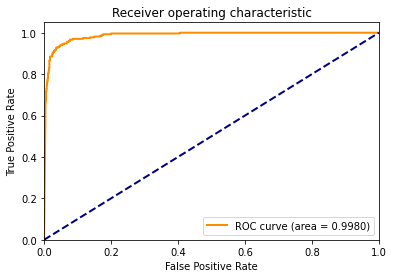

[[[ 969   28]
  [  48  241]]

 [[1125    1]
  [  13  147]]

 [[ 998   18]
  [  33  237]]

 [[1063   84]
  [  47   92]]

 [[1081   69]
  [  42   94]]

 [[ 946   48]
  [  65  227]]]


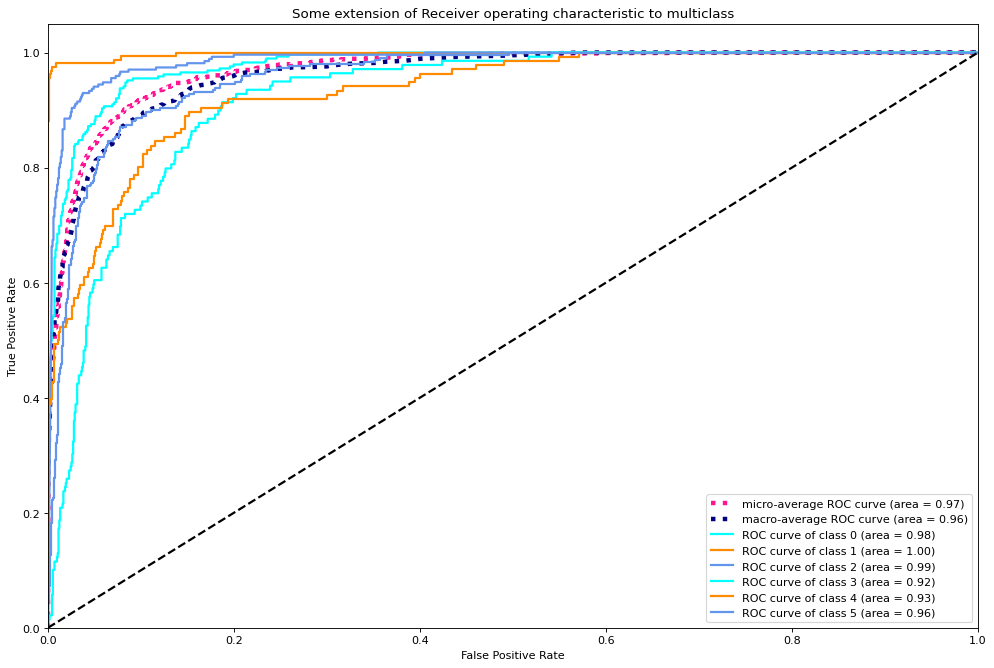

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       289
           1       0.99      0.94      0.96       160
           2       0.88      0.94      0.91       270
           3       0.60      0.55      0.58       139
           4       0.74      0.60      0.66       136
           5       0.80      0.84      0.82       292

    accuracy                           0.83      1286
   macro avg       0.82      0.80      0.80      1286
weighted avg       0.83      0.83      0.83      1286


Model name: Naive Bayes, calibration algo: ivap


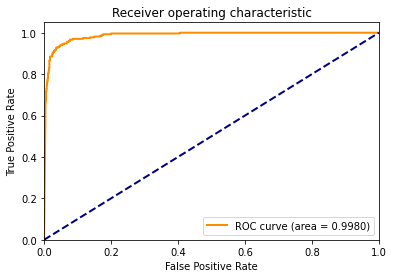

[[[ 969   28]
  [  48  241]]

 [[1125    1]
  [  13  147]]

 [[ 998   18]
  [  33  237]]

 [[1063   84]
  [  47   92]]

 [[1081   69]
  [  42   94]]

 [[ 946   48]
  [  65  227]]]


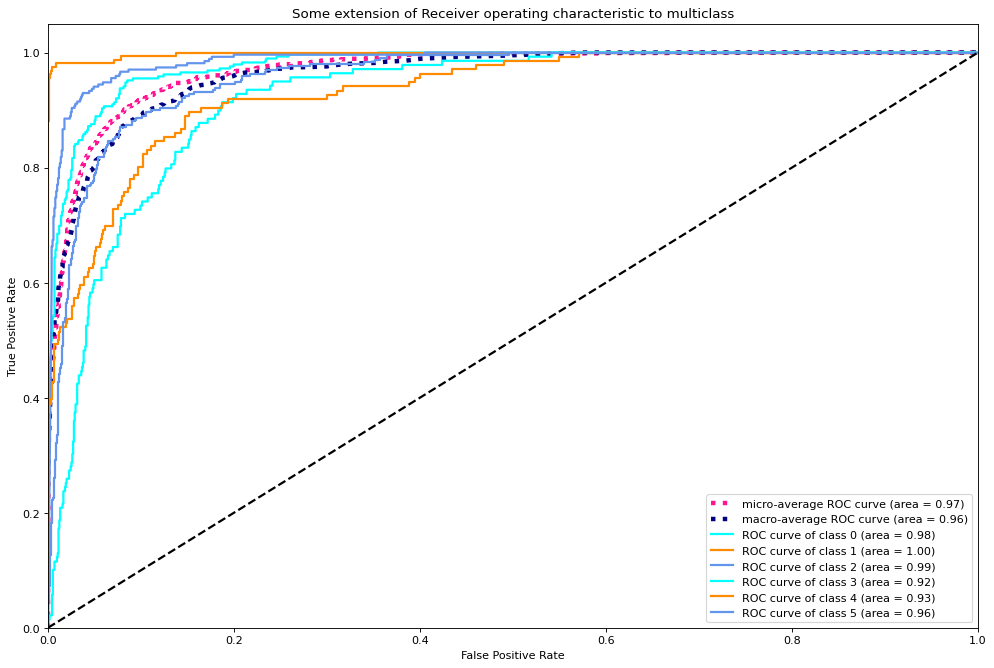

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       289
           1       0.99      0.90      0.94       160
           2       0.91      0.91      0.91       270
           3       0.59      0.62      0.60       139
           4       0.66      0.63      0.65       136
           5       0.81      0.80      0.81       292

    accuracy                           0.83      1286
   macro avg       0.81      0.80      0.80      1286
weighted avg       0.83      0.83      0.83      1286


Model name: Naive Bayes, calibration algo: cvap


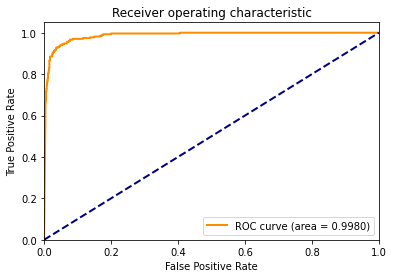

[[[ 969   28]
  [  48  241]]

 [[1125    1]
  [  13  147]]

 [[ 998   18]
  [  33  237]]

 [[1063   84]
  [  47   92]]

 [[1081   69]
  [  42   94]]

 [[ 946   48]
  [  65  227]]]


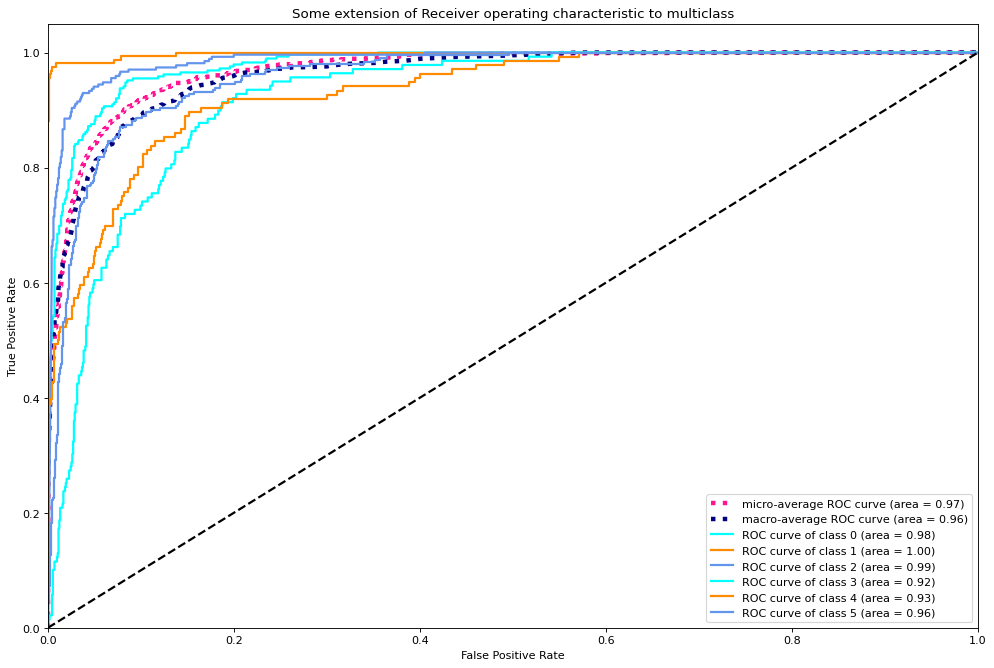

              precision    recall  f1-score   support

           0       0.86      0.95      0.91       289
           1       0.99      0.93      0.96       160
           2       0.89      0.93      0.91       270
           3       0.55      0.40      0.47       139
           4       0.78      0.58      0.67       136
           5       0.75      0.86      0.80       292

    accuracy                           0.83      1286
   macro avg       0.81      0.78      0.79      1286
weighted avg       0.82      0.83      0.82      1286



In [60]:
clf_NB = GaussianNB()

[y_pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_NB, model_name = 'Naive Bayes')

In [61]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   1.015793  0.165134  0.162719    0.163699   
KNN                                NaN       NaN       NaN         NaN   
Support Vector Machine             NaN       NaN       NaN         NaN   
logistic regression                NaN       NaN       NaN         NaN   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.140868  0.155458  0.152873  
KNN                             NaN       NaN       NaN  
Support Vector Machine          NaN       NaN       NaN  
logistic regression             NaN       NaN       NaN  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [62]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.061694  0.047837   0.04339    0.047269   
KNN                                NaN       NaN       NaN         NaN   
Support Vector Machine             NaN       NaN       NaN         NaN   
logistic regression                NaN       NaN       NaN         NaN   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv     ivap      cvap  
Naive Bayes                0.041502  0.04448  0.043124  
KNN                             NaN      NaN       NaN  
Support Vector Machine          NaN      NaN       NaN  
logistic regression             NaN      NaN       NaN  
neural network                  NaN      NaN       NaN  
Random Forest                   NaN      NaN       NaN  
LightGBM                        NaN      NaN       NaN  
XGBoost                         NaN      NaN       NaN  
CatBoost                        NaN      NaN       NaN  
Ada Boost                       NaN      NaN       NaN

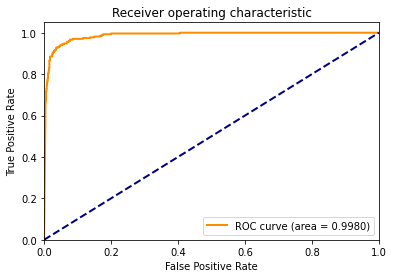

[[[ 969   28]
  [  48  241]]

 [[1125    1]
  [  13  147]]

 [[ 998   18]
  [  33  237]]

 [[1063   84]
  [  47   92]]

 [[1081   69]
  [  42   94]]

 [[ 946   48]
  [  65  227]]]


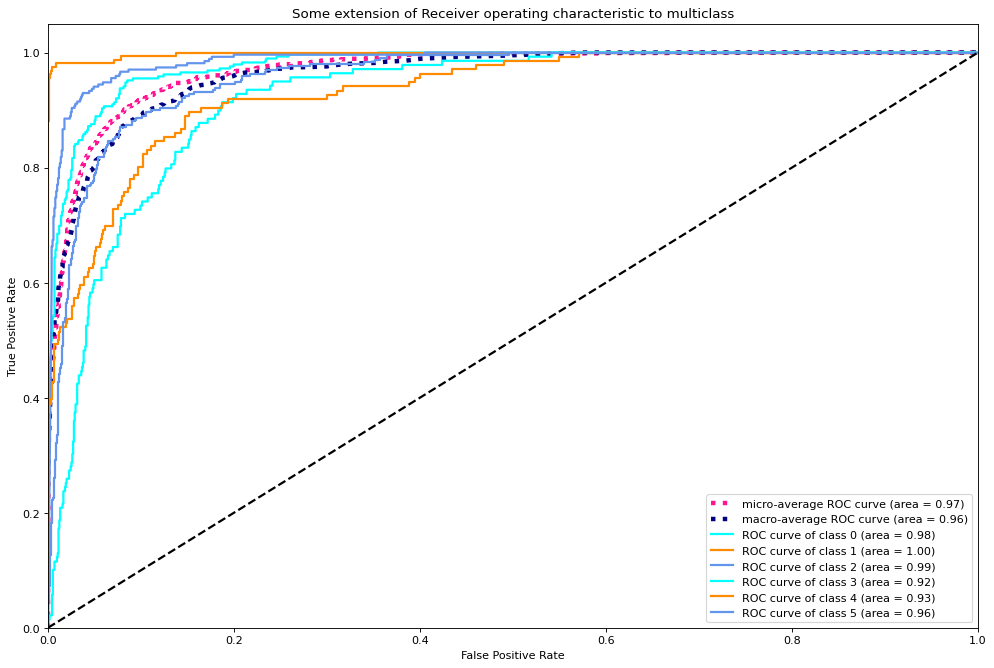

In [63]:

plot_roc_curve(y_test, y_pred_probs_list[0], y_pred_class_list[0], n_classes = n_classes)

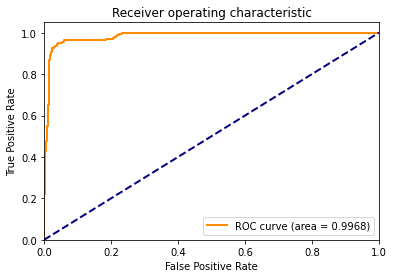

[[[ 967   30]
  [  46  243]]

 [[1125    1]
  [  13  147]]

 [[ 997   19]
  [  32  238]]

 [[1069   78]
  [  48   91]]

 [[1083   67]
  [  44   92]]

 [[ 944   50]
  [  62  230]]]


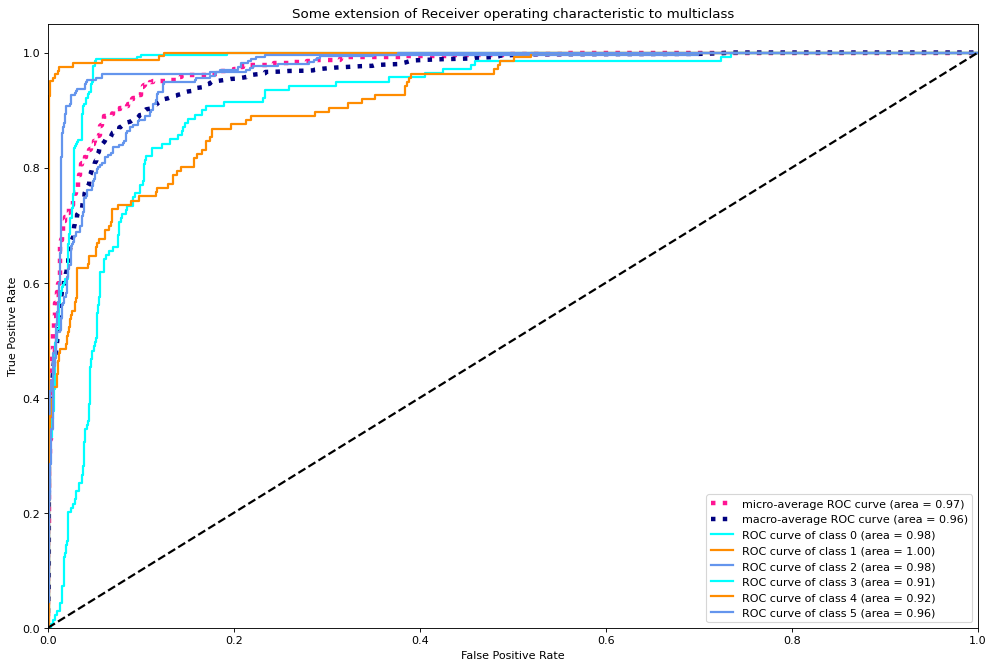

In [64]:

plot_roc_curve(y_test, y_pred_probs_list[1], y_pred_class_list[1], n_classes = n_classes)

### KNN Classifier


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:0
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 0, j:4
fitting model for i: 0, j:5
fitting model for i: 1, j:0
fitting model for i: 1, j:1
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 1, j:4
fitting model for i: 1, j:5
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:2
fitting model for i: 2, j:3
fitting model for i: 2, j:4
fitting model for i: 2, j:5
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2
fitting model for i: 3, j:3
fitting model for i: 3, j:4
fitting model for i: 3, j:5
fitting model for i: 4, j:0
fitting model for i: 4, j:1
fitting model for i: 4, j:2
fitting model for i: 4, j:3
fitting model for i: 4, j:4
fitting model for i: 4, j:5
fitting model for i: 5, j:0
fitting model for i: 5, j:1
fitting model for i: 5, j:2
fitting model for i: 5, j:3
fit

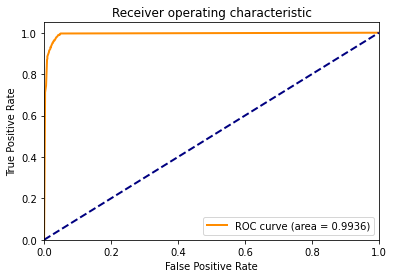

[[[ 991    6]
  [   6  283]]

 [[1123    3]
  [   4  156]]

 [[ 995   21]
  [  18  252]]

 [[1116   31]
  [  42   97]]

 [[1137   13]
  [  15  121]]

 [[ 957   37]
  [  26  266]]]


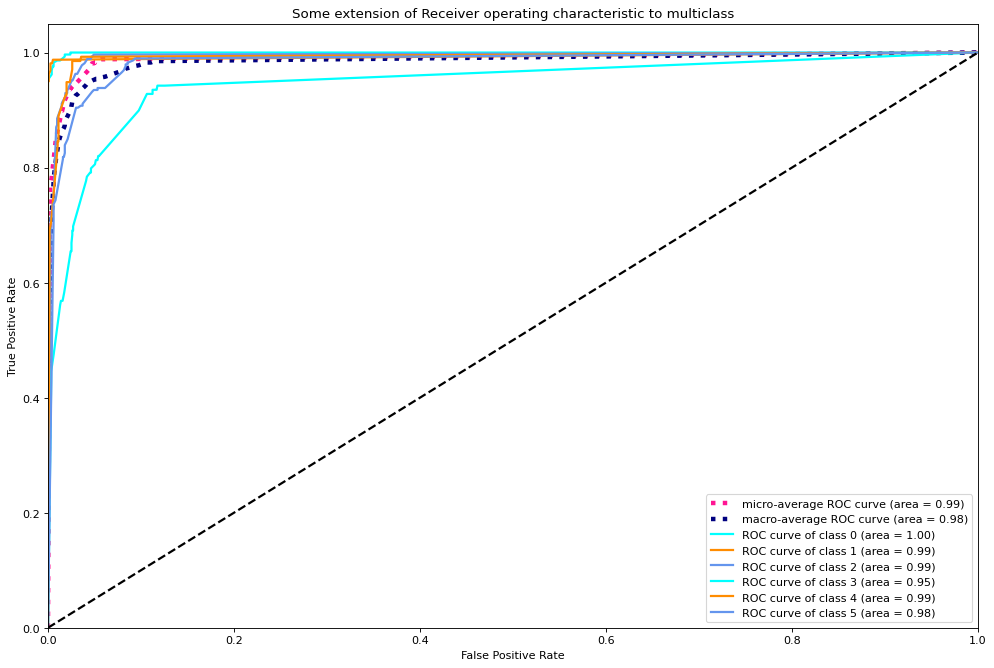

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       289
           1       0.98      0.97      0.98       160
           2       0.92      0.93      0.93       270
           3       0.76      0.70      0.73       139
           4       0.90      0.89      0.90       136
           5       0.88      0.91      0.89       292

    accuracy                           0.91      1286
   macro avg       0.90      0.90      0.90      1286
weighted avg       0.91      0.91      0.91      1286


Model name: KNN, calibration algo: sigmoid


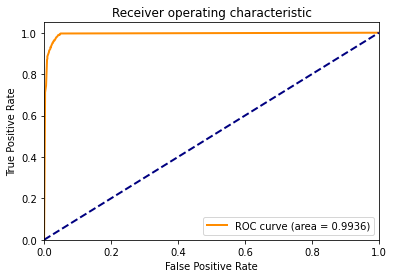

[[[ 991    6]
  [   6  283]]

 [[1123    3]
  [   4  156]]

 [[ 995   21]
  [  18  252]]

 [[1116   31]
  [  42   97]]

 [[1137   13]
  [  15  121]]

 [[ 957   37]
  [  26  266]]]


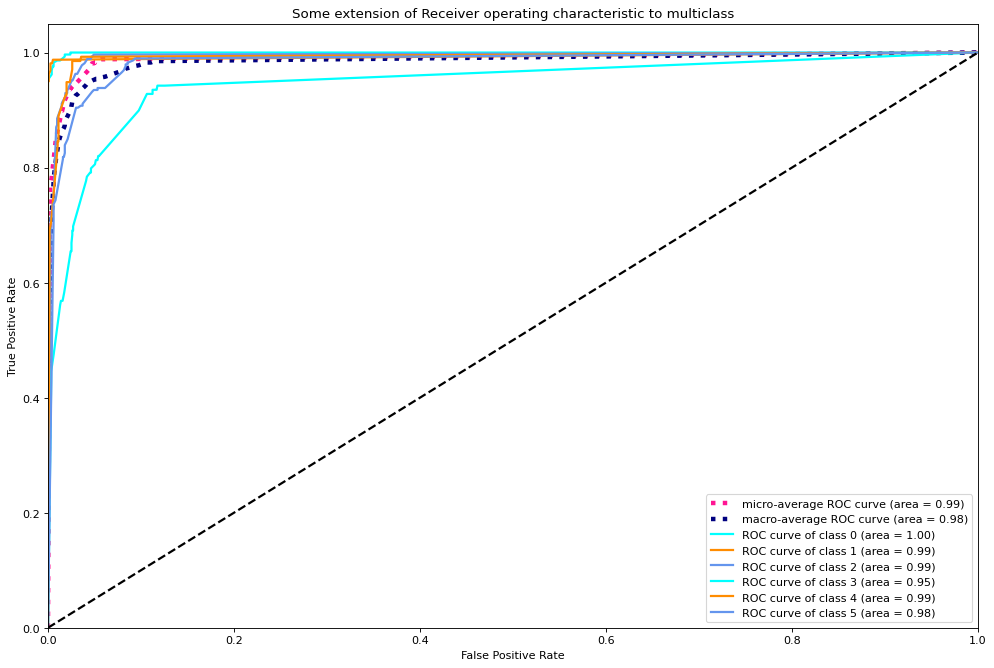

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       289
           1       0.99      0.98      0.98       160
           2       0.92      0.93      0.92       270
           3       0.72      0.65      0.69       139
           4       0.91      0.87      0.89       136
           5       0.87      0.91      0.89       292

    accuracy                           0.91      1286
   macro avg       0.90      0.89      0.89      1286
weighted avg       0.91      0.91      0.91      1286


Model name: KNN, calibration algo: isotonic


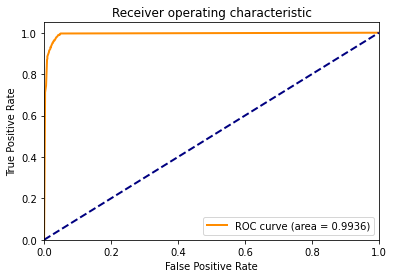

[[[ 991    6]
  [   6  283]]

 [[1123    3]
  [   4  156]]

 [[ 995   21]
  [  18  252]]

 [[1116   31]
  [  42   97]]

 [[1137   13]
  [  15  121]]

 [[ 957   37]
  [  26  266]]]


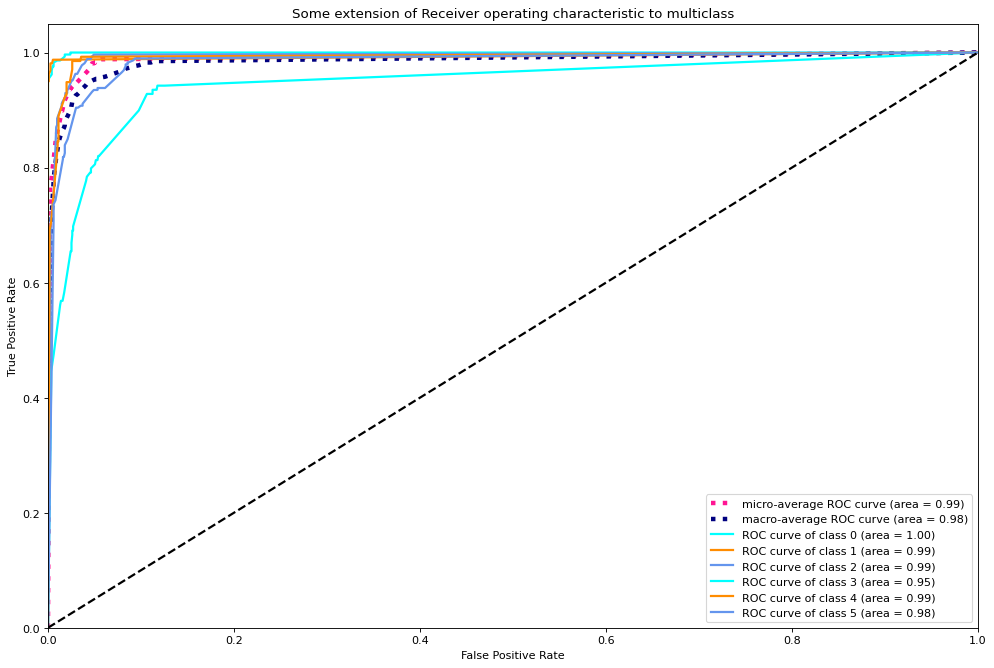

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       289
           1       0.99      0.97      0.98       160
           2       0.92      0.93      0.92       270
           3       0.76      0.59      0.66       139
           4       0.88      0.89      0.88       136
           5       0.84      0.92      0.88       292

    accuracy                           0.90      1286
   macro avg       0.89      0.88      0.88      1286
weighted avg       0.90      0.90      0.90      1286


Model name: KNN, calibration algo: sigmoid cv


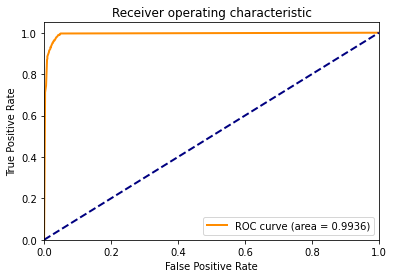

[[[ 991    6]
  [   6  283]]

 [[1123    3]
  [   4  156]]

 [[ 995   21]
  [  18  252]]

 [[1116   31]
  [  42   97]]

 [[1137   13]
  [  15  121]]

 [[ 957   37]
  [  26  266]]]


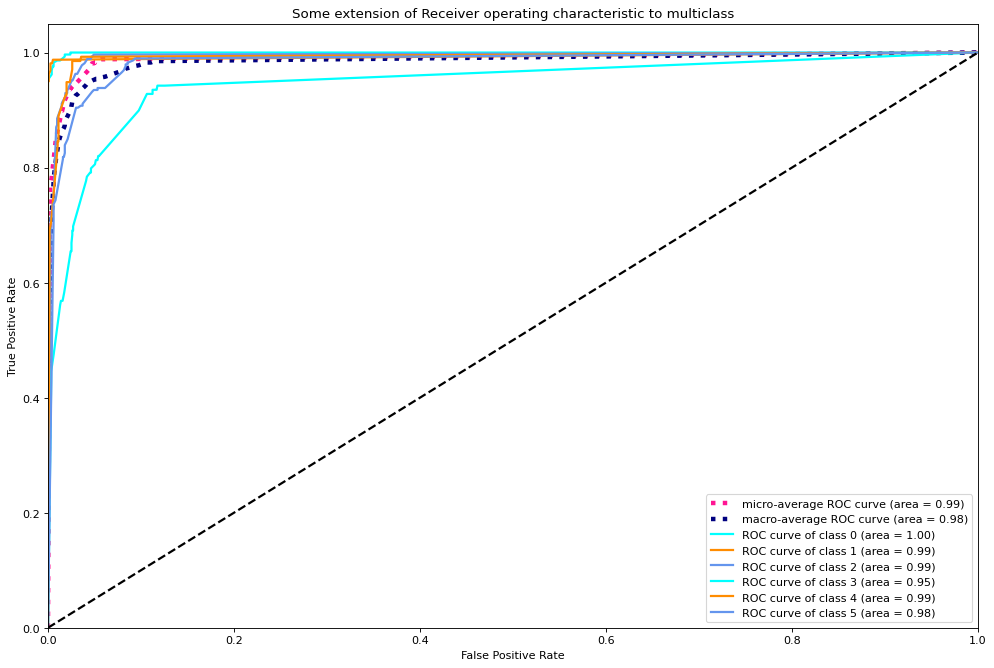

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       289
           1       0.98      0.97      0.98       160
           2       0.92      0.94      0.93       270
           3       0.80      0.65      0.71       139
           4       0.90      0.88      0.89       136
           5       0.87      0.92      0.89       292

    accuracy                           0.91      1286
   macro avg       0.91      0.89      0.90      1286
weighted avg       0.91      0.91      0.91      1286


Model name: KNN, calibration algo: isotonic cv


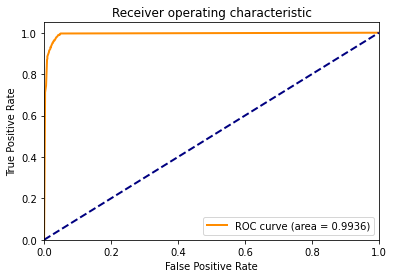

[[[ 991    6]
  [   6  283]]

 [[1123    3]
  [   4  156]]

 [[ 995   21]
  [  18  252]]

 [[1116   31]
  [  42   97]]

 [[1137   13]
  [  15  121]]

 [[ 957   37]
  [  26  266]]]


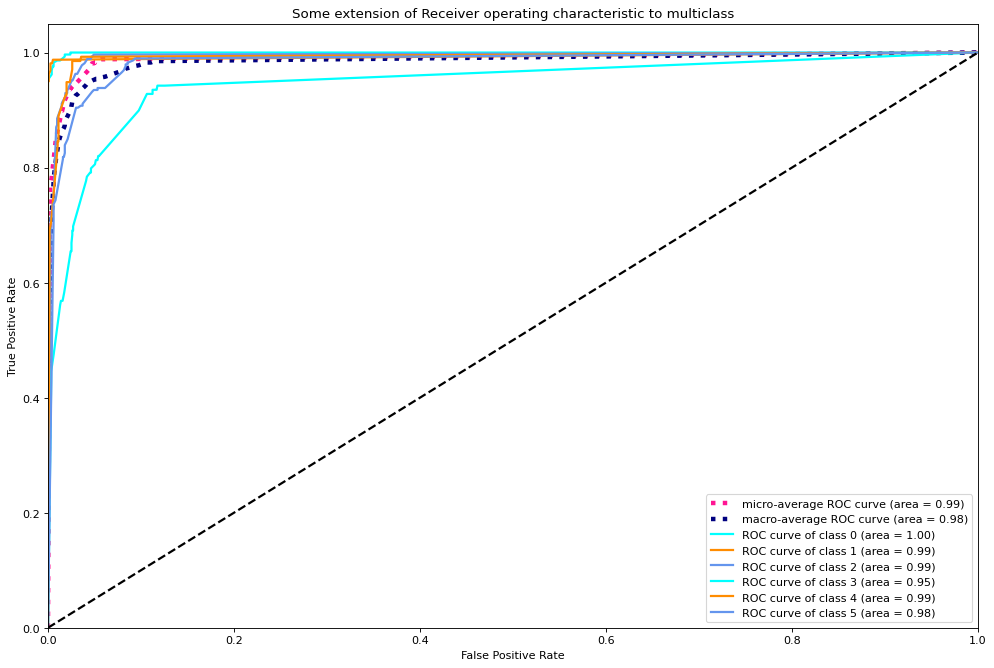

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       289
           1       0.99      0.98      0.98       160
           2       0.91      0.94      0.93       270
           3       0.82      0.65      0.72       139
           4       0.88      0.91      0.90       136
           5       0.88      0.92      0.90       292

    accuracy                           0.92      1286
   macro avg       0.91      0.90      0.90      1286
weighted avg       0.91      0.92      0.91      1286


Model name: KNN, calibration algo: ivap


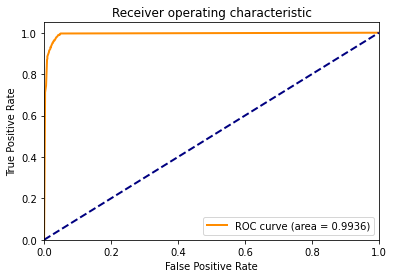

[[[ 991    6]
  [   6  283]]

 [[1123    3]
  [   4  156]]

 [[ 995   21]
  [  18  252]]

 [[1116   31]
  [  42   97]]

 [[1137   13]
  [  15  121]]

 [[ 957   37]
  [  26  266]]]


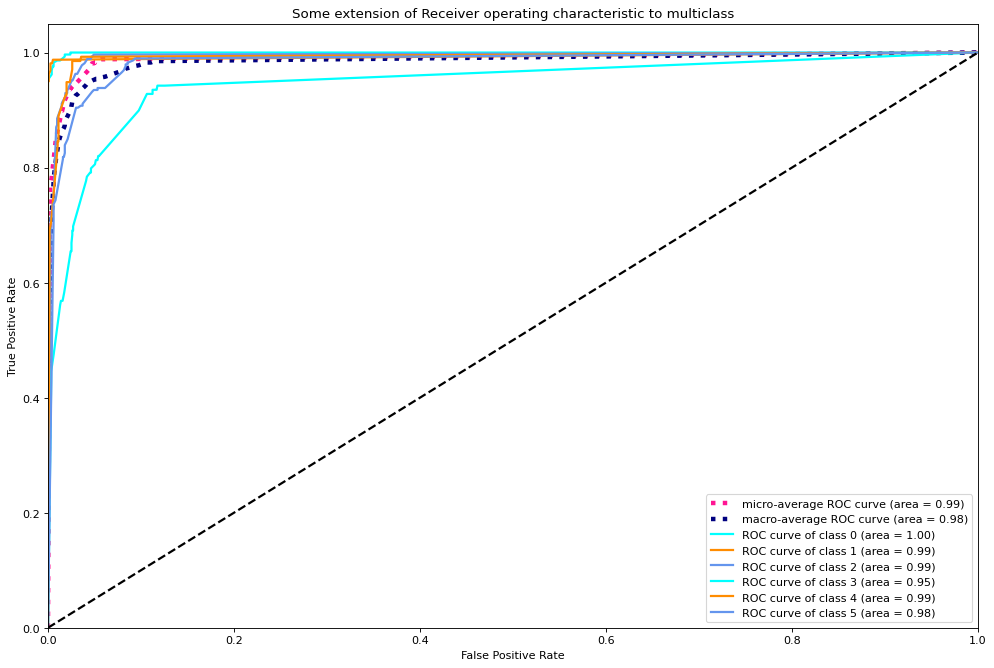

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       289
           1       0.99      0.96      0.97       160
           2       0.89      0.96      0.92       270
           3       0.77      0.64      0.70       139
           4       0.83      0.94      0.88       136
           5       0.88      0.89      0.88       292

    accuracy                           0.91      1286
   macro avg       0.89      0.89      0.89      1286
weighted avg       0.91      0.91      0.90      1286


Model name: KNN, calibration algo: cvap


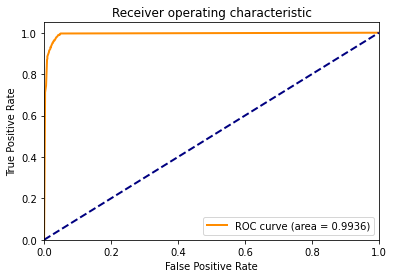

[[[ 991    6]
  [   6  283]]

 [[1123    3]
  [   4  156]]

 [[ 995   21]
  [  18  252]]

 [[1116   31]
  [  42   97]]

 [[1137   13]
  [  15  121]]

 [[ 957   37]
  [  26  266]]]


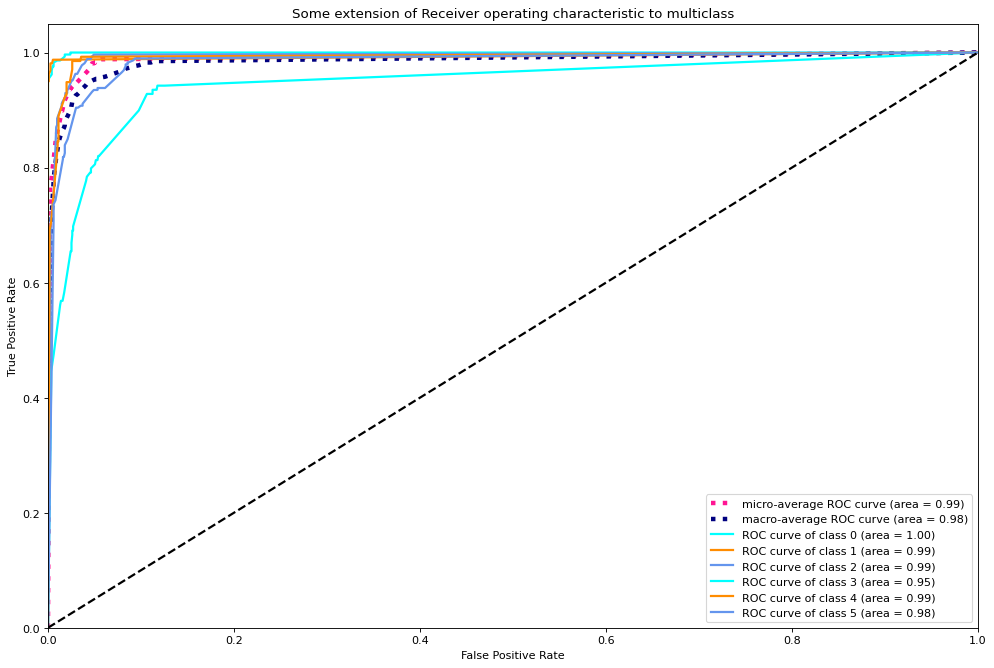

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       289
           1       0.97      0.97      0.97       160
           2       0.91      0.95      0.93       270
           3       0.81      0.65      0.73       139
           4       0.90      0.90      0.90       136
           5       0.88      0.93      0.90       292

    accuracy                           0.92      1286
   macro avg       0.91      0.90      0.90      1286
weighted avg       0.92      0.92      0.91      1286



In [65]:
clf_KNN = KNeighborsClassifier()

[y_pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_KNN, 
                    model_name = 'KNN')

In [66]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   1.015793  0.165134  0.162719    0.163699   
KNN                           0.184904  0.080174  0.114040    0.074169   
Support Vector Machine             NaN       NaN       NaN         NaN   
logistic regression                NaN       NaN       NaN         NaN   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.140868  0.155458  0.152873  
KNN                        0.066965  0.269102  0.271722  
Support Vector Machine          NaN       NaN       NaN  
logistic regression             NaN       NaN       NaN  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [67]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.061694  0.047837  0.043390    0.047269   
KNN                           0.021092  0.022677  0.022308    0.020846   
Support Vector Machine             NaN       NaN       NaN         NaN   
logistic regression                NaN       NaN       NaN         NaN   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv     ivap      cvap  
Naive Bayes                0.041502  0.04448  0.043124  
KNN                        0.019987  0.07845  0.078399  
Support Vector Machine          NaN      NaN       NaN  
logistic regression             NaN      NaN       NaN  
neural network                  NaN      NaN       NaN  
Random Forest                   NaN      NaN       NaN  
LightGBM                        NaN      NaN       NaN  
XGBoost                         NaN      NaN       NaN  
CatBoost                        NaN      NaN       NaN  
Ada Boost                       NaN      NaN       NaN

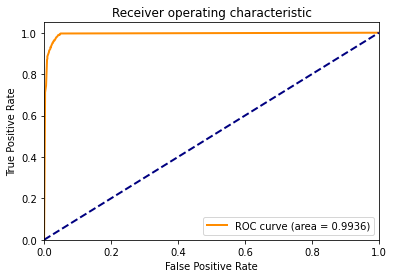

[[[ 991    6]
  [   6  283]]

 [[1123    3]
  [   4  156]]

 [[ 995   21]
  [  18  252]]

 [[1116   31]
  [  42   97]]

 [[1137   13]
  [  15  121]]

 [[ 957   37]
  [  26  266]]]


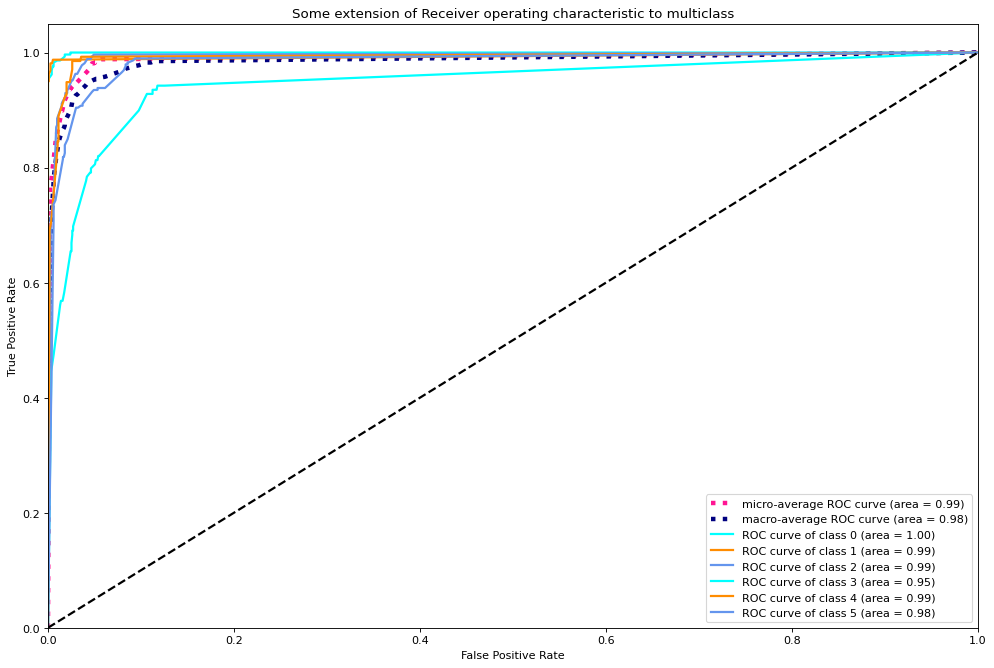

In [68]:

plot_roc_curve(y_test, y_pred_probs_list[0], y_pred_class_list[0], n_classes = n_classes)

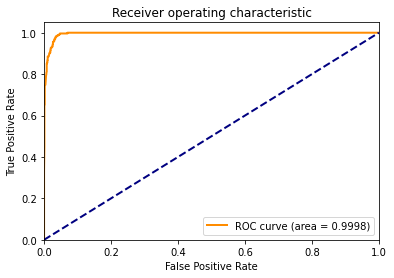

[[[ 989    8]
  [   5  284]]

 [[1124    2]
  [   3  157]]

 [[ 993   23]
  [  19  251]]

 [[1112   35]
  [  48   91]]

 [[1138   12]
  [  18  118]]

 [[ 954   40]
  [  27  265]]]


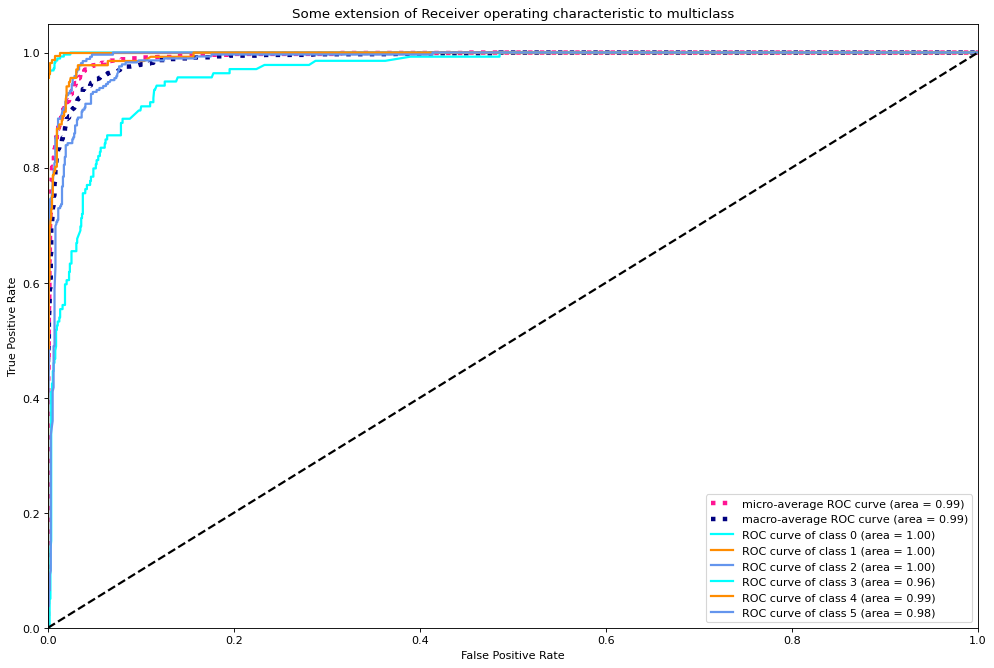

In [69]:

plot_roc_curve(y_test, y_pred_probs_list[1], y_pred_class_list[1], n_classes = n_classes)

### Support Vector Machine


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:0
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 0, j:4
fitting model for i: 0, j:5
fitting model for i: 1, j:0
fitting model for i: 1, j:1
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 1, j:4
fitting model for i: 1, j:5
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:2
fitting model for i: 2, j:3
fitting model for i: 2, j:4
fitting model for i: 2, j:5
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2
fitting model for i: 3, j:3
fitting model for i: 3, j:4
fitting model for i: 3, j:5
fitting model for i: 4, j:0
fitting model for i: 4, j:1
fitting model for i: 4, j:2
fitting model for i: 4, j:3
fitting model for i: 4, j:4
fitting model for i: 4, j:5
fitting model for i: 5, j:0
fitting model for i: 5, j:1
fitting model for i: 5, j:2
fitting model for i: 5, j:3
fit

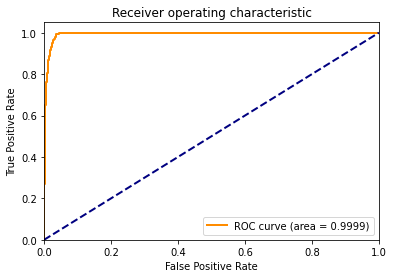

[[[ 992    5]
  [   4  285]]

 [[1123    3]
  [   3  157]]

 [[ 991   25]
  [  13  257]]

 [[1126   21]
  [  53   86]]

 [[1140   10]
  [  15  121]]

 [[ 950   44]
  [  20  272]]]


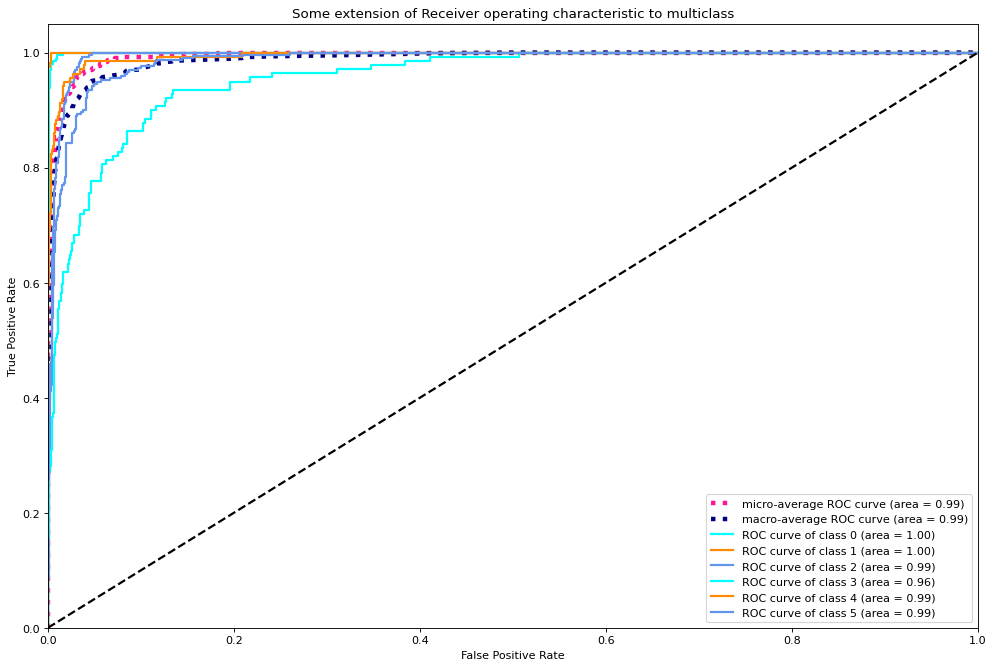

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       289
           1       0.98      0.98      0.98       160
           2       0.91      0.95      0.93       270
           3       0.80      0.62      0.70       139
           4       0.92      0.89      0.91       136
           5       0.86      0.93      0.89       292

    accuracy                           0.92      1286
   macro avg       0.91      0.89      0.90      1286
weighted avg       0.91      0.92      0.91      1286


Model name: Support Vector Machine, calibration algo: sigmoid


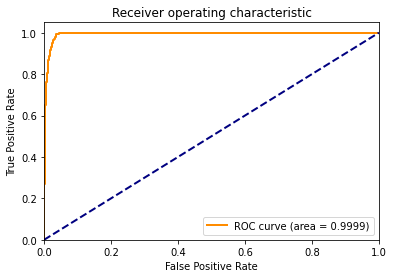

[[[ 992    5]
  [   4  285]]

 [[1123    3]
  [   3  157]]

 [[ 991   25]
  [  13  257]]

 [[1126   21]
  [  53   86]]

 [[1140   10]
  [  15  121]]

 [[ 950   44]
  [  20  272]]]


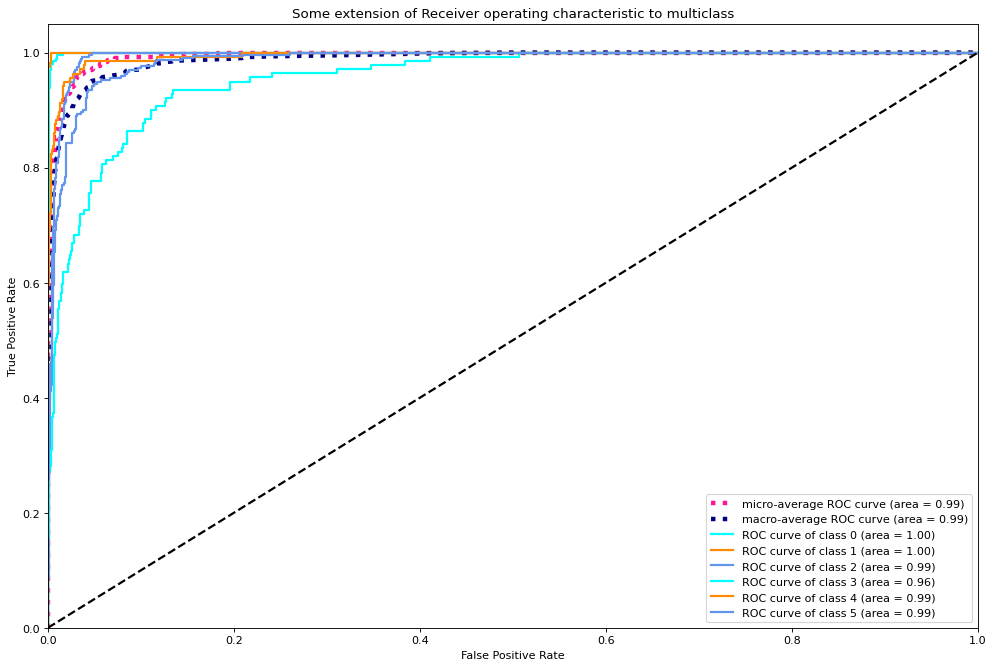

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       289
           1       0.99      0.98      0.98       160
           2       0.90      0.94      0.92       270
           3       0.74      0.60      0.67       139
           4       0.91      0.87      0.89       136
           5       0.86      0.91      0.88       292

    accuracy                           0.91      1286
   macro avg       0.90      0.88      0.89      1286
weighted avg       0.90      0.91      0.90      1286


Model name: Support Vector Machine, calibration algo: isotonic


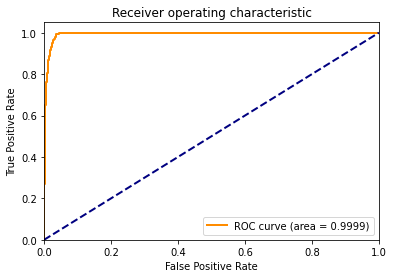

[[[ 992    5]
  [   4  285]]

 [[1123    3]
  [   3  157]]

 [[ 991   25]
  [  13  257]]

 [[1126   21]
  [  53   86]]

 [[1140   10]
  [  15  121]]

 [[ 950   44]
  [  20  272]]]


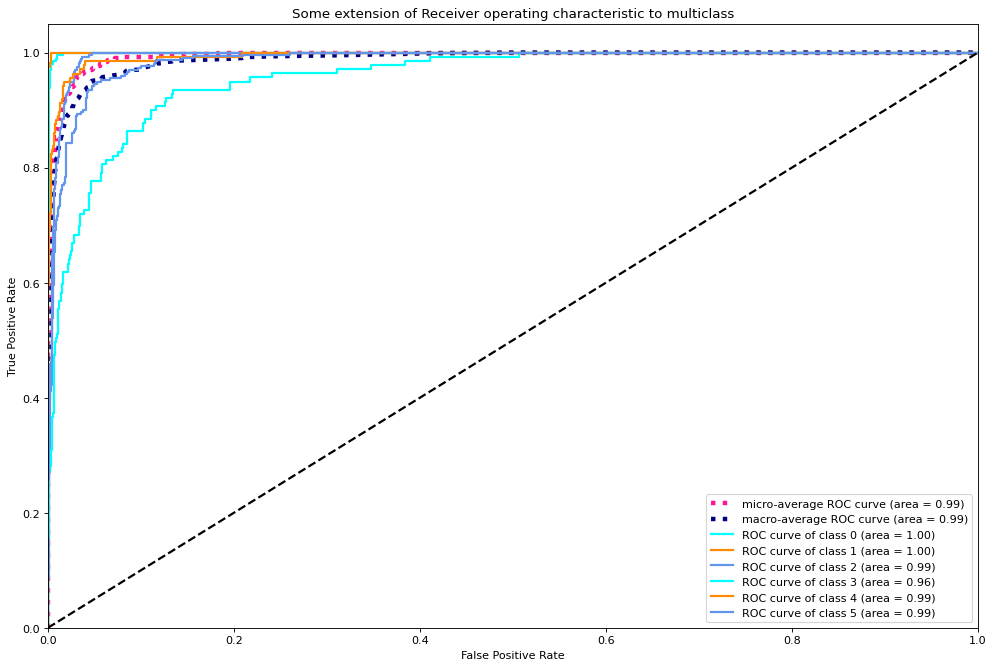

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       289
           1       0.99      0.98      0.98       160
           2       0.89      0.96      0.92       270
           3       0.81      0.57      0.67       139
           4       0.88      0.88      0.88       136
           5       0.85      0.92      0.88       292

    accuracy                           0.91      1286
   macro avg       0.90      0.88      0.89      1286
weighted avg       0.90      0.91      0.90      1286


Model name: Support Vector Machine, calibration algo: sigmoid cv


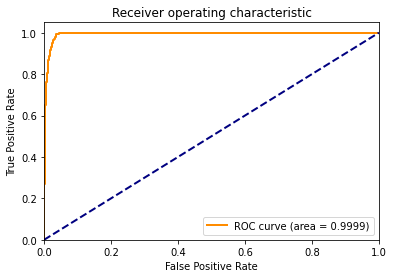

[[[ 992    5]
  [   4  285]]

 [[1123    3]
  [   3  157]]

 [[ 991   25]
  [  13  257]]

 [[1126   21]
  [  53   86]]

 [[1140   10]
  [  15  121]]

 [[ 950   44]
  [  20  272]]]


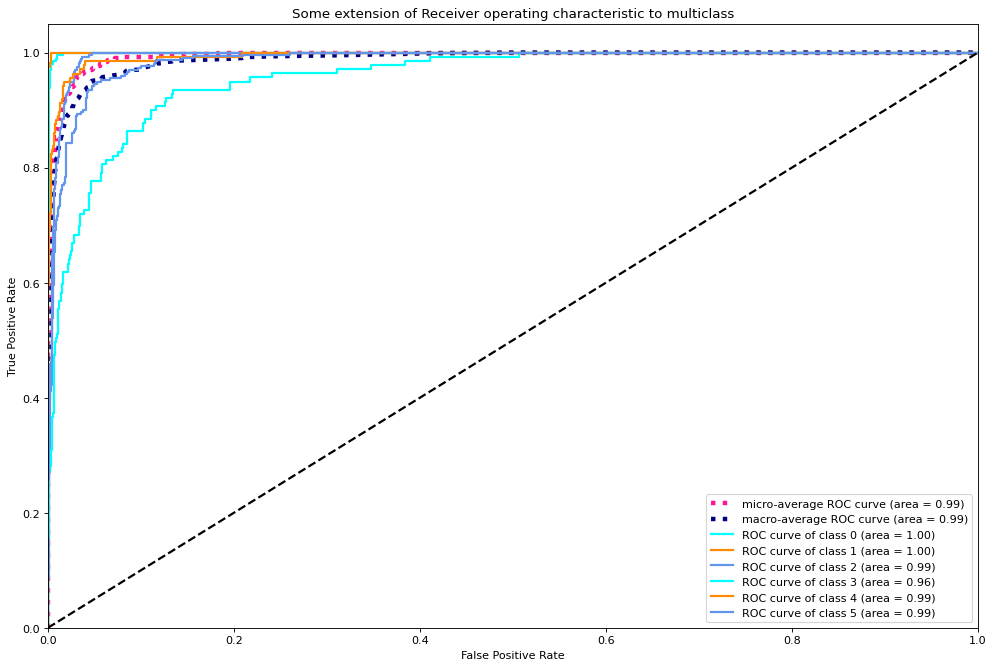

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       289
           1       0.98      0.98      0.98       160
           2       0.90      0.95      0.93       270
           3       0.77      0.61      0.68       139
           4       0.93      0.86      0.89       136
           5       0.86      0.92      0.89       292

    accuracy                           0.91      1286
   macro avg       0.90      0.89      0.89      1286
weighted avg       0.91      0.91      0.91      1286


Model name: Support Vector Machine, calibration algo: isotonic cv


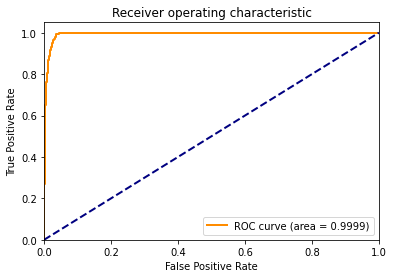

[[[ 992    5]
  [   4  285]]

 [[1123    3]
  [   3  157]]

 [[ 991   25]
  [  13  257]]

 [[1126   21]
  [  53   86]]

 [[1140   10]
  [  15  121]]

 [[ 950   44]
  [  20  272]]]


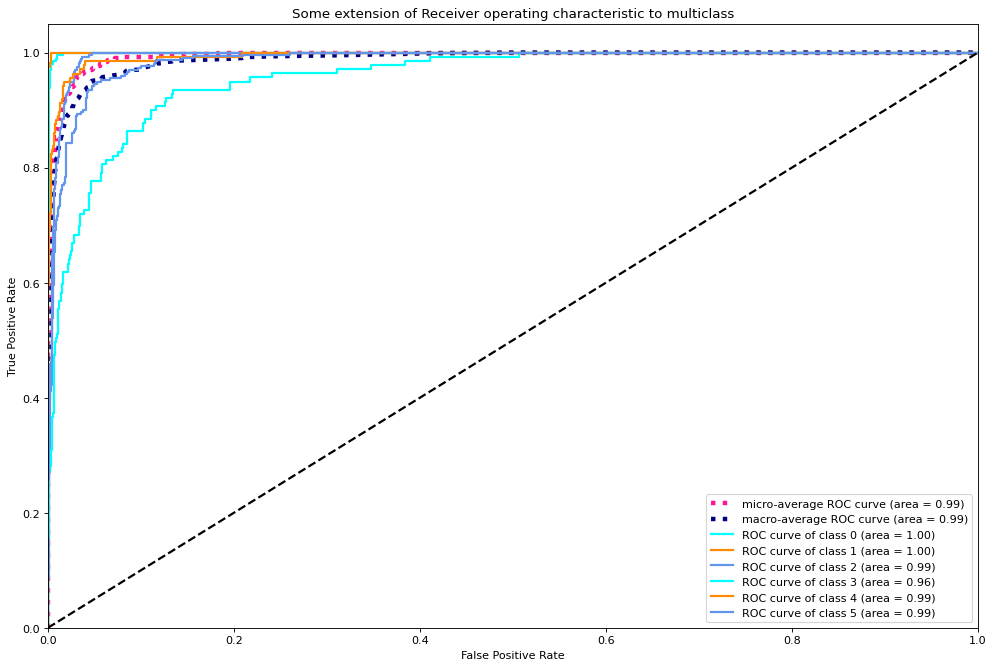

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       289
           1       0.98      0.98      0.98       160
           2       0.90      0.95      0.92       270
           3       0.77      0.61      0.68       139
           4       0.92      0.88      0.89       136
           5       0.86      0.91      0.89       292

    accuracy                           0.91      1286
   macro avg       0.90      0.89      0.89      1286
weighted avg       0.91      0.91      0.91      1286


Model name: Support Vector Machine, calibration algo: ivap


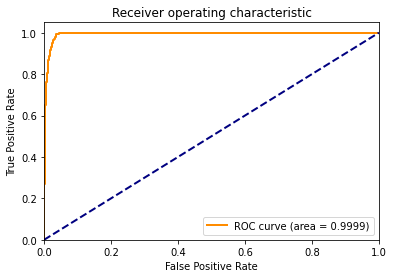

[[[ 992    5]
  [   4  285]]

 [[1123    3]
  [   3  157]]

 [[ 991   25]
  [  13  257]]

 [[1126   21]
  [  53   86]]

 [[1140   10]
  [  15  121]]

 [[ 950   44]
  [  20  272]]]


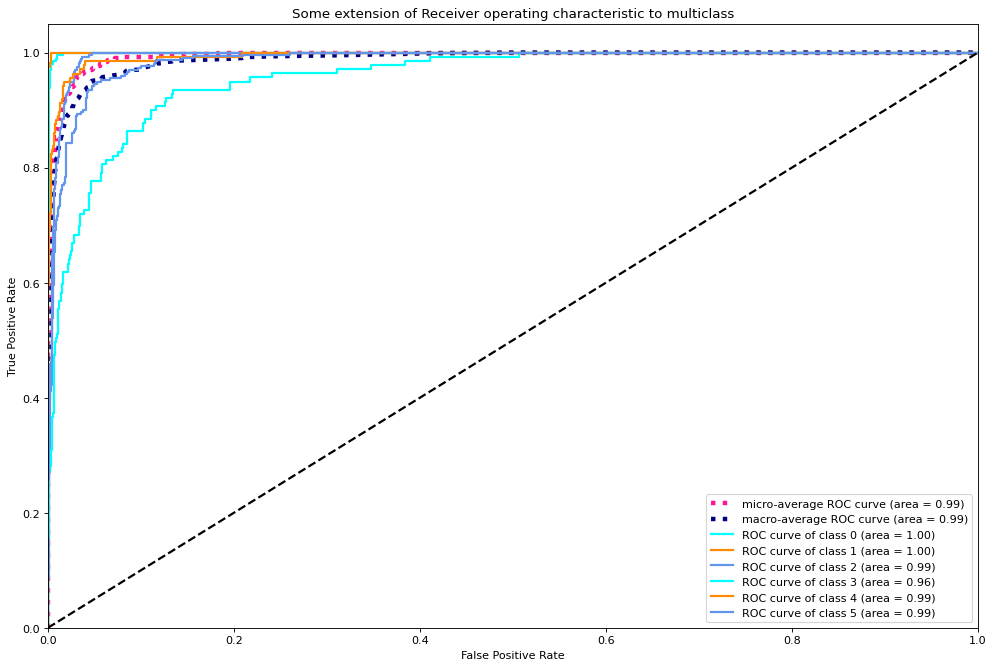

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       289
           1       0.99      0.97      0.98       160
           2       0.89      0.96      0.92       270
           3       0.82      0.57      0.67       139
           4       0.87      0.90      0.89       136
           5       0.85      0.91      0.88       292

    accuracy                           0.91      1286
   macro avg       0.90      0.88      0.89      1286
weighted avg       0.91      0.91      0.90      1286


Model name: Support Vector Machine, calibration algo: cvap


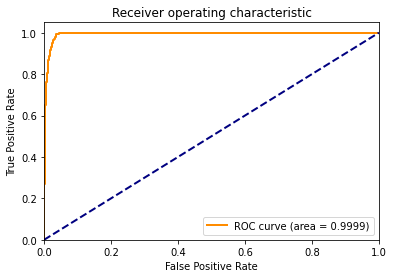

[[[ 992    5]
  [   4  285]]

 [[1123    3]
  [   3  157]]

 [[ 991   25]
  [  13  257]]

 [[1126   21]
  [  53   86]]

 [[1140   10]
  [  15  121]]

 [[ 950   44]
  [  20  272]]]


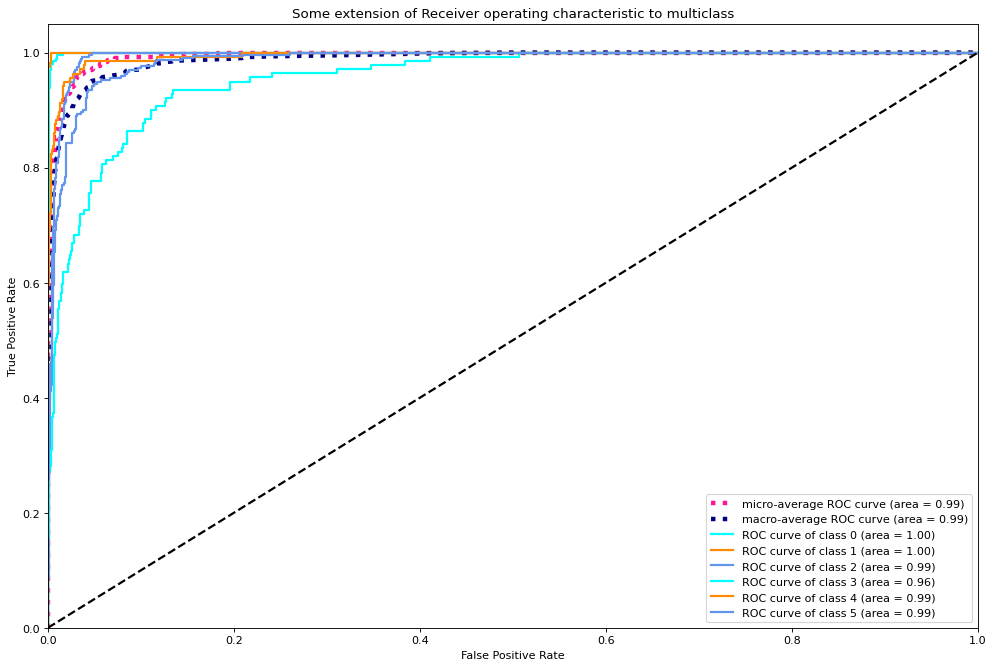

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       289
           1       0.98      0.98      0.98       160
           2       0.90      0.95      0.93       270
           3       0.79      0.60      0.68       139
           4       0.91      0.88      0.89       136
           5       0.85      0.93      0.89       292

    accuracy                           0.91      1286
   macro avg       0.90      0.88      0.89      1286
weighted avg       0.91      0.91      0.91      1286



In [70]:
clf_SVC = SVC(probability=True, random_state=42)


[y_pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_SVC, 
                    model_name = 'Support Vector Machine')

In [71]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   1.015793  0.165134  0.162719    0.163699   
KNN                           0.184904  0.080174  0.114040    0.074169   
Support Vector Machine        0.074044  0.079434  0.140253    0.079558   
logistic regression                NaN       NaN       NaN         NaN   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.140868  0.155458  0.152873  
KNN                        0.066965  0.269102  0.271722  
Support Vector Machine     0.078090  0.089106  0.090691  
logistic regression             NaN       NaN       NaN  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [72]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.061694  0.047837  0.043390    0.047269   
KNN                           0.021092  0.022677  0.022308    0.020846   
Support Vector Machine        0.021485  0.022648  0.023126    0.022211   
logistic regression                NaN       NaN       NaN         NaN   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.041502  0.044480  0.043124  
KNN                        0.019987  0.078450  0.078399  
Support Vector Machine     0.021815  0.023996  0.023693  
logistic regression             NaN       NaN       NaN  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

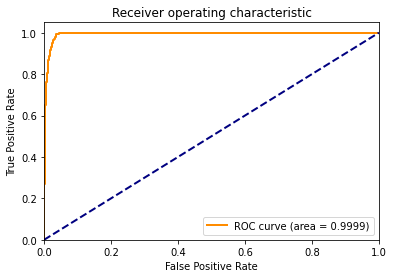

[[[ 992    5]
  [   4  285]]

 [[1123    3]
  [   3  157]]

 [[ 991   25]
  [  13  257]]

 [[1126   21]
  [  53   86]]

 [[1140   10]
  [  15  121]]

 [[ 950   44]
  [  20  272]]]


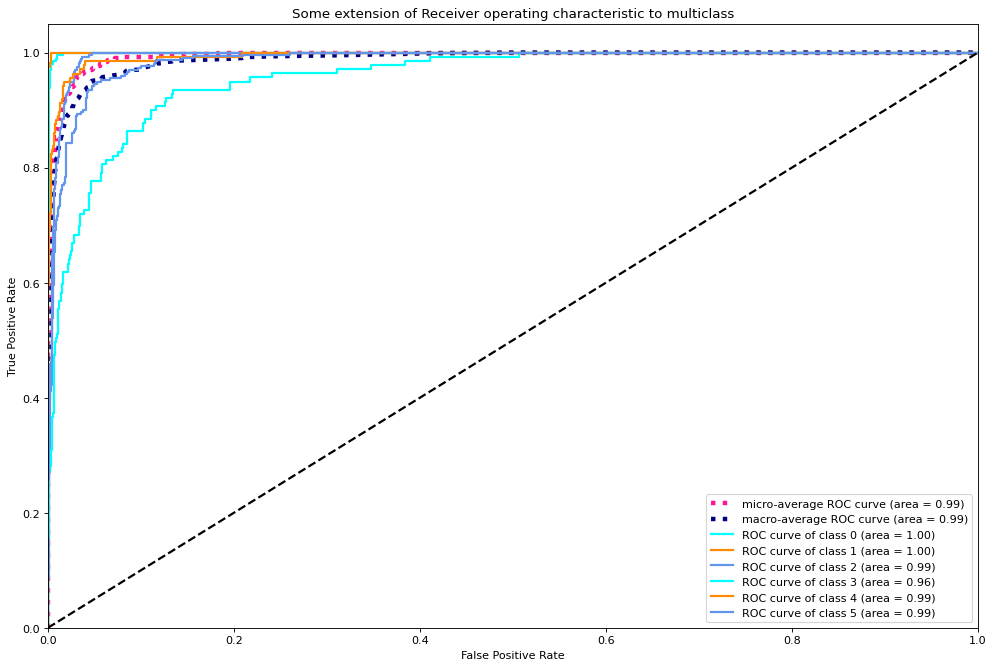

In [73]:
plot_roc_curve(y_test, y_pred_probs_list[0], y_pred_class_list[0], n_classes = n_classes)

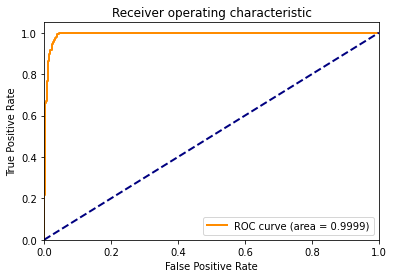

[[[ 990    7]
  [   5  284]]

 [[1124    2]
  [   3  157]]

 [[ 988   28]
  [  15  255]]

 [[1118   29]
  [  55   84]]

 [[1138   12]
  [  18  118]]

 [[ 950   44]
  [  26  266]]]


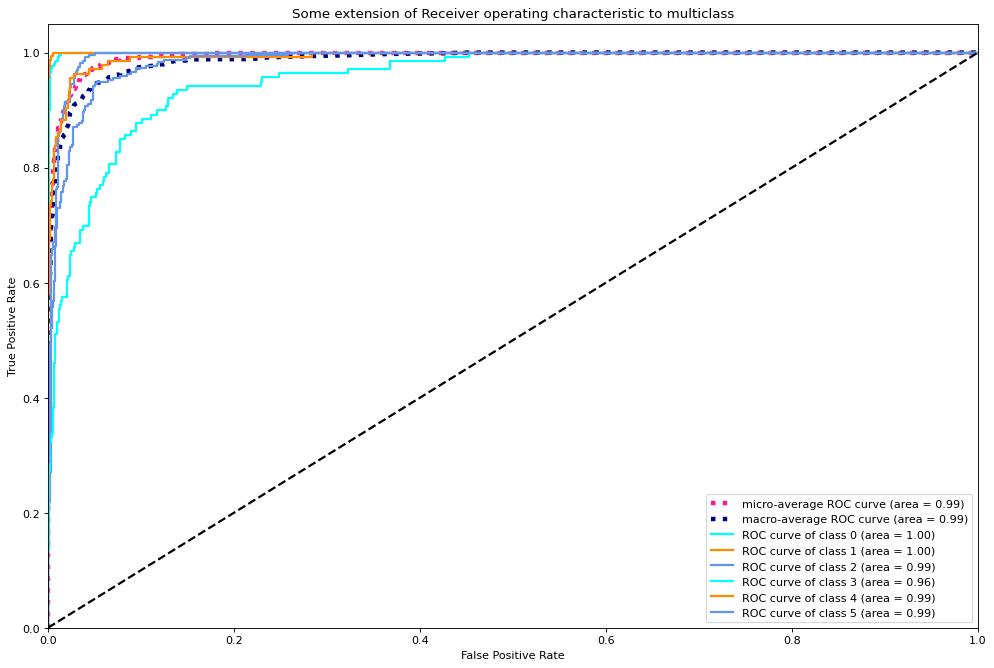

In [74]:
plot_roc_curve(y_test, y_pred_probs_list[1], y_pred_class_list[1], n_classes = n_classes)

### Logistic Regression


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:0
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 0, j:4
fitting model for i: 0, j:5
fitting model for i: 1, j:0
fitting model for i: 1, j:1
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 1, j:4
fitting model for i: 1, j:5
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:2
fitting model for i: 2, j:3
fitting model for i: 2, j:4
fitting model for i: 2, j:5
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2
fitting model for i: 3, j:3
fitting model for i: 3, j:4
fitting model for i: 3, j:5
fitting model for i: 4, j:0
fitting model for i: 4, j:1
fitting model for i: 4, j:2
fitting model for i: 4, j:3
fitting model for i: 4, j:4
fitting model for i: 4, j:5
fitting model for i: 5, j:0
fitting model for i: 5, j:1
fitting model for i: 5, j:2
fitting model for i: 5, j:3
fit

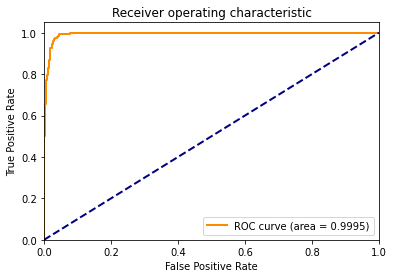

[[[ 986   11]
  [   5  284]]

 [[1122    4]
  [   9  151]]

 [[ 990   26]
  [  16  254]]

 [[1109   38]
  [  83   56]]

 [[1134   16]
  [  29  107]]

 [[ 923   71]
  [  24  268]]]


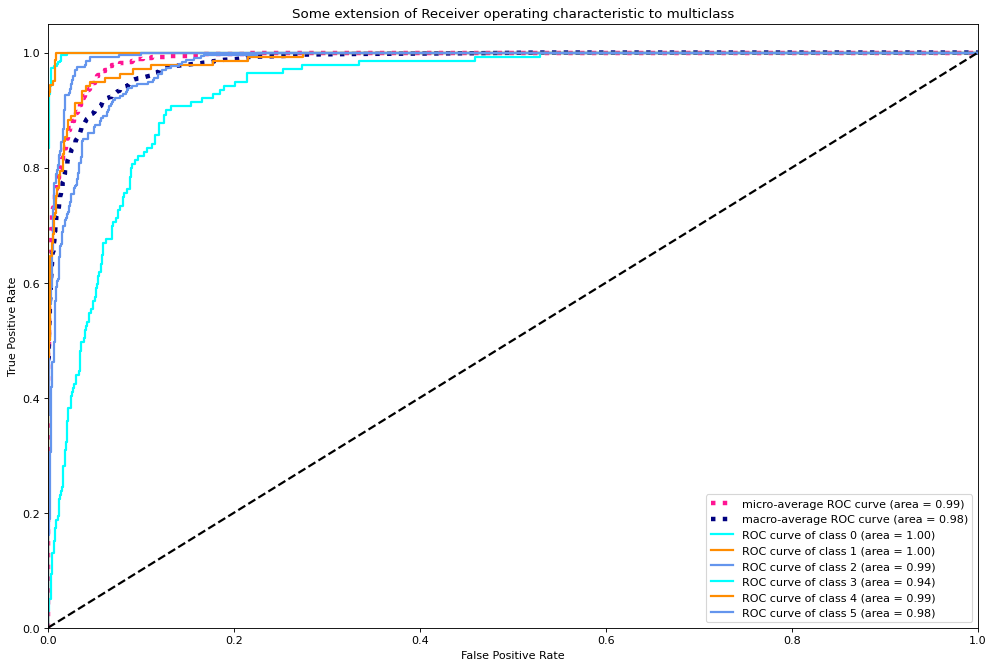

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       289
           1       0.97      0.94      0.96       160
           2       0.91      0.94      0.92       270
           3       0.60      0.40      0.48       139
           4       0.87      0.79      0.83       136
           5       0.79      0.92      0.85       292

    accuracy                           0.87      1286
   macro avg       0.85      0.83      0.84      1286
weighted avg       0.86      0.87      0.86      1286


Model name: logistic regression, calibration algo: sigmoid


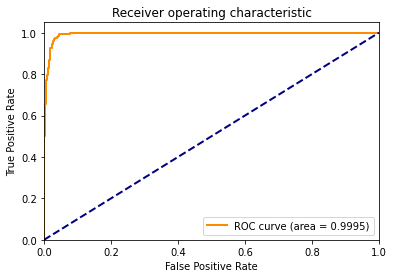

[[[ 986   11]
  [   5  284]]

 [[1122    4]
  [   9  151]]

 [[ 990   26]
  [  16  254]]

 [[1109   38]
  [  83   56]]

 [[1134   16]
  [  29  107]]

 [[ 923   71]
  [  24  268]]]


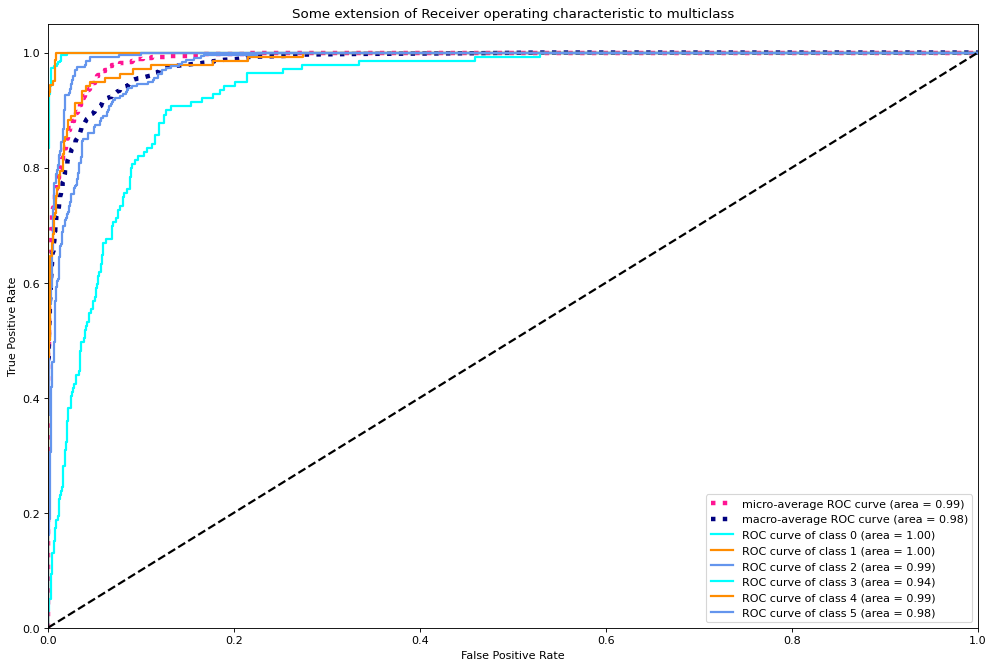

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       289
           1       0.99      0.93      0.96       160
           2       0.90      0.95      0.92       270
           3       0.59      0.37      0.45       139
           4       0.85      0.82      0.83       136
           5       0.78      0.91      0.84       292

    accuracy                           0.87      1286
   macro avg       0.85      0.83      0.83      1286
weighted avg       0.86      0.87      0.86      1286


Model name: logistic regression, calibration algo: isotonic


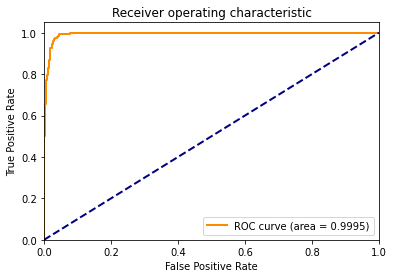

[[[ 986   11]
  [   5  284]]

 [[1122    4]
  [   9  151]]

 [[ 990   26]
  [  16  254]]

 [[1109   38]
  [  83   56]]

 [[1134   16]
  [  29  107]]

 [[ 923   71]
  [  24  268]]]


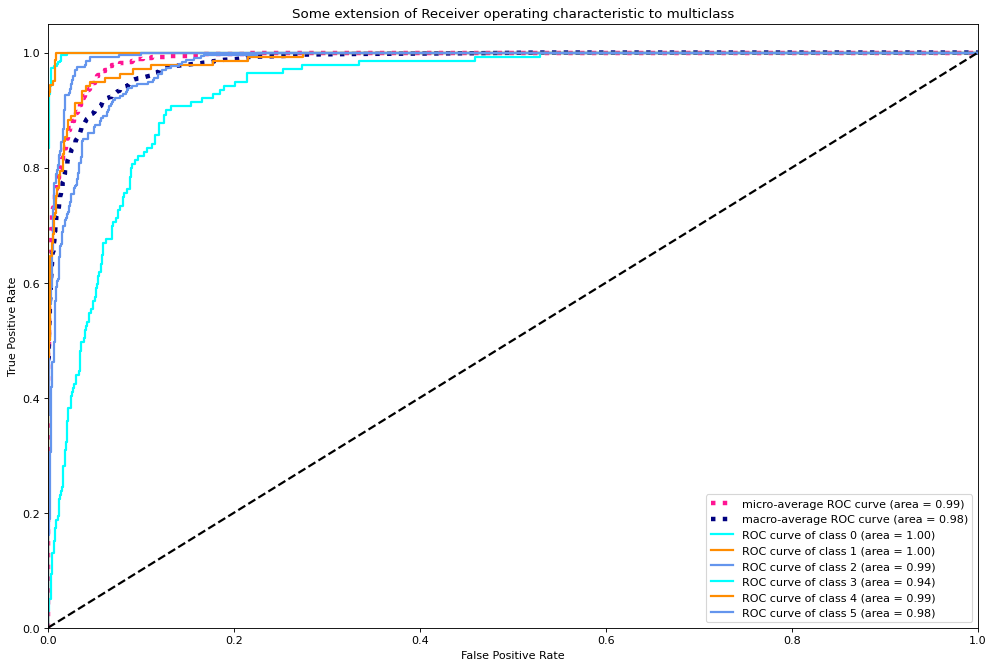

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       289
           1       0.98      0.94      0.96       160
           2       0.90      0.95      0.93       270
           3       0.62      0.58      0.60       139
           4       0.86      0.82      0.84       136
           5       0.85      0.85      0.85       292

    accuracy                           0.88      1286
   macro avg       0.86      0.85      0.86      1286
weighted avg       0.88      0.88      0.88      1286


Model name: logistic regression, calibration algo: sigmoid cv


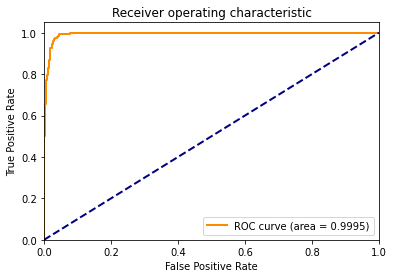

[[[ 986   11]
  [   5  284]]

 [[1122    4]
  [   9  151]]

 [[ 990   26]
  [  16  254]]

 [[1109   38]
  [  83   56]]

 [[1134   16]
  [  29  107]]

 [[ 923   71]
  [  24  268]]]


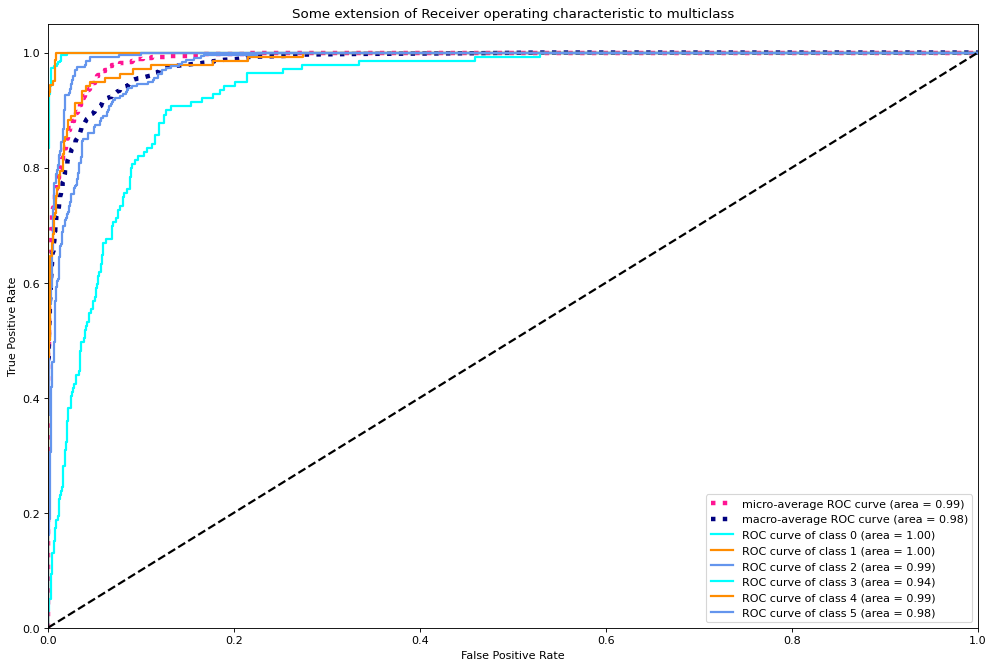

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       289
           1       0.99      0.94      0.96       160
           2       0.91      0.94      0.93       270
           3       0.60      0.40      0.48       139
           4       0.86      0.79      0.82       136
           5       0.78      0.92      0.85       292

    accuracy                           0.87      1286
   macro avg       0.85      0.83      0.83      1286
weighted avg       0.86      0.87      0.86      1286


Model name: logistic regression, calibration algo: isotonic cv


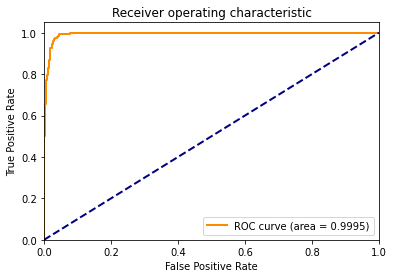

[[[ 986   11]
  [   5  284]]

 [[1122    4]
  [   9  151]]

 [[ 990   26]
  [  16  254]]

 [[1109   38]
  [  83   56]]

 [[1134   16]
  [  29  107]]

 [[ 923   71]
  [  24  268]]]


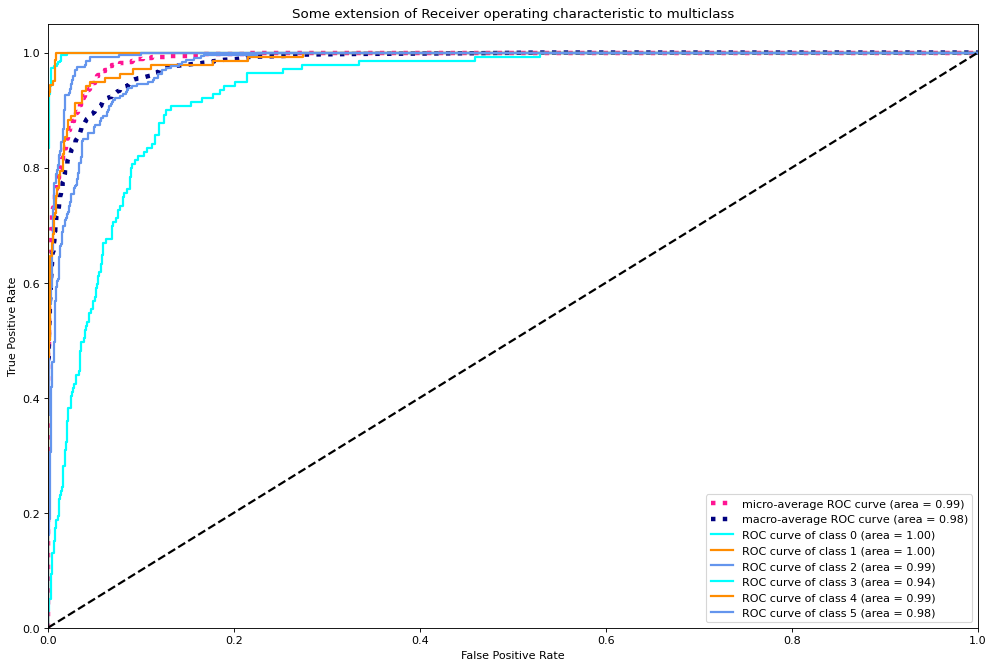

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       289
           1       0.97      0.96      0.96       160
           2       0.90      0.94      0.92       270
           3       0.62      0.56      0.59       139
           4       0.86      0.80      0.83       136
           5       0.85      0.87      0.86       292

    accuracy                           0.88      1286
   macro avg       0.86      0.85      0.86      1286
weighted avg       0.88      0.88      0.88      1286


Model name: logistic regression, calibration algo: ivap


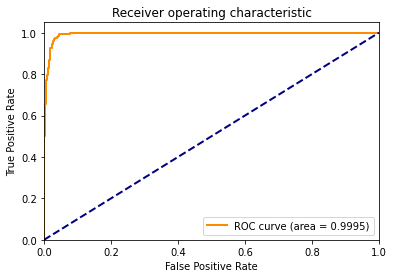

[[[ 986   11]
  [   5  284]]

 [[1122    4]
  [   9  151]]

 [[ 990   26]
  [  16  254]]

 [[1109   38]
  [  83   56]]

 [[1134   16]
  [  29  107]]

 [[ 923   71]
  [  24  268]]]


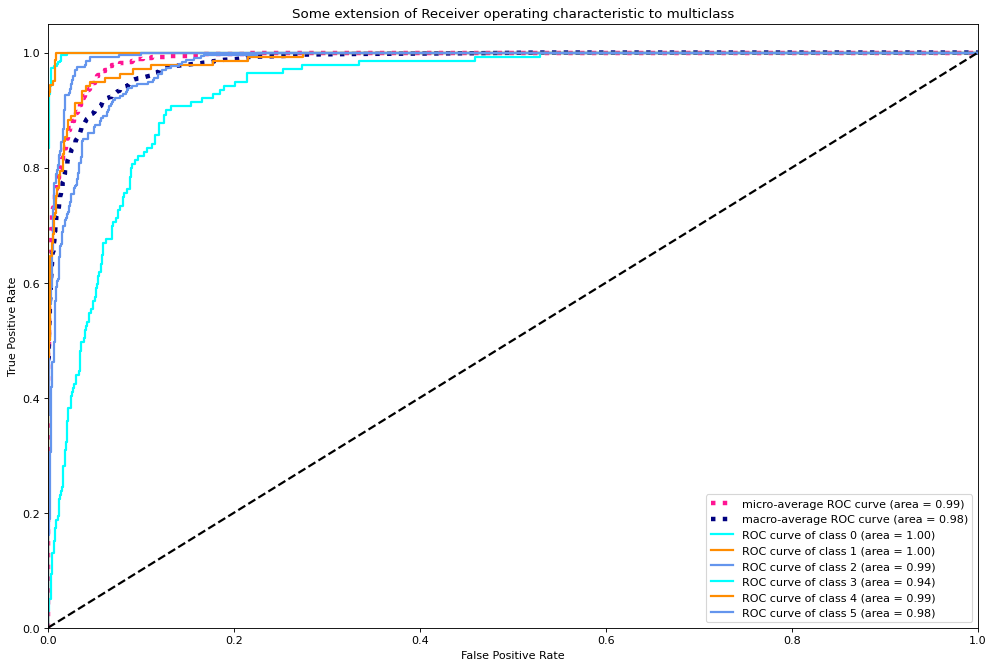

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       289
           1       0.99      0.94      0.96       160
           2       0.90      0.95      0.92       270
           3       0.62      0.60      0.61       139
           4       0.87      0.82      0.85       136
           5       0.86      0.86      0.86       292

    accuracy                           0.88      1286
   macro avg       0.87      0.86      0.86      1286
weighted avg       0.88      0.88      0.88      1286


Model name: logistic regression, calibration algo: cvap


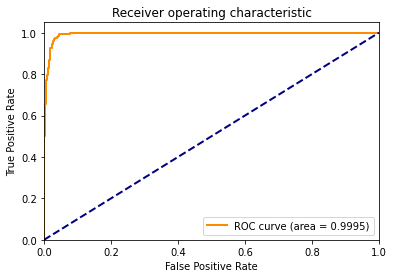

[[[ 986   11]
  [   5  284]]

 [[1122    4]
  [   9  151]]

 [[ 990   26]
  [  16  254]]

 [[1109   38]
  [  83   56]]

 [[1134   16]
  [  29  107]]

 [[ 923   71]
  [  24  268]]]


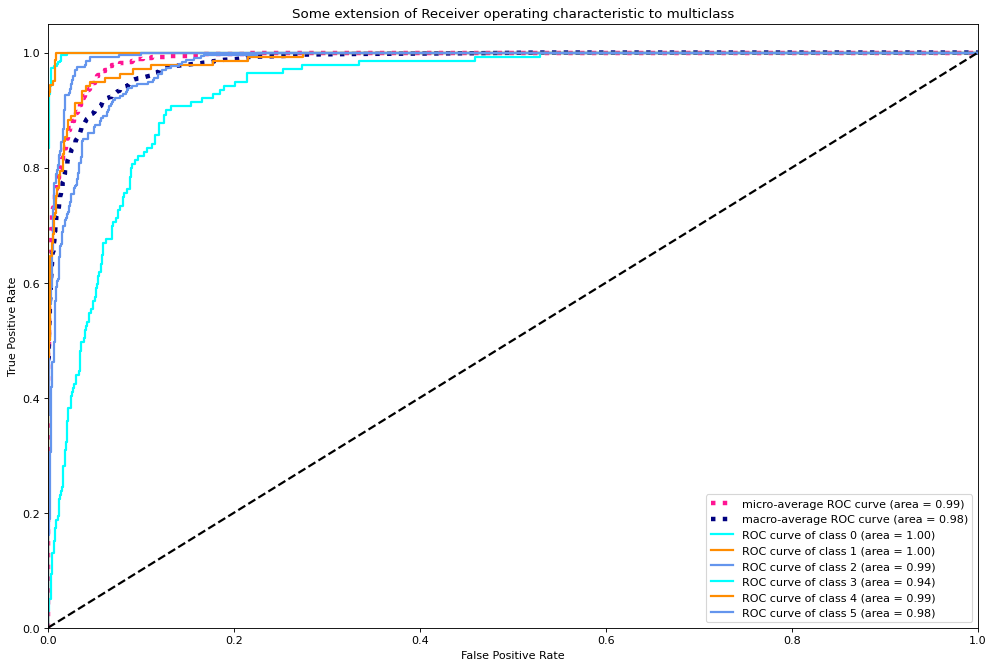

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       289
           1       0.98      0.94      0.96       160
           2       0.91      0.93      0.92       270
           3       0.61      0.55      0.58       139
           4       0.85      0.82      0.84       136
           5       0.84      0.88      0.86       292

    accuracy                           0.88      1286
   macro avg       0.86      0.85      0.86      1286
weighted avg       0.88      0.88      0.88      1286



In [75]:
# fit base model on the proper training dataset
clf_LR = LogisticRegression(solver = 'liblinear', random_state=42)

[y_pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_LR, 
                    model_name = 'logistic regression')

In [76]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   1.015793  0.165134  0.162719    0.163699   
KNN                           0.184904  0.080174  0.114040    0.074169   
Support Vector Machine        0.074044  0.079434  0.140253    0.079558   
logistic regression           0.094054  0.098962  0.140865    0.098415   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.140868  0.155458  0.152873  
KNN                        0.066965  0.269102  0.271722  
Support Vector Machine     0.078090  0.089106  0.090691  
logistic regression        0.096940  0.106434  0.104999  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [77]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.061694  0.047837  0.043390    0.047269   
KNN                           0.021092  0.022677  0.022308    0.020846   
Support Vector Machine        0.021485  0.022648  0.023126    0.022211   
logistic regression           0.029080  0.029961  0.029896    0.029692   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.041502  0.044480  0.043124  
KNN                        0.019987  0.078450  0.078399  
Support Vector Machine     0.021815  0.023996  0.023693  
logistic regression        0.028742  0.030332  0.029657  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

### Neural Network


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:0
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 0, j:4
fitting model for i: 0, j:5
fitting model for i: 1, j:0
fitting model for i: 1, j:1
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 1, j:4
fitting model for i: 1, j:5
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:2
fitting model for i: 2, j:3
fitting model for i: 2, j:4
fitting model for i: 2, j:5
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2
fitting model for i: 3, j:3
fitting model for i: 3, j:4
fitting model for i: 3, j:5
fitting model for i: 4, j:0
fitting model for i: 4, j:1
fitting model for i: 4, j:2
fitting model for i: 4, j:3
fitting model for i: 4, j:4
fitting model for i: 4, j:5
fitting model for i: 5, j:0
fitting model for i: 5, j:1
fitting model for i: 5, j:2
fitting model for i: 5, j:3
fit

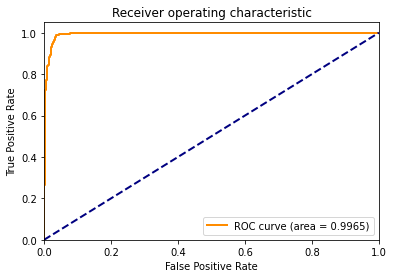

[[[ 993    4]
  [   4  285]]

 [[1124    2]
  [   4  156]]

 [[ 993   23]
  [  16  254]]

 [[1120   27]
  [  49   90]]

 [[1137   13]
  [  16  120]]

 [[ 951   43]
  [  23  269]]]


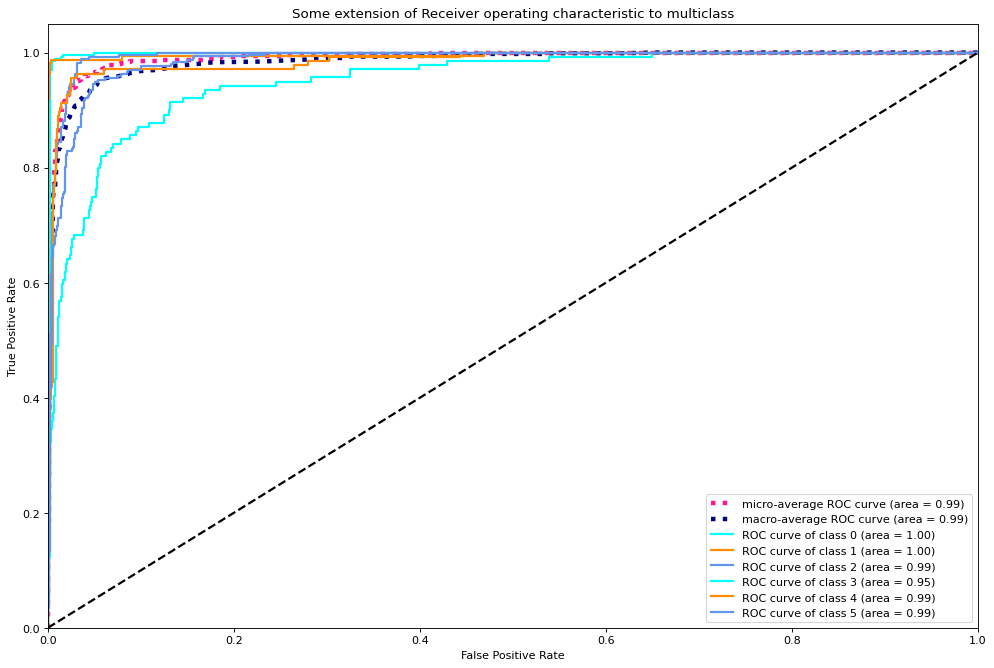

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       289
           1       0.99      0.97      0.98       160
           2       0.92      0.94      0.93       270
           3       0.77      0.65      0.70       139
           4       0.90      0.88      0.89       136
           5       0.86      0.92      0.89       292

    accuracy                           0.91      1286
   macro avg       0.90      0.89      0.90      1286
weighted avg       0.91      0.91      0.91      1286


Model name: neural network, calibration algo: sigmoid


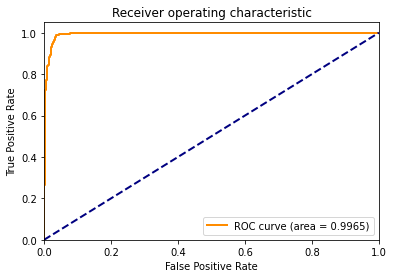

[[[ 993    4]
  [   4  285]]

 [[1124    2]
  [   4  156]]

 [[ 993   23]
  [  16  254]]

 [[1120   27]
  [  49   90]]

 [[1137   13]
  [  16  120]]

 [[ 951   43]
  [  23  269]]]


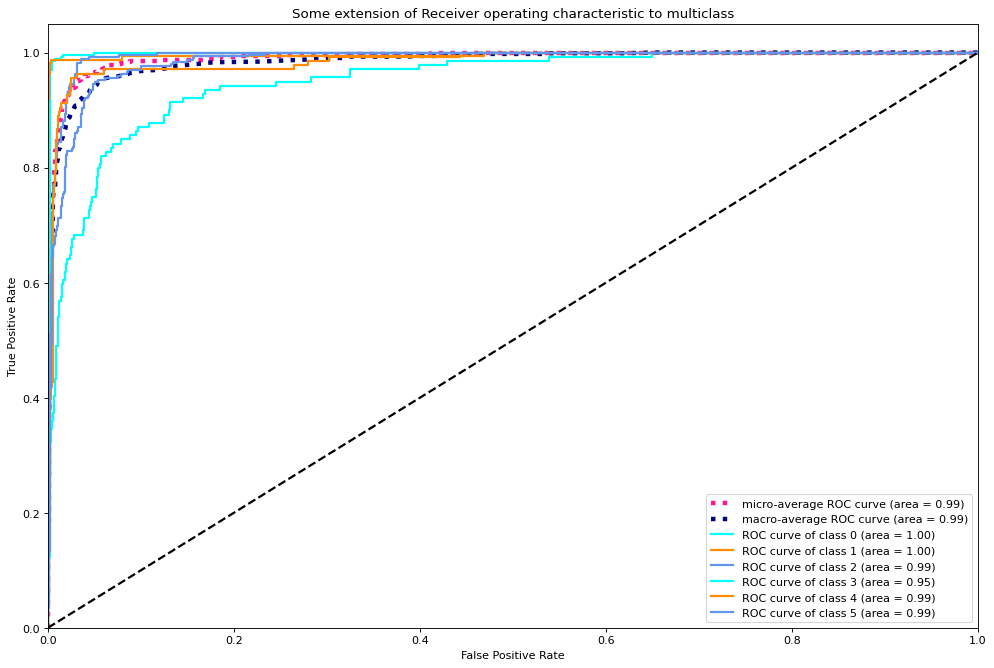

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       289
           1       0.97      0.96      0.96       160
           2       0.92      0.94      0.93       270
           3       0.77      0.60      0.67       139
           4       0.91      0.87      0.89       136
           5       0.84      0.93      0.88       292

    accuracy                           0.91      1286
   macro avg       0.90      0.88      0.89      1286
weighted avg       0.91      0.91      0.90      1286


Model name: neural network, calibration algo: isotonic


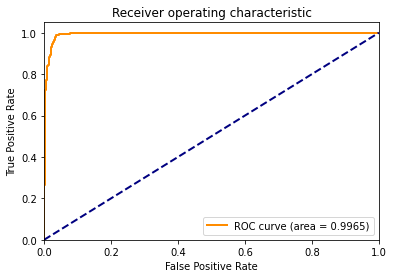

[[[ 993    4]
  [   4  285]]

 [[1124    2]
  [   4  156]]

 [[ 993   23]
  [  16  254]]

 [[1120   27]
  [  49   90]]

 [[1137   13]
  [  16  120]]

 [[ 951   43]
  [  23  269]]]


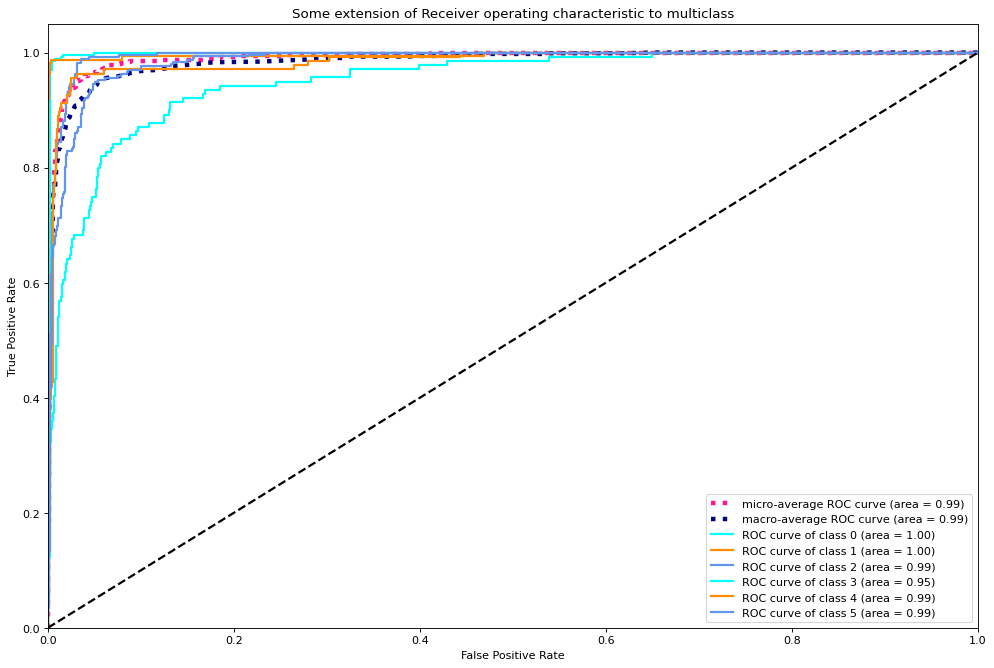

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       289
           1       0.99      0.95      0.97       160
           2       0.90      0.95      0.92       270
           3       0.75      0.58      0.65       139
           4       0.86      0.89      0.88       136
           5       0.85      0.90      0.87       292

    accuracy                           0.90      1286
   macro avg       0.89      0.88      0.88      1286
weighted avg       0.90      0.90      0.90      1286


Model name: neural network, calibration algo: sigmoid cv


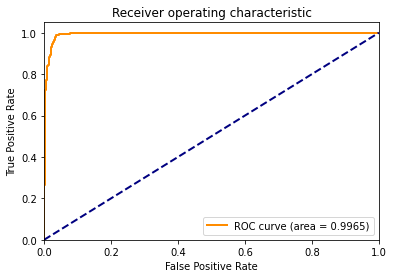

[[[ 993    4]
  [   4  285]]

 [[1124    2]
  [   4  156]]

 [[ 993   23]
  [  16  254]]

 [[1120   27]
  [  49   90]]

 [[1137   13]
  [  16  120]]

 [[ 951   43]
  [  23  269]]]


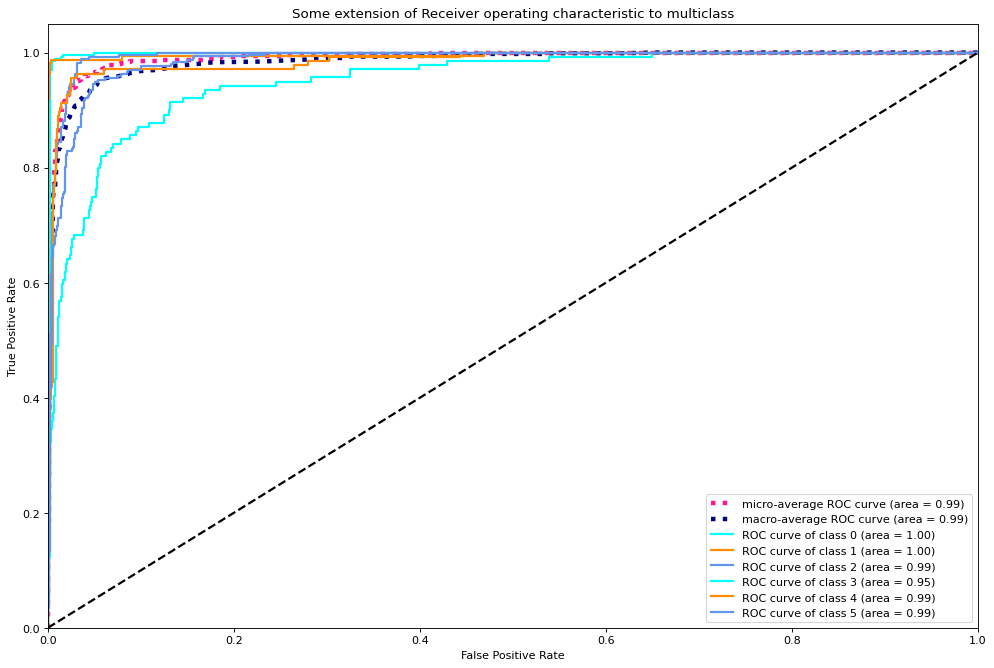

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       289
           1       0.99      0.97      0.98       160
           2       0.91      0.96      0.93       270
           3       0.84      0.56      0.67       139
           4       0.92      0.88      0.89       136
           5       0.84      0.94      0.89       292

    accuracy                           0.91      1286
   macro avg       0.91      0.88      0.89      1286
weighted avg       0.91      0.91      0.91      1286


Model name: neural network, calibration algo: isotonic cv


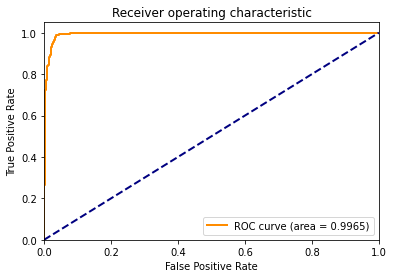

[[[ 993    4]
  [   4  285]]

 [[1124    2]
  [   4  156]]

 [[ 993   23]
  [  16  254]]

 [[1120   27]
  [  49   90]]

 [[1137   13]
  [  16  120]]

 [[ 951   43]
  [  23  269]]]


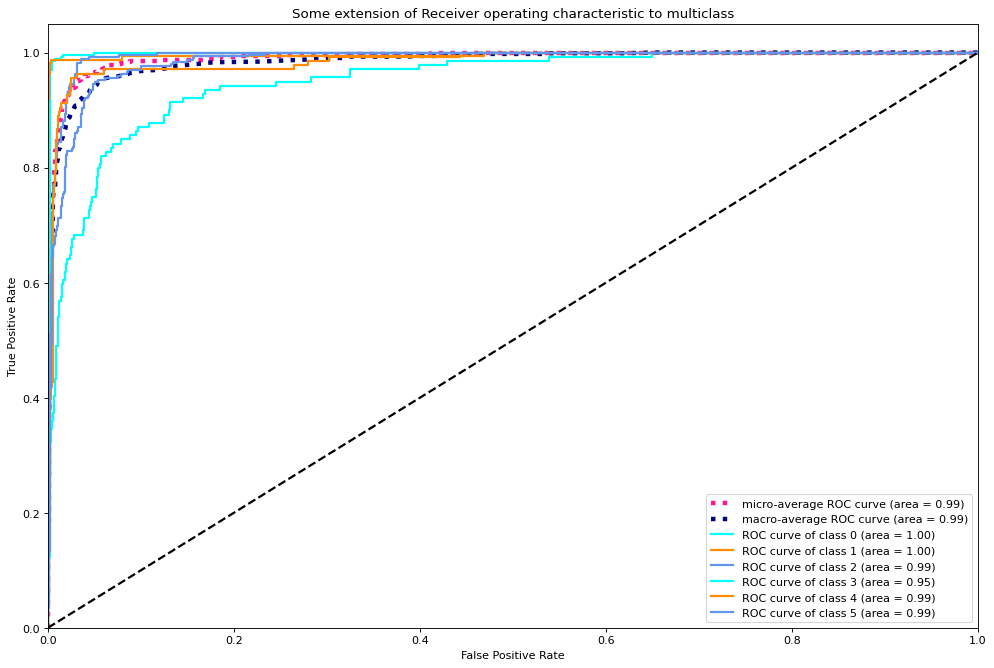

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       289
           1       0.99      0.97      0.98       160
           2       0.90      0.97      0.93       270
           3       0.83      0.59      0.69       139
           4       0.89      0.88      0.89       136
           5       0.85      0.91      0.88       292

    accuracy                           0.91      1286
   macro avg       0.91      0.89      0.89      1286
weighted avg       0.91      0.91      0.91      1286


Model name: neural network, calibration algo: ivap


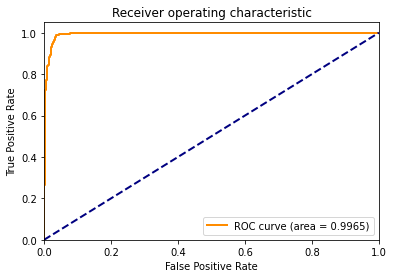

[[[ 993    4]
  [   4  285]]

 [[1124    2]
  [   4  156]]

 [[ 993   23]
  [  16  254]]

 [[1120   27]
  [  49   90]]

 [[1137   13]
  [  16  120]]

 [[ 951   43]
  [  23  269]]]


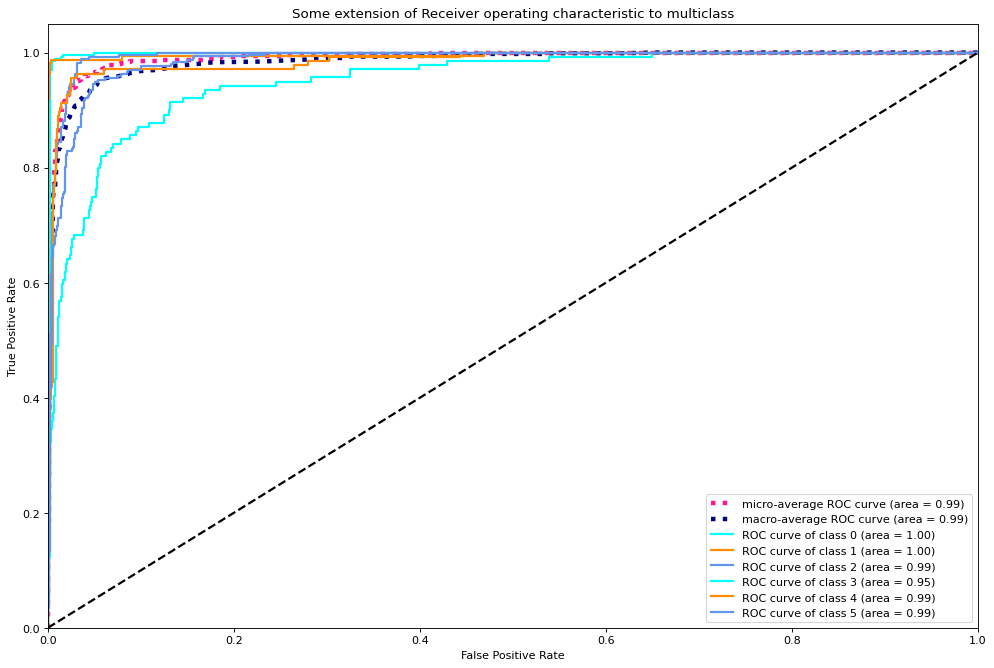

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       289
           1       0.97      0.95      0.96       160
           2       0.90      0.96      0.93       270
           3       0.75      0.62      0.68       139
           4       0.89      0.89      0.89       136
           5       0.87      0.90      0.89       292

    accuracy                           0.91      1286
   macro avg       0.90      0.88      0.89      1286
weighted avg       0.91      0.91      0.91      1286


Model name: neural network, calibration algo: cvap


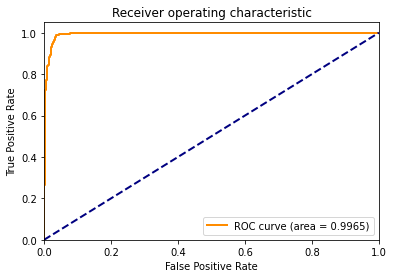

[[[ 993    4]
  [   4  285]]

 [[1124    2]
  [   4  156]]

 [[ 993   23]
  [  16  254]]

 [[1120   27]
  [  49   90]]

 [[1137   13]
  [  16  120]]

 [[ 951   43]
  [  23  269]]]


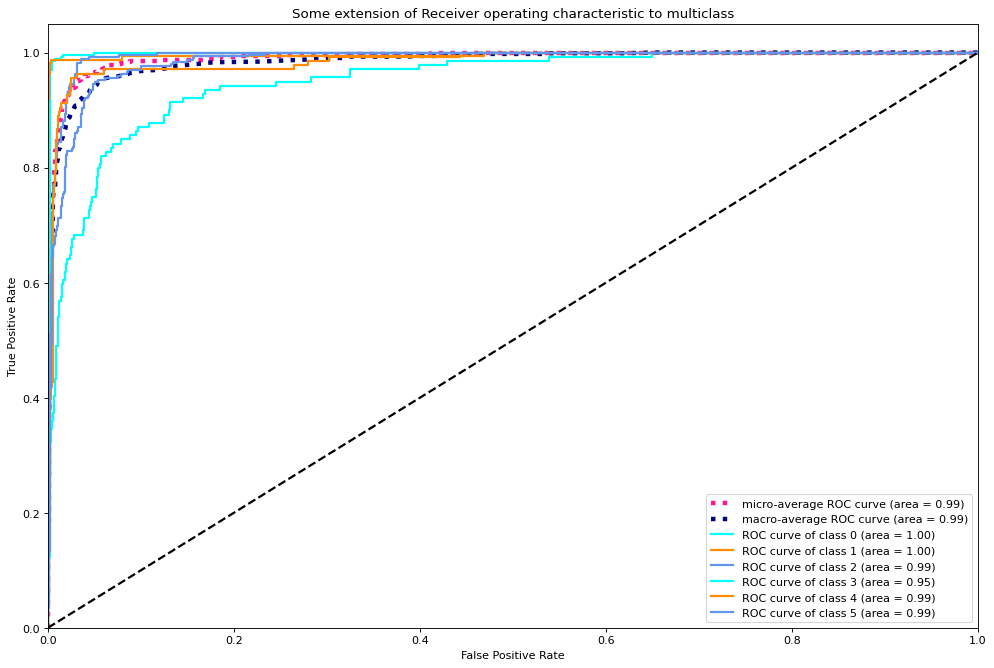

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       289
           1       0.99      0.97      0.98       160
           2       0.89      0.97      0.93       270
           3       0.78      0.60      0.68       139
           4       0.90      0.90      0.90       136
           5       0.87      0.90      0.88       292

    accuracy                           0.91      1286
   macro avg       0.90      0.89      0.89      1286
weighted avg       0.91      0.91      0.91      1286



In [78]:
# fit base model on the proper training dataset
clf_MLP = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)

[y_pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_MLP, 
                    model_name = 'neural network')

In [79]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   1.015793  0.165134  0.162719    0.163699   
KNN                           0.184904  0.080174  0.114040    0.074169   
Support Vector Machine        0.074044  0.079434  0.140253    0.079558   
logistic regression           0.094054  0.098962  0.140865    0.098415   
neural network                0.103468  0.092251  0.113879    0.083388   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.140868  0.155458  0.152873  
KNN                        0.066965  0.269102  0.271722  
Support Vector Machine     0.078090  0.089106  0.090691  
logistic regression        0.096940  0.106434  0.104999  
neural network             0.072697  0.180124  0.176570  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [80]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.061694  0.047837  0.043390    0.047269   
KNN                           0.021092  0.022677  0.022308    0.020846   
Support Vector Machine        0.021485  0.022648  0.023126    0.022211   
logistic regression           0.029080  0.029961  0.029896    0.029692   
neural network                0.023303  0.024415  0.023185    0.021816   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.041502  0.044480  0.043124  
KNN                        0.019987  0.078450  0.078399  
Support Vector Machine     0.021815  0.023996  0.023693  
logistic regression        0.028742  0.030332  0.029657  
neural network             0.020917  0.046434  0.044640  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

### Random Forest


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:0
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 0, j:4
fitting model for i: 0, j:5
fitting model for i: 1, j:0
fitting model for i: 1, j:1
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 1, j:4
fitting model for i: 1, j:5
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:2
fitting model for i: 2, j:3
fitting model for i: 2, j:4
fitting model for i: 2, j:5
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2
fitting model for i: 3, j:3
fitting model for i: 3, j:4
fitting model for i: 3, j:5
fitting model for i: 4, j:0
fitting model for i: 4, j:1
fitting model for i: 4, j:2
fitting model for i: 4, j:3
fitting model for i: 4, j:4
fitting model for i: 4, j:5
fitting model for i: 5, j:0
fitting model for i: 5, j:1
fitting model for i: 5, j:2
fitting model for i: 5, j:3
fit

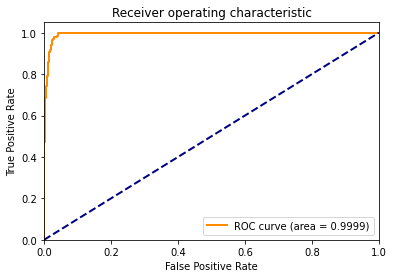

[[[ 989    8]
  [   7  282]]

 [[1123    3]
  [   2  158]]

 [[ 988   28]
  [  10  260]]

 [[1127   20]
  [  50   89]]

 [[1138   12]
  [  16  120]]

 [[ 960   34]
  [  20  272]]]


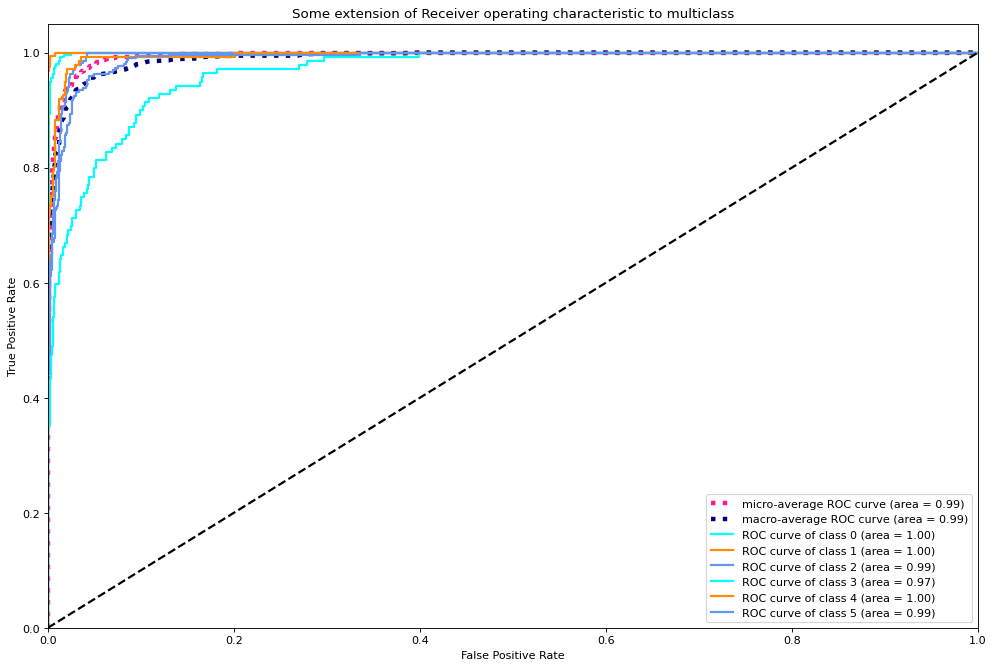

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       289
           1       0.98      0.99      0.98       160
           2       0.90      0.96      0.93       270
           3       0.82      0.64      0.72       139
           4       0.91      0.88      0.90       136
           5       0.89      0.93      0.91       292

    accuracy                           0.92      1286
   macro avg       0.91      0.90      0.90      1286
weighted avg       0.92      0.92      0.92      1286


Model name: Random Forest, calibration algo: sigmoid


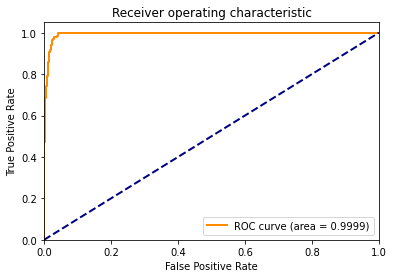

[[[ 989    8]
  [   7  282]]

 [[1123    3]
  [   2  158]]

 [[ 988   28]
  [  10  260]]

 [[1127   20]
  [  50   89]]

 [[1138   12]
  [  16  120]]

 [[ 960   34]
  [  20  272]]]


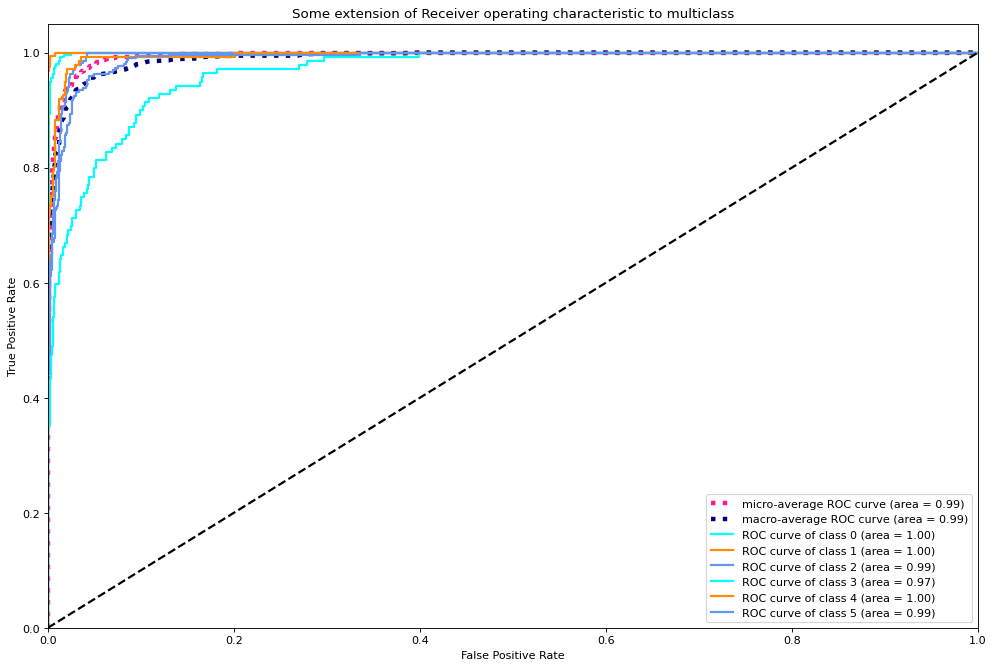

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       289
           1       0.99      0.98      0.98       160
           2       0.90      0.95      0.93       270
           3       0.81      0.59      0.68       139
           4       0.89      0.88      0.89       136
           5       0.86      0.94      0.90       292

    accuracy                           0.91      1286
   macro avg       0.90      0.89      0.89      1286
weighted avg       0.91      0.91      0.91      1286


Model name: Random Forest, calibration algo: isotonic


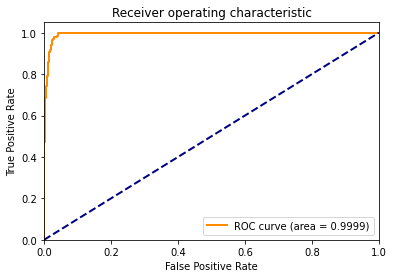

[[[ 989    8]
  [   7  282]]

 [[1123    3]
  [   2  158]]

 [[ 988   28]
  [  10  260]]

 [[1127   20]
  [  50   89]]

 [[1138   12]
  [  16  120]]

 [[ 960   34]
  [  20  272]]]


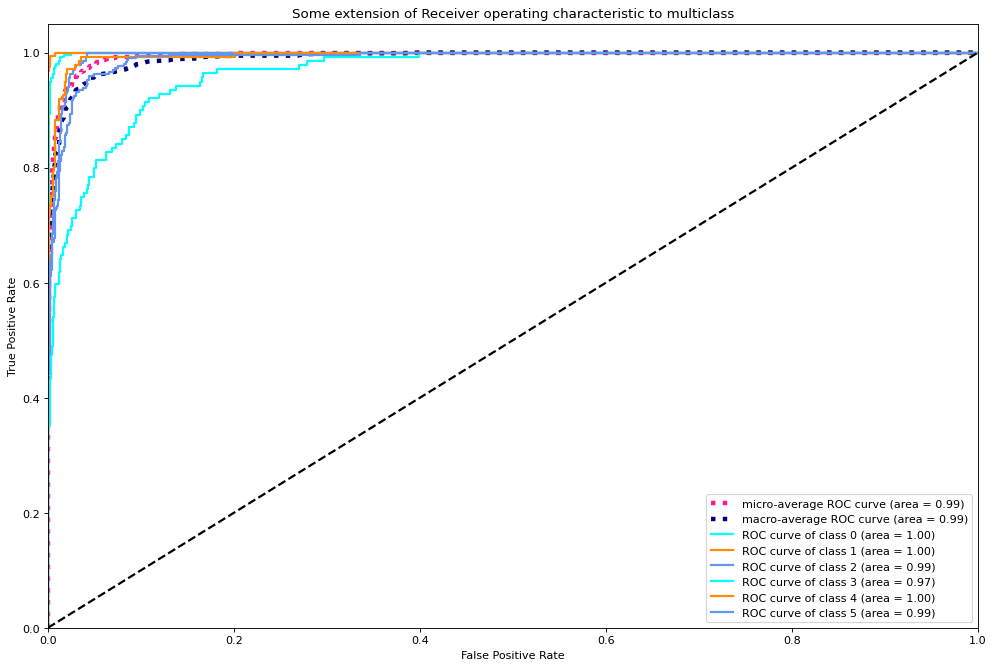

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       289
           1       0.99      0.96      0.97       160
           2       0.89      0.96      0.92       270
           3       0.81      0.59      0.68       139
           4       0.87      0.87      0.87       136
           5       0.85      0.93      0.89       292

    accuracy                           0.91      1286
   macro avg       0.90      0.88      0.89      1286
weighted avg       0.91      0.91      0.90      1286


Model name: Random Forest, calibration algo: sigmoid cv


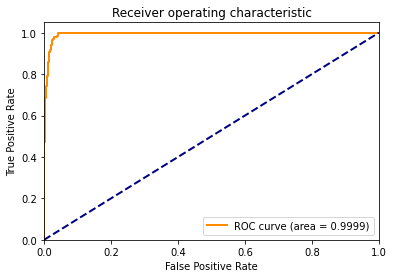

[[[ 989    8]
  [   7  282]]

 [[1123    3]
  [   2  158]]

 [[ 988   28]
  [  10  260]]

 [[1127   20]
  [  50   89]]

 [[1138   12]
  [  16  120]]

 [[ 960   34]
  [  20  272]]]


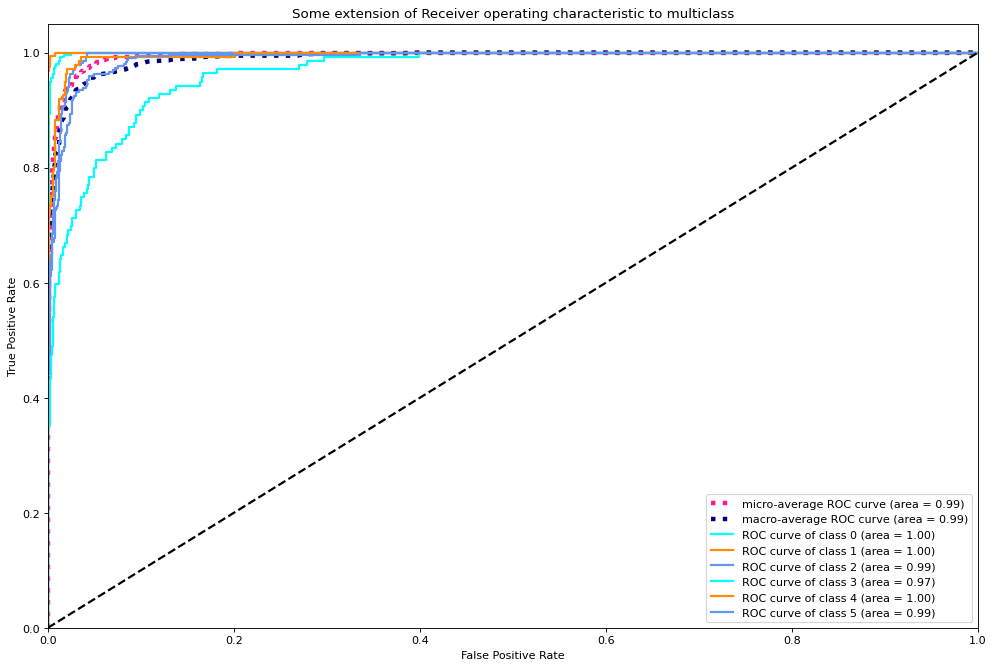

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       289
           1       0.98      0.99      0.98       160
           2       0.92      0.96      0.94       270
           3       0.80      0.62      0.70       139
           4       0.91      0.88      0.89       136
           5       0.87      0.93      0.90       292

    accuracy                           0.92      1286
   macro avg       0.91      0.89      0.90      1286
weighted avg       0.91      0.92      0.91      1286


Model name: Random Forest, calibration algo: isotonic cv


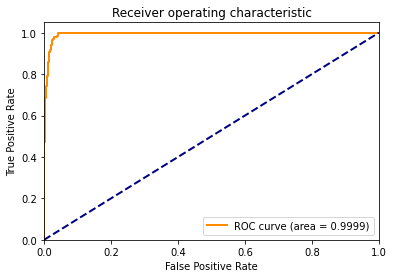

[[[ 989    8]
  [   7  282]]

 [[1123    3]
  [   2  158]]

 [[ 988   28]
  [  10  260]]

 [[1127   20]
  [  50   89]]

 [[1138   12]
  [  16  120]]

 [[ 960   34]
  [  20  272]]]


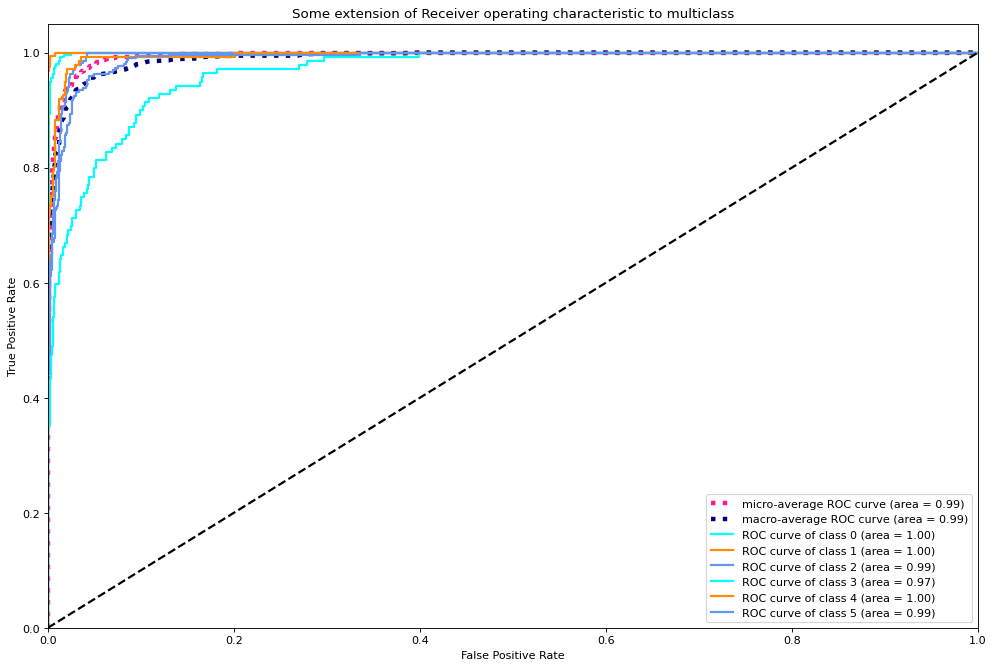

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       289
           1       0.98      0.99      0.99       160
           2       0.91      0.96      0.94       270
           3       0.80      0.62      0.70       139
           4       0.92      0.88      0.90       136
           5       0.88      0.93      0.90       292

    accuracy                           0.92      1286
   macro avg       0.91      0.89      0.90      1286
weighted avg       0.92      0.92      0.91      1286


Model name: Random Forest, calibration algo: ivap


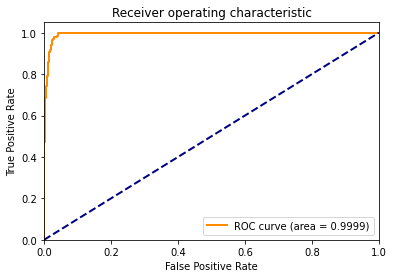

[[[ 989    8]
  [   7  282]]

 [[1123    3]
  [   2  158]]

 [[ 988   28]
  [  10  260]]

 [[1127   20]
  [  50   89]]

 [[1138   12]
  [  16  120]]

 [[ 960   34]
  [  20  272]]]


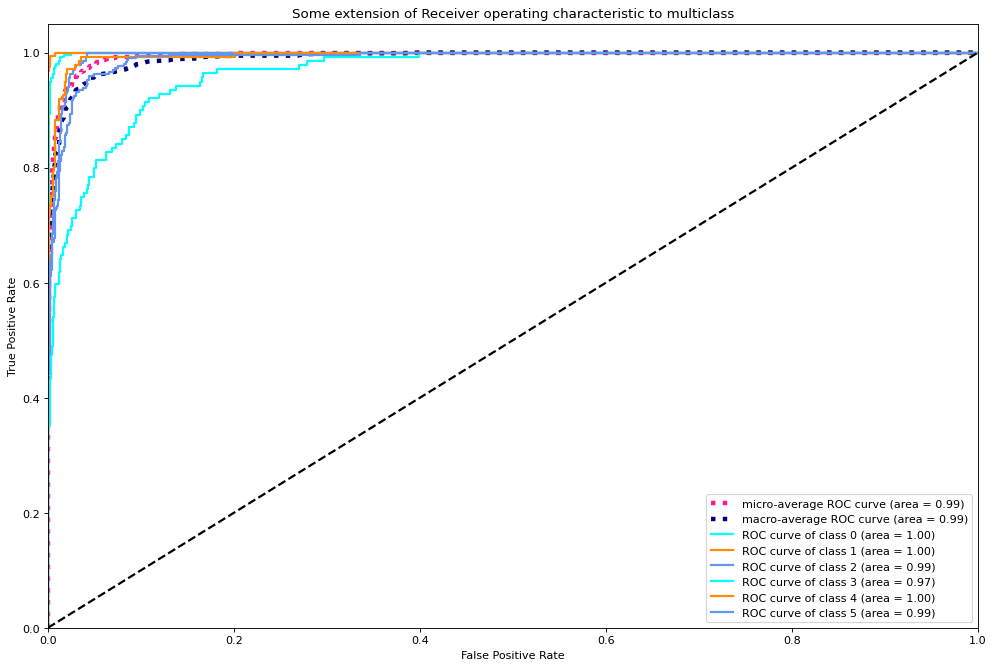

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       289
           1       0.99      0.96      0.97       160
           2       0.90      0.96      0.93       270
           3       0.82      0.59      0.69       139
           4       0.88      0.88      0.88       136
           5       0.85      0.94      0.90       292

    accuracy                           0.91      1286
   macro avg       0.90      0.88      0.89      1286
weighted avg       0.91      0.91      0.91      1286


Model name: Random Forest, calibration algo: cvap


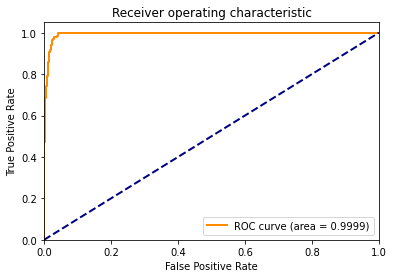

[[[ 989    8]
  [   7  282]]

 [[1123    3]
  [   2  158]]

 [[ 988   28]
  [  10  260]]

 [[1127   20]
  [  50   89]]

 [[1138   12]
  [  16  120]]

 [[ 960   34]
  [  20  272]]]


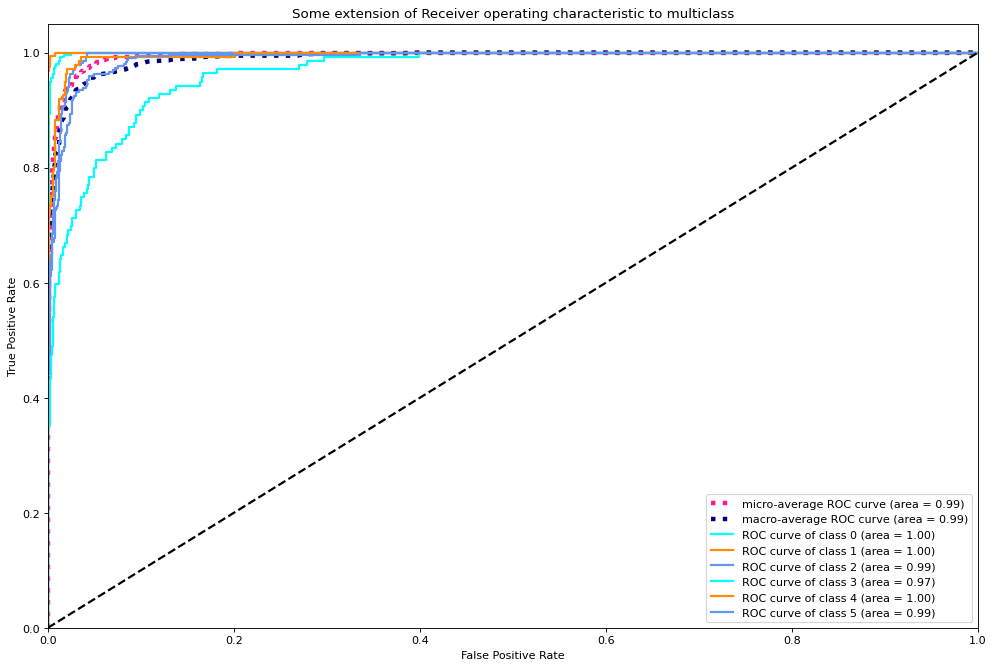

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       289
           1       0.99      0.98      0.98       160
           2       0.91      0.97      0.94       270
           3       0.84      0.63      0.72       139
           4       0.89      0.90      0.90       136
           5       0.88      0.94      0.91       292

    accuracy                           0.92      1286
   macro avg       0.91      0.90      0.90      1286
weighted avg       0.92      0.92      0.92      1286



In [81]:
clf_RF = RandomForestClassifier(random_state=42, n_jobs = -1)

[pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_RF, 
                    model_name = 'Random Forest')

In [82]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   1.015793  0.165134  0.162719    0.163699   
KNN                           0.184904  0.080174  0.114040    0.074169   
Support Vector Machine        0.074044  0.079434  0.140253    0.079558   
logistic regression           0.094054  0.098962  0.140865    0.098415   
neural network                0.103468  0.092251  0.113879    0.083388   
Random Forest                 0.074795  0.076784  0.133131    0.072907   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.140868  0.155458  0.152873  
KNN                        0.066965  0.269102  0.271722  
Support Vector Machine     0.078090  0.089106  0.090691  
logistic regression        0.096940  0.106434  0.104999  
neural network             0.072697  0.180124  0.176570  
Random Forest              0.070622  0.094740  0.094769  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [83]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.061694  0.047837  0.043390    0.047269   
KNN                           0.021092  0.022677  0.022308    0.020846   
Support Vector Machine        0.021485  0.022648  0.023126    0.022211   
logistic regression           0.029080  0.029961  0.029896    0.029692   
neural network                0.023303  0.024415  0.023185    0.021816   
Random Forest                 0.021345  0.021780  0.022606    0.020135   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.041502  0.044480  0.043124  
KNN                        0.019987  0.078450  0.078399  
Support Vector Machine     0.021815  0.023996  0.023693  
logistic regression        0.028742  0.030332  0.029657  
neural network             0.020917  0.046434  0.044640  
Random Forest              0.020072  0.023760  0.022836  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

### LightGBM 


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:0
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 0, j:4
fitting model for i: 0, j:5
fitting model for i: 1, j:0
fitting model for i: 1, j:1
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 1, j:4
fitting model for i: 1, j:5
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:2
fitting model for i: 2, j:3
fitting model for i: 2, j:4
fitting model for i: 2, j:5
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2
fitting model for i: 3, j:3
fitting model for i: 3, j:4
fitting model for i: 3, j:5
fitting model for i: 4, j:0
fitting model for i: 4, j:1
fitting model for i: 4, j:2
fitting model for i: 4, j:3
fitting model for i: 4, j:4
fitting model for i: 4, j:5
fitting model for i: 5, j:0
fitting model for i: 5, j:1
fitting model for i: 5, j:2
fitting model for i: 5, j:3
fit

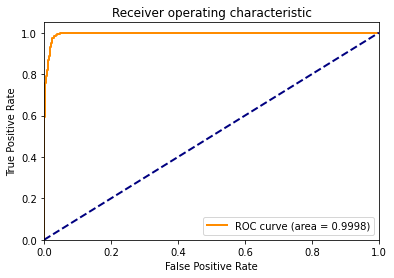

[[[ 994    3]
  [   3  286]]

 [[1124    2]
  [   3  157]]

 [[ 991   25]
  [  10  260]]

 [[1125   22]
  [  45   94]]

 [[1139   11]
  [  11  125]]

 [[ 964   30]
  [  21  271]]]


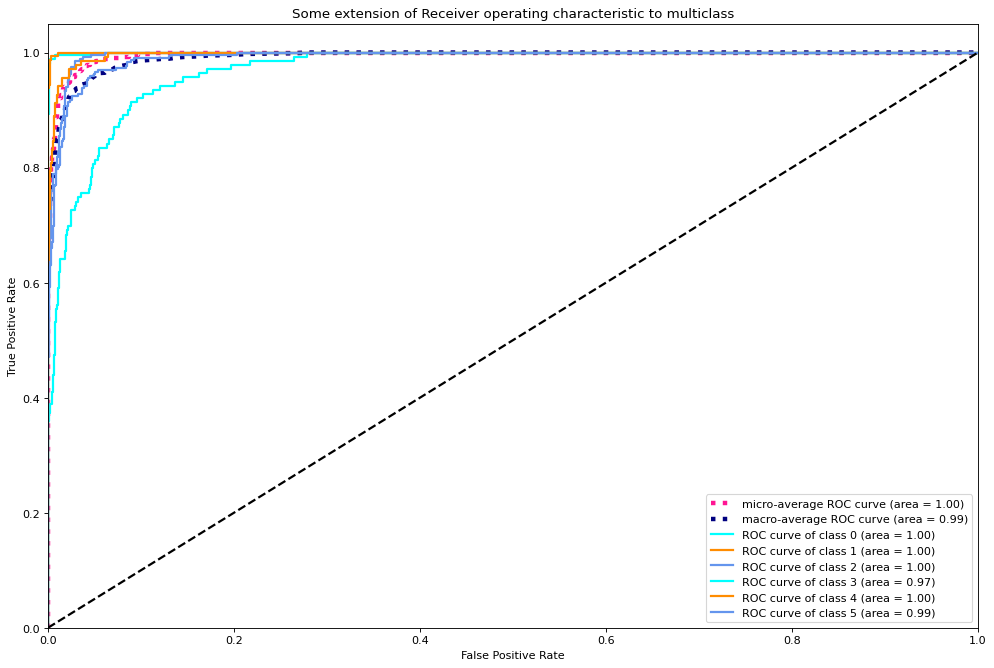

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       289
           1       0.99      0.98      0.98       160
           2       0.91      0.96      0.94       270
           3       0.81      0.68      0.74       139
           4       0.92      0.92      0.92       136
           5       0.90      0.93      0.91       292

    accuracy                           0.93      1286
   macro avg       0.92      0.91      0.91      1286
weighted avg       0.93      0.93      0.93      1286


Model name: LightGBM, calibration algo: sigmoid


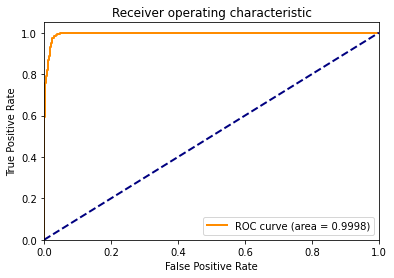

[[[ 994    3]
  [   3  286]]

 [[1124    2]
  [   3  157]]

 [[ 991   25]
  [  10  260]]

 [[1125   22]
  [  45   94]]

 [[1139   11]
  [  11  125]]

 [[ 964   30]
  [  21  271]]]


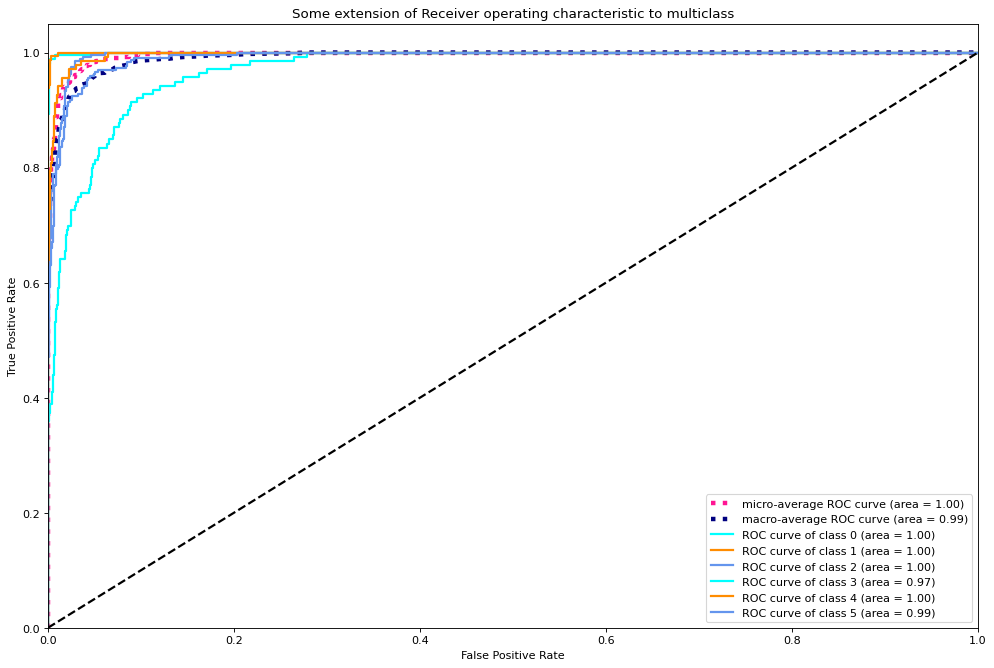

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       289
           1       0.99      0.97      0.98       160
           2       0.91      0.96      0.93       270
           3       0.82      0.64      0.72       139
           4       0.90      0.90      0.90       136
           5       0.88      0.93      0.91       292

    accuracy                           0.92      1286
   macro avg       0.91      0.90      0.90      1286
weighted avg       0.92      0.92      0.92      1286


Model name: LightGBM, calibration algo: isotonic


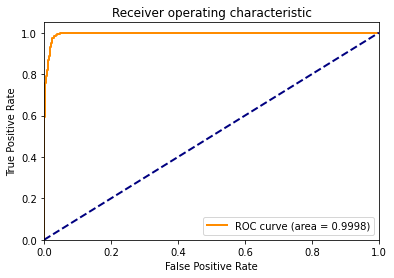

[[[ 994    3]
  [   3  286]]

 [[1124    2]
  [   3  157]]

 [[ 991   25]
  [  10  260]]

 [[1125   22]
  [  45   94]]

 [[1139   11]
  [  11  125]]

 [[ 964   30]
  [  21  271]]]


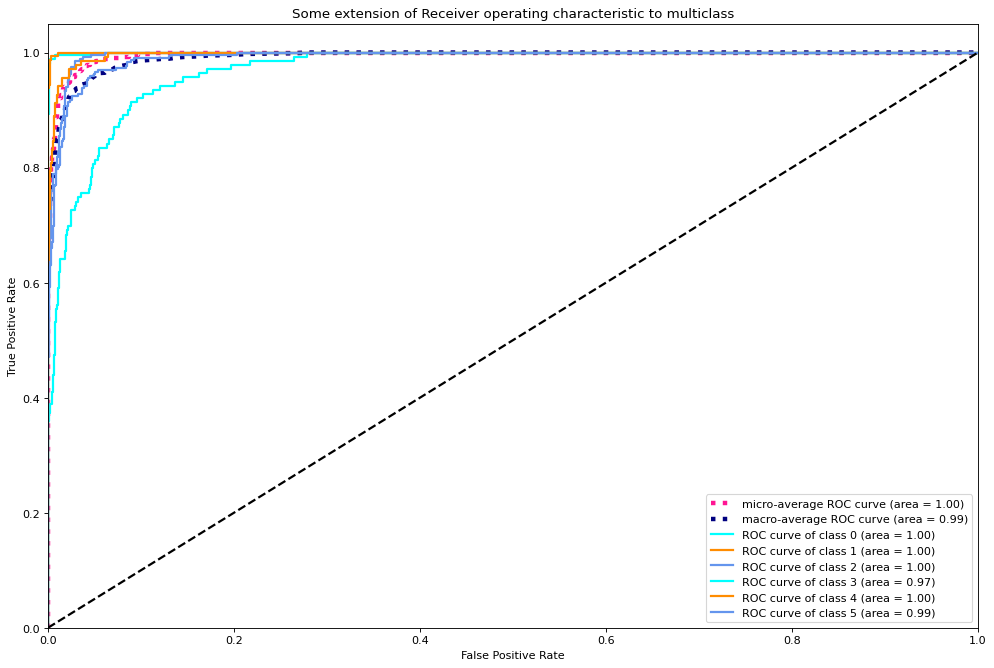

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       289
           1       0.98      0.98      0.98       160
           2       0.90      0.97      0.93       270
           3       0.84      0.61      0.71       139
           4       0.89      0.91      0.90       136
           5       0.87      0.93      0.90       292

    accuracy                           0.92      1286
   macro avg       0.91      0.90      0.90      1286
weighted avg       0.92      0.92      0.91      1286


Model name: LightGBM, calibration algo: sigmoid cv


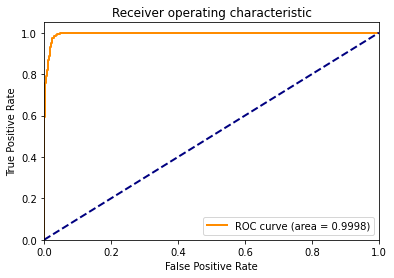

[[[ 994    3]
  [   3  286]]

 [[1124    2]
  [   3  157]]

 [[ 991   25]
  [  10  260]]

 [[1125   22]
  [  45   94]]

 [[1139   11]
  [  11  125]]

 [[ 964   30]
  [  21  271]]]


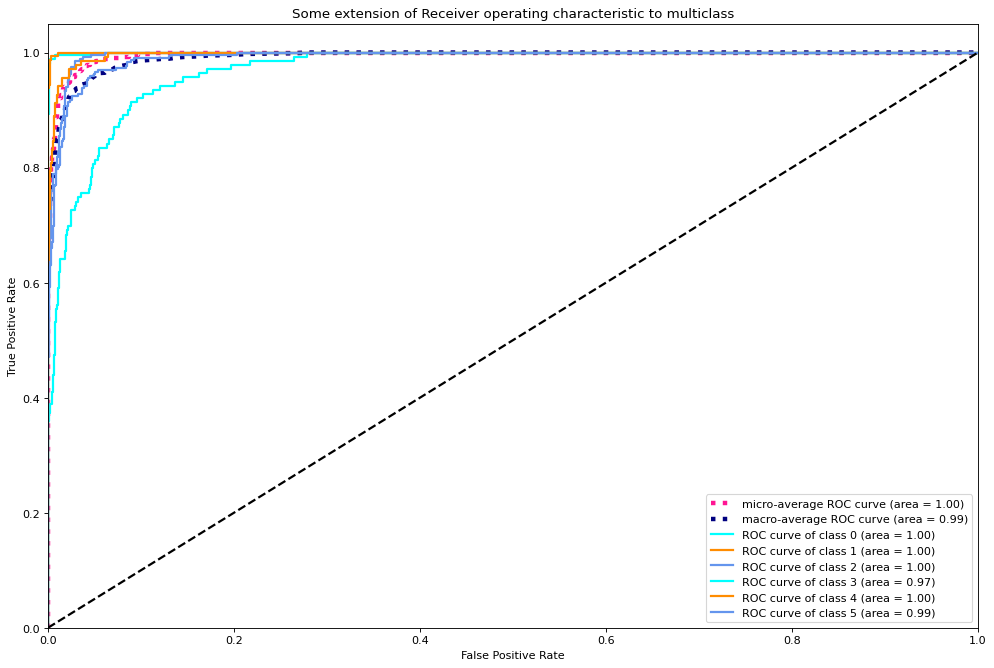

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       289
           1       0.99      0.98      0.98       160
           2       0.92      0.97      0.94       270
           3       0.87      0.65      0.74       139
           4       0.92      0.92      0.92       136
           5       0.89      0.95      0.92       292

    accuracy                           0.93      1286
   macro avg       0.93      0.91      0.91      1286
weighted avg       0.93      0.93      0.93      1286


Model name: LightGBM, calibration algo: isotonic cv


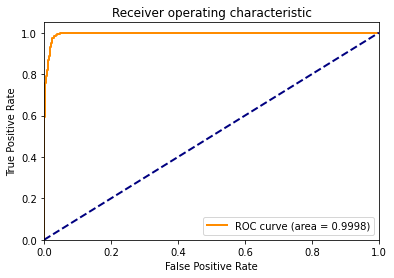

[[[ 994    3]
  [   3  286]]

 [[1124    2]
  [   3  157]]

 [[ 991   25]
  [  10  260]]

 [[1125   22]
  [  45   94]]

 [[1139   11]
  [  11  125]]

 [[ 964   30]
  [  21  271]]]


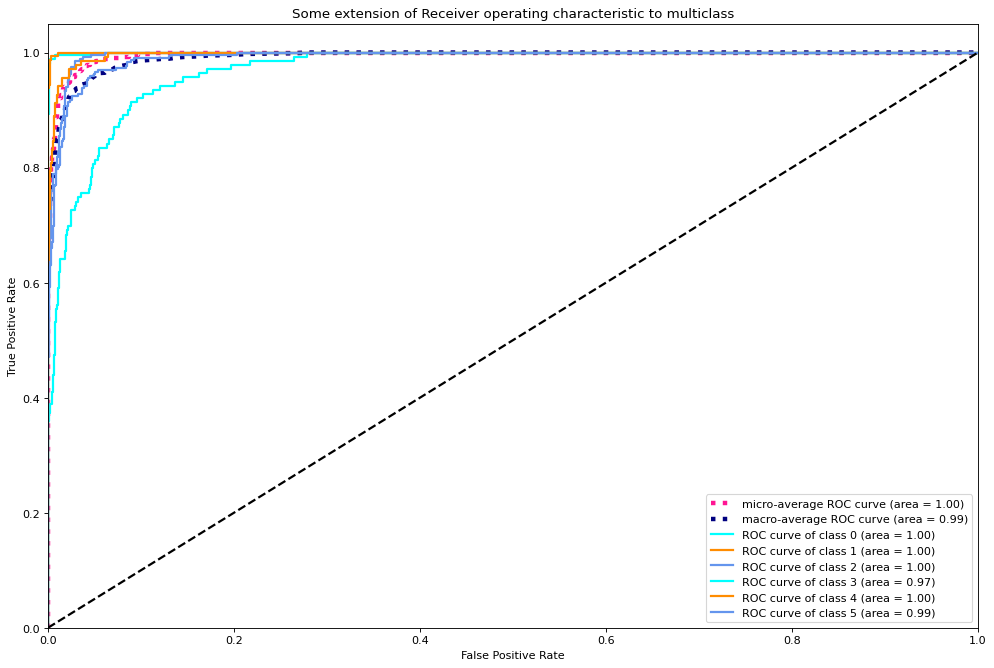

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       289
           1       0.99      0.98      0.98       160
           2       0.91      0.96      0.94       270
           3       0.85      0.63      0.73       139
           4       0.91      0.92      0.92       136
           5       0.88      0.95      0.91       292

    accuracy                           0.93      1286
   macro avg       0.92      0.90      0.91      1286
weighted avg       0.93      0.93      0.92      1286


Model name: LightGBM, calibration algo: ivap


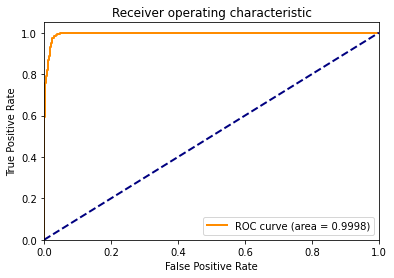

[[[ 994    3]
  [   3  286]]

 [[1124    2]
  [   3  157]]

 [[ 991   25]
  [  10  260]]

 [[1125   22]
  [  45   94]]

 [[1139   11]
  [  11  125]]

 [[ 964   30]
  [  21  271]]]


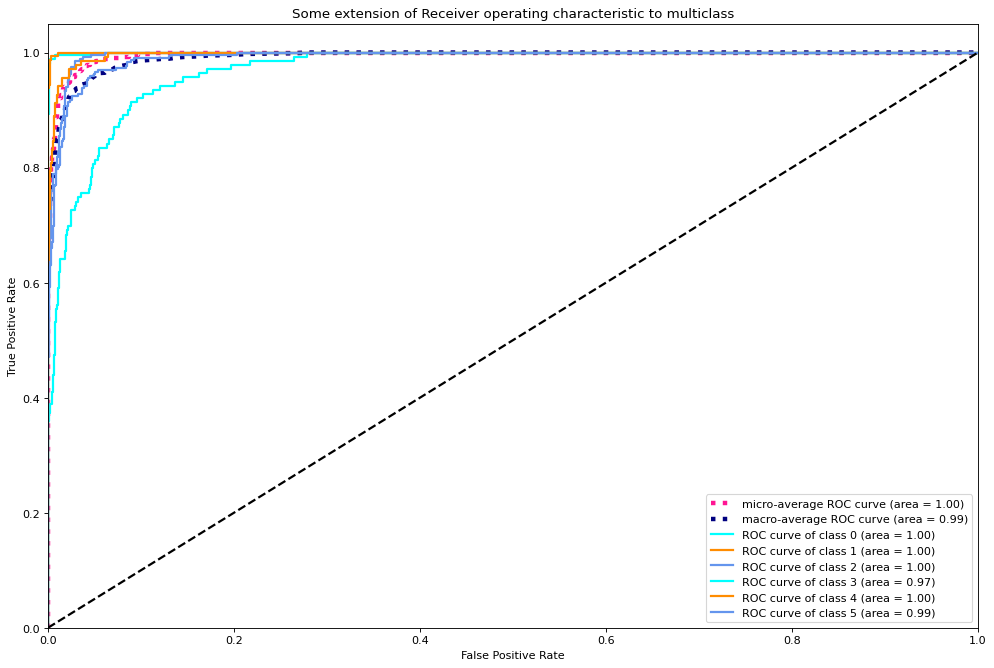

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       289
           1       0.99      0.97      0.98       160
           2       0.90      0.96      0.93       270
           3       0.83      0.61      0.71       139
           4       0.88      0.94      0.91       136
           5       0.87      0.93      0.90       292

    accuracy                           0.92      1286
   macro avg       0.91      0.90      0.90      1286
weighted avg       0.92      0.92      0.92      1286


Model name: LightGBM, calibration algo: cvap


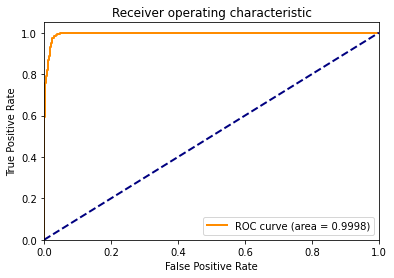

[[[ 994    3]
  [   3  286]]

 [[1124    2]
  [   3  157]]

 [[ 991   25]
  [  10  260]]

 [[1125   22]
  [  45   94]]

 [[1139   11]
  [  11  125]]

 [[ 964   30]
  [  21  271]]]


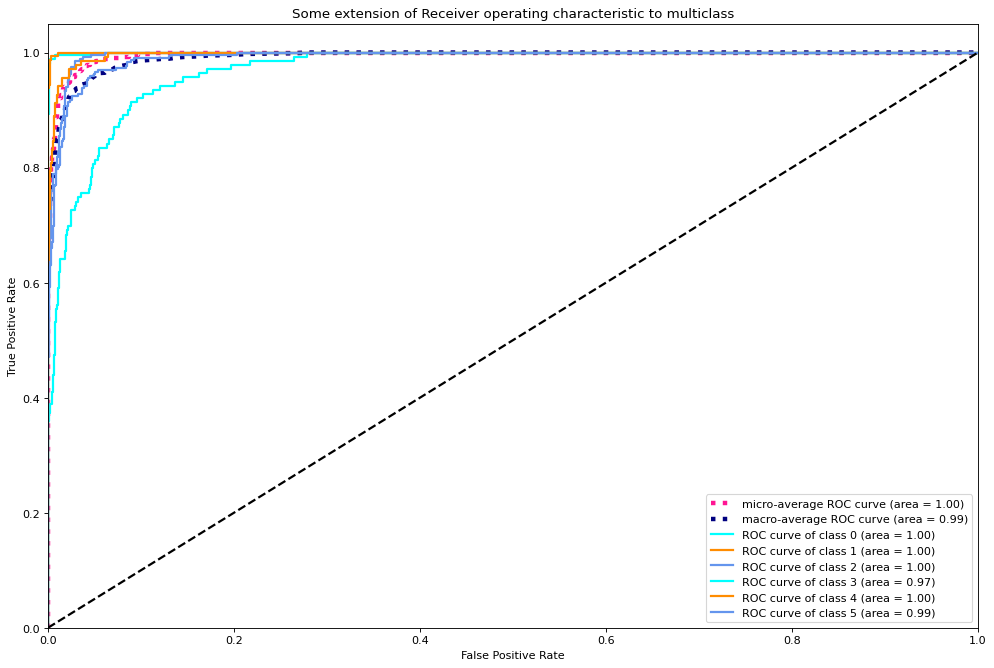

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       289
           1       0.99      0.98      0.98       160
           2       0.92      0.97      0.94       270
           3       0.84      0.64      0.73       139
           4       0.91      0.93      0.92       136
           5       0.88      0.94      0.91       292

    accuracy                           0.93      1286
   macro avg       0.92      0.91      0.91      1286
weighted avg       0.93      0.93      0.92      1286



In [84]:
clf_LGBMC = LGBMClassifier(random_state=42, n_jobs = -1)

[pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_LGBMC, 
                    model_name = 'LightGBM')



### XGBoost


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:0
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 0, j:4
fitting model for i: 0, j:5
fitting model for i: 1, j:0
fitting model for i: 1, j:1
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 1, j:4
fitting model for i: 1, j:5
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:2
fitting model for i: 2, j:3
fitting model for i: 2, j:4
fitting model for i: 2, j:5
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2
fitting model for i: 3, j:3
fitting model for i: 3, j:4
fitting model for i: 3, j:5
fitting model for i: 4, j:0
fitting model for i: 4, j:1
fitting model for i: 4, j:2
fitting model for i: 4, j:3
fitting model for i: 4, j:4
fitting model for i: 4, j:5
fitting model for i: 5, j:0
fitting model for i: 5, j:1
fitting model for i: 5, j:2
fitting model for i: 5, j:3
fit

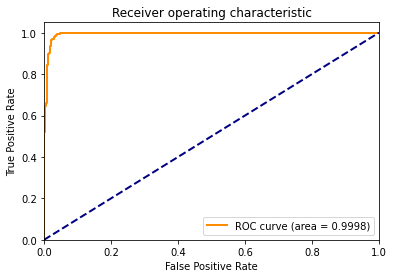

[[[ 995    2]
  [   6  283]]

 [[1124    2]
  [   4  156]]

 [[ 992   24]
  [  10  260]]

 [[1127   20]
  [  43   96]]

 [[1137   13]
  [   7  129]]

 [[ 969   25]
  [  16  276]]]


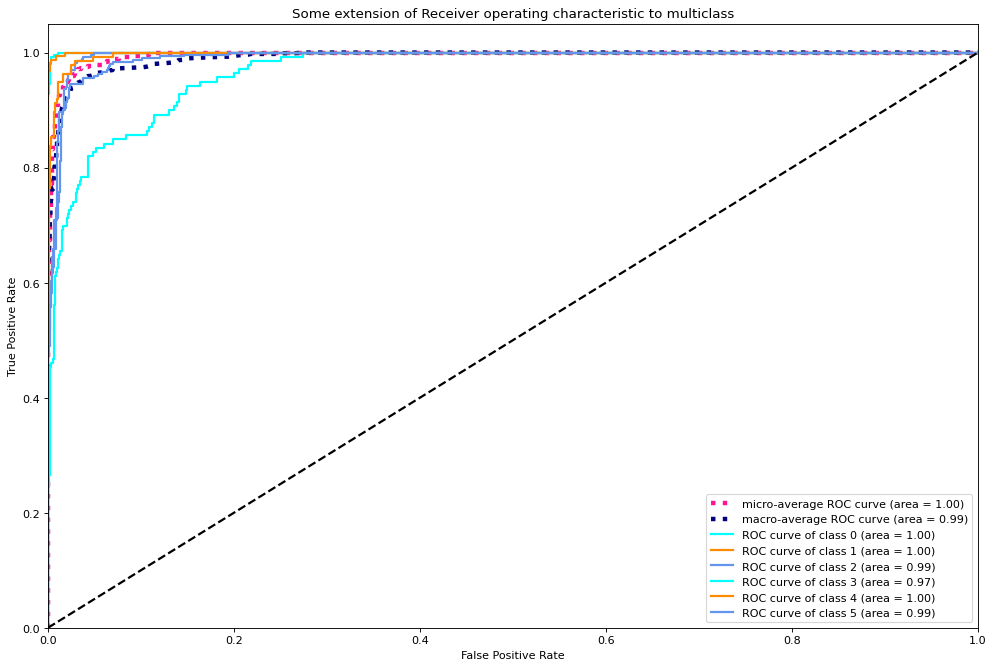

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       289
           1       0.99      0.97      0.98       160
           2       0.92      0.96      0.94       270
           3       0.83      0.69      0.75       139
           4       0.91      0.95      0.93       136
           5       0.92      0.95      0.93       292

    accuracy                           0.93      1286
   macro avg       0.92      0.92      0.92      1286
weighted avg       0.93      0.93      0.93      1286


Model name: XGBoost, calibration algo: sigmoid


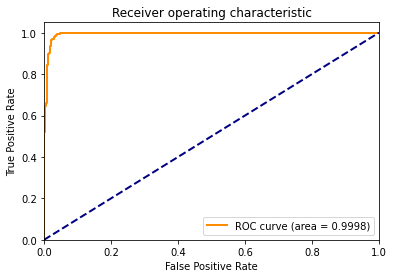

[[[ 995    2]
  [   6  283]]

 [[1124    2]
  [   4  156]]

 [[ 992   24]
  [  10  260]]

 [[1127   20]
  [  43   96]]

 [[1137   13]
  [   7  129]]

 [[ 969   25]
  [  16  276]]]


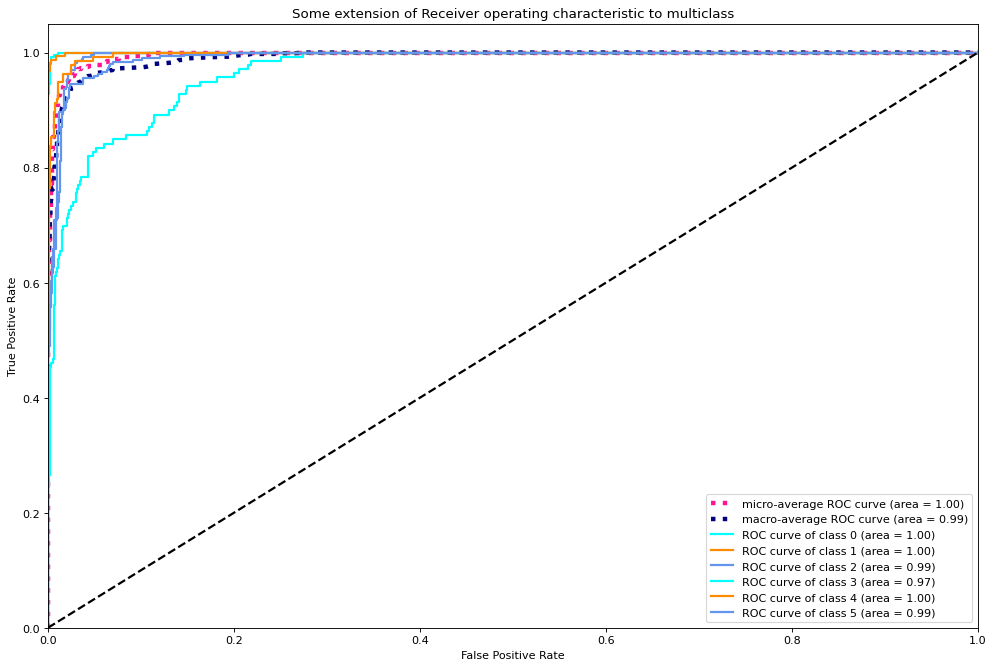

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       289
           1       0.99      0.97      0.98       160
           2       0.91      0.96      0.93       270
           3       0.81      0.63      0.71       139
           4       0.88      0.90      0.89       136
           5       0.87      0.92      0.89       292

    accuracy                           0.91      1286
   macro avg       0.91      0.89      0.90      1286
weighted avg       0.91      0.91      0.91      1286


Model name: XGBoost, calibration algo: isotonic


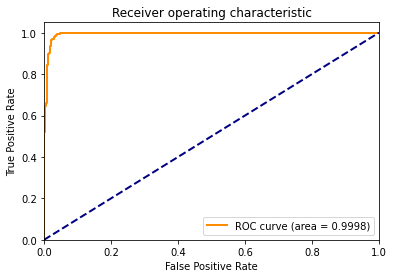

[[[ 995    2]
  [   6  283]]

 [[1124    2]
  [   4  156]]

 [[ 992   24]
  [  10  260]]

 [[1127   20]
  [  43   96]]

 [[1137   13]
  [   7  129]]

 [[ 969   25]
  [  16  276]]]


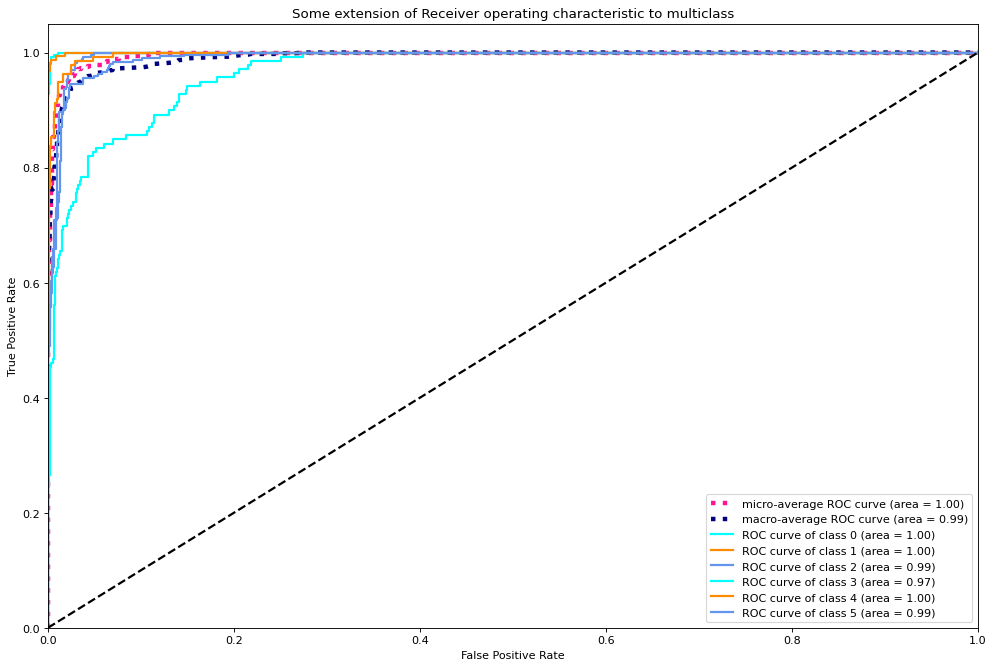

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       289
           1       0.98      0.97      0.97       160
           2       0.88      0.97      0.92       270
           3       0.81      0.55      0.65       139
           4       0.86      0.93      0.90       136
           5       0.87      0.93      0.90       292

    accuracy                           0.91      1286
   macro avg       0.90      0.88      0.89      1286
weighted avg       0.91      0.91      0.90      1286


Model name: XGBoost, calibration algo: sigmoid cv


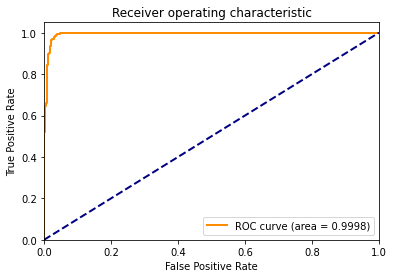

[[[ 995    2]
  [   6  283]]

 [[1124    2]
  [   4  156]]

 [[ 992   24]
  [  10  260]]

 [[1127   20]
  [  43   96]]

 [[1137   13]
  [   7  129]]

 [[ 969   25]
  [  16  276]]]


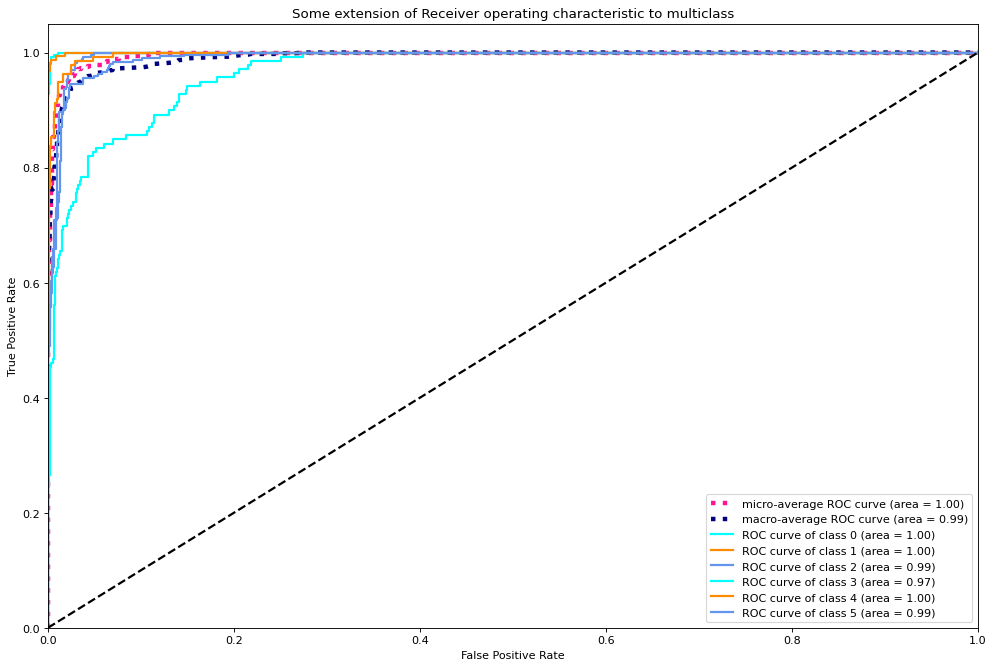

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       289
           1       0.99      0.97      0.98       160
           2       0.92      0.97      0.94       270
           3       0.83      0.65      0.73       139
           4       0.91      0.90      0.91       136
           5       0.89      0.94      0.91       292

    accuracy                           0.93      1286
   macro avg       0.92      0.91      0.91      1286
weighted avg       0.93      0.93      0.92      1286


Model name: XGBoost, calibration algo: isotonic cv


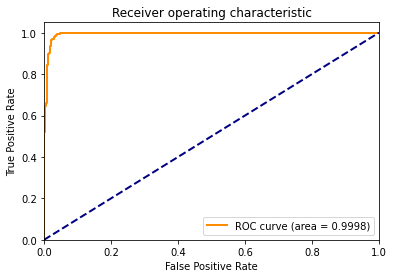

[[[ 995    2]
  [   6  283]]

 [[1124    2]
  [   4  156]]

 [[ 992   24]
  [  10  260]]

 [[1127   20]
  [  43   96]]

 [[1137   13]
  [   7  129]]

 [[ 969   25]
  [  16  276]]]


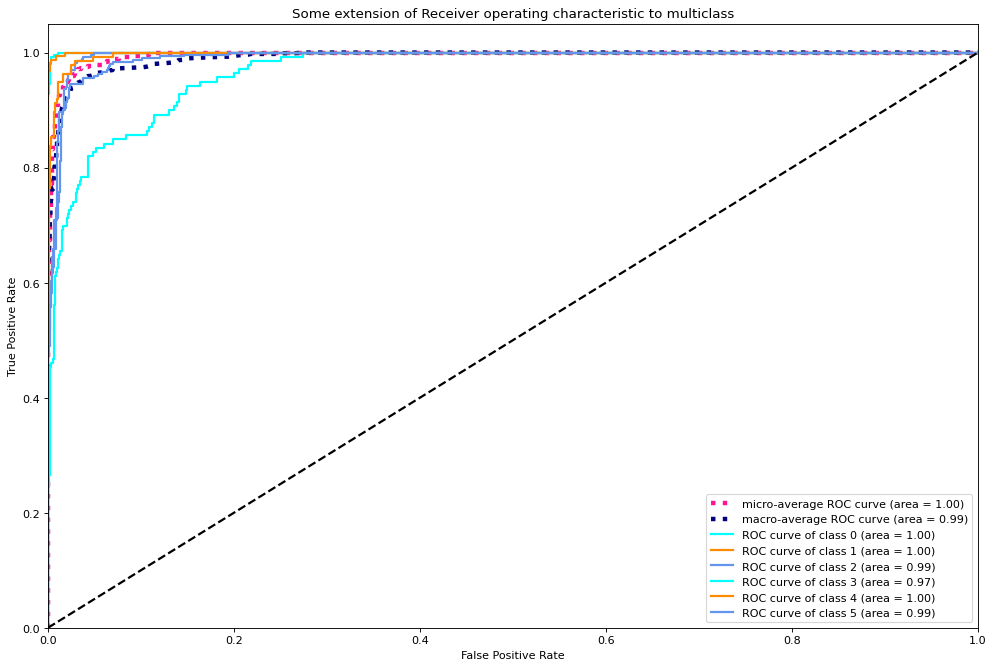

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       289
           1       0.99      0.98      0.98       160
           2       0.91      0.96      0.93       270
           3       0.82      0.65      0.73       139
           4       0.91      0.92      0.92       136
           5       0.89      0.94      0.92       292

    accuracy                           0.93      1286
   macro avg       0.92      0.91      0.91      1286
weighted avg       0.92      0.93      0.92      1286


Model name: XGBoost, calibration algo: ivap


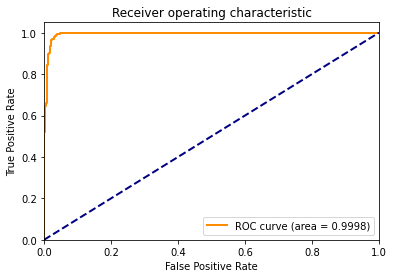

[[[ 995    2]
  [   6  283]]

 [[1124    2]
  [   4  156]]

 [[ 992   24]
  [  10  260]]

 [[1127   20]
  [  43   96]]

 [[1137   13]
  [   7  129]]

 [[ 969   25]
  [  16  276]]]


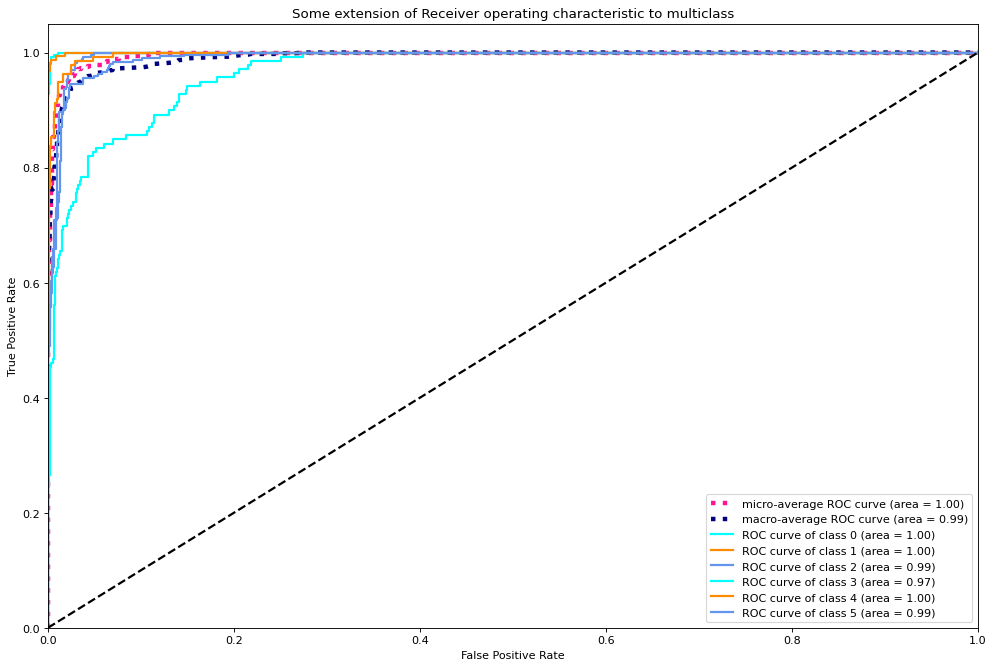

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       289
           1       0.99      0.97      0.98       160
           2       0.88      0.96      0.92       270
           3       0.83      0.56      0.67       139
           4       0.87      0.92      0.89       136
           5       0.87      0.93      0.90       292

    accuracy                           0.91      1286
   macro avg       0.90      0.89      0.89      1286
weighted avg       0.91      0.91      0.91      1286


Model name: XGBoost, calibration algo: cvap


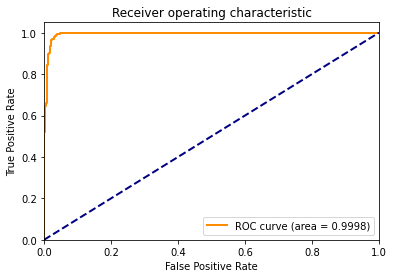

[[[ 995    2]
  [   6  283]]

 [[1124    2]
  [   4  156]]

 [[ 992   24]
  [  10  260]]

 [[1127   20]
  [  43   96]]

 [[1137   13]
  [   7  129]]

 [[ 969   25]
  [  16  276]]]


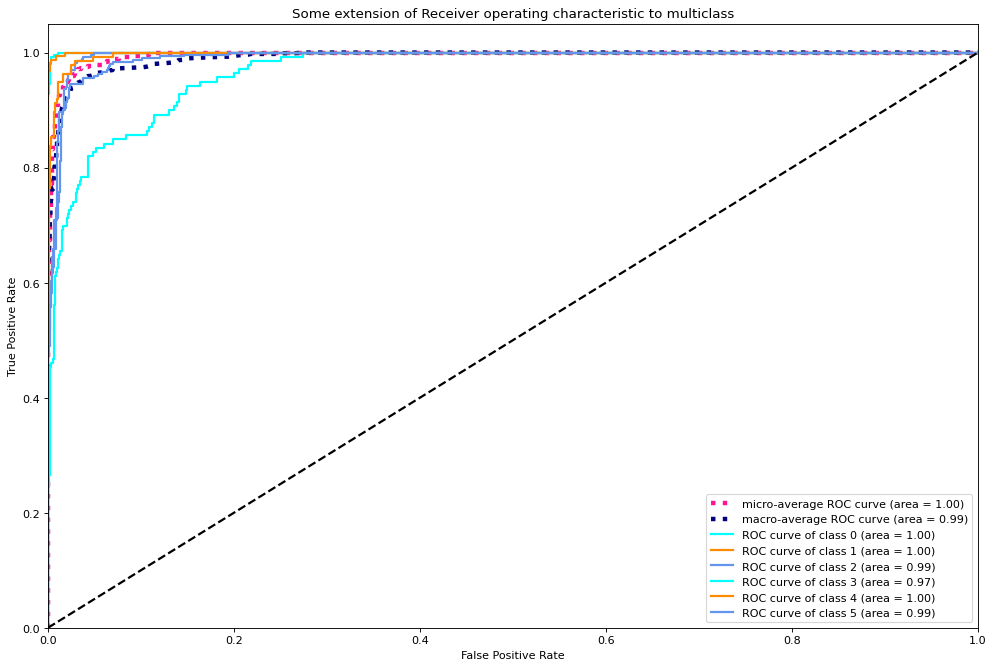

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       289
           1       0.99      0.98      0.98       160
           2       0.91      0.97      0.94       270
           3       0.84      0.65      0.73       139
           4       0.89      0.90      0.89       136
           5       0.88      0.94      0.91       292

    accuracy                           0.92      1286
   macro avg       0.92      0.90      0.91      1286
weighted avg       0.92      0.92      0.92      1286



In [85]:
clf_XGBC = XGBClassifier(random_state=42, n_jobs = -1)

[pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_XGBC, 
                    model_name = 'XGBoost')

In [86]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   1.015793  0.165134  0.162719    0.163699   
KNN                           0.184904  0.080174  0.114040    0.074169   
Support Vector Machine        0.074044  0.079434  0.140253    0.079558   
logistic regression           0.094054  0.098962  0.140865    0.098415   
neural network                0.103468  0.092251  0.113879    0.083388   
Random Forest                 0.074795  0.076784  0.133131    0.072907   
LightGBM                      0.073200  0.080600  0.115338    0.072283   
XGBoost                       0.070926  0.084546  0.118047    0.072678   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.140868  0.155458  0.152873  
KNN                        0.066965  0.269102  0.271722  
Support Vector Machine     0.078090  0.089106  0.090691  
logistic regression        0.096940  0.106434  0.104999  
neural network             0.072697  0.180124  0.176570  
Random Forest              0.070622  0.094740  0.094769  
LightGBM                   0.071776  0.078733  0.077461  
XGBoost                    0.066182  0.083191  0.080031  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [87]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.061694  0.047837  0.043390    0.047269   
KNN                           0.021092  0.022677  0.022308    0.020846   
Support Vector Machine        0.021485  0.022648  0.023126    0.022211   
logistic regression           0.029080  0.029961  0.029896    0.029692   
neural network                0.023303  0.024415  0.023185    0.021816   
Random Forest                 0.021345  0.021780  0.022606    0.020135   
LightGBM                      0.019534  0.021431  0.019856    0.018854   
XGBoost                       0.018593  0.022630  0.021855    0.018824   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.041502  0.044480  0.043124  
KNN                        0.019987  0.078450  0.078399  
Support Vector Machine     0.021815  0.023996  0.023693  
logistic regression        0.028742  0.030332  0.029657  
neural network             0.020917  0.046434  0.044640  
Random Forest              0.020072  0.023760  0.022836  
LightGBM                   0.018037  0.021027  0.019769  
XGBoost                    0.018658  0.022392  0.020512  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

### CatBoost

Streaming output truncated to the last 5000 lines.
58:	learn: 0.0030000	total: 214ms	remaining: 149ms
59:	learn: 0.0028886	total: 218ms	remaining: 145ms
60:	learn: 0.0028886	total: 219ms	remaining: 140ms
61:	learn: 0.0027686	total: 223ms	remaining: 136ms
62:	learn: 0.0027686	total: 226ms	remaining: 133ms
63:	learn: 0.0027497	total: 229ms	remaining: 129ms
64:	learn: 0.0027116	total: 232ms	remaining: 125ms
65:	learn: 0.0027055	total: 236ms	remaining: 121ms
66:	learn: 0.0026641	total: 239ms	remaining: 118ms
67:	learn: 0.0025700	total: 243ms	remaining: 114ms
68:	learn: 0.0025504	total: 246ms	remaining: 111ms
69:	learn: 0.0024724	total: 249ms	remaining: 107ms
70:	learn: 0.0024724	total: 252ms	remaining: 103ms
71:	learn: 0.0023739	total: 256ms	remaining: 99.5ms
72:	learn: 0.0023001	total: 259ms	remaining: 95.9ms
73:	learn: 0.0022864	total: 263ms	remaining: 92.3ms
74:	learn: 0.0022162	total: 266ms	remaining: 88.7ms
75:	learn: 0.0022162	total: 269ms	remaining: 85ms
76:	learn: 0.0022162	total: 

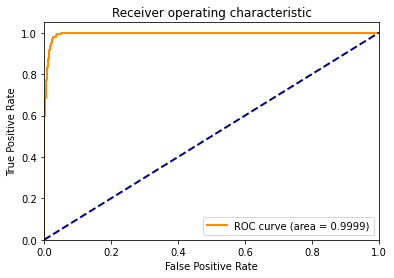

[[[ 993    4]
  [   4  285]]

 [[1125    1]
  [   3  157]]

 [[ 992   24]
  [   9  261]]

 [[1125   22]
  [  50   89]]

 [[1138   12]
  [  12  124]]

 [[ 958   36]
  [  21  271]]]


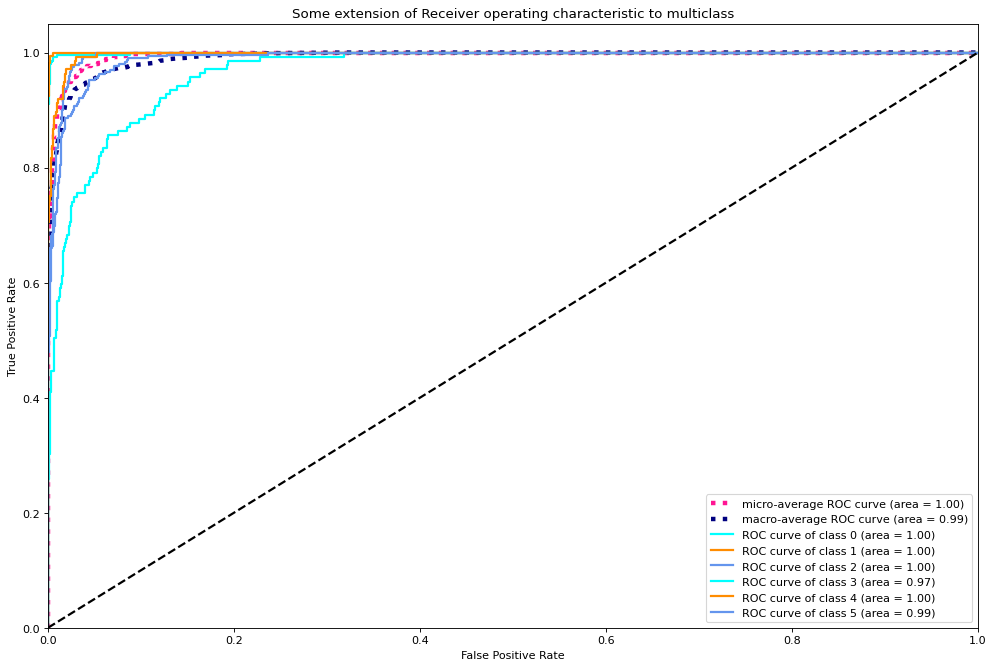

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       289
           1       0.99      0.98      0.99       160
           2       0.92      0.97      0.94       270
           3       0.80      0.64      0.71       139
           4       0.91      0.91      0.91       136
           5       0.88      0.93      0.90       292

    accuracy                           0.92      1286
   macro avg       0.92      0.90      0.91      1286
weighted avg       0.92      0.92      0.92      1286


Model name: CatBoost, calibration algo: sigmoid


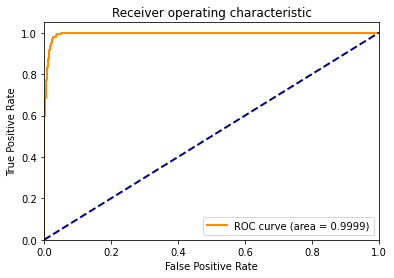

[[[ 993    4]
  [   4  285]]

 [[1125    1]
  [   3  157]]

 [[ 992   24]
  [   9  261]]

 [[1125   22]
  [  50   89]]

 [[1138   12]
  [  12  124]]

 [[ 958   36]
  [  21  271]]]


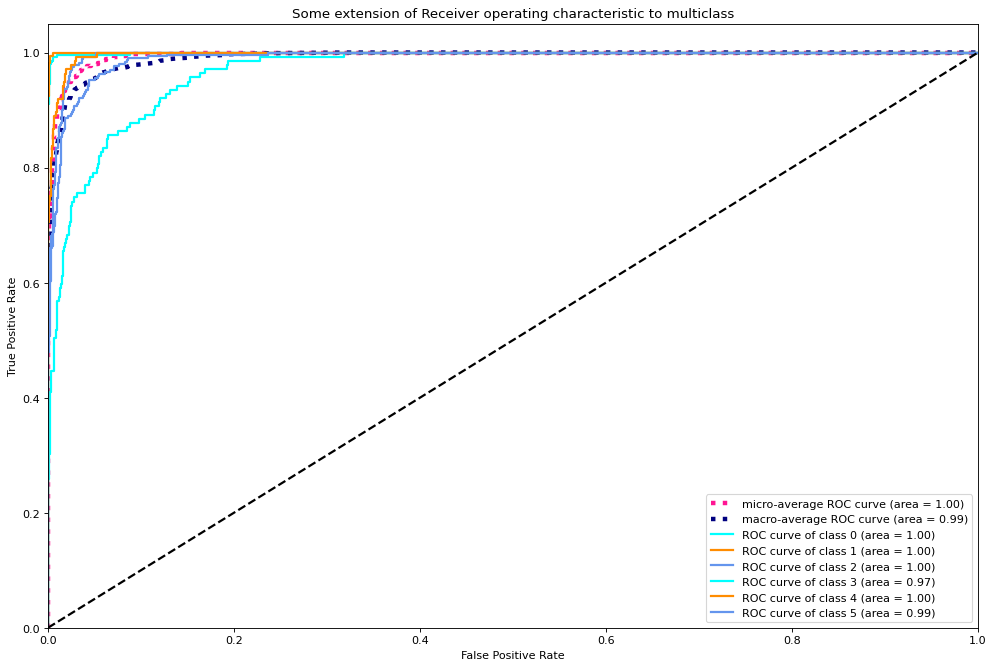

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       289
           1       0.99      0.97      0.98       160
           2       0.91      0.96      0.93       270
           3       0.79      0.63      0.70       139
           4       0.89      0.90      0.89       136
           5       0.87      0.92      0.90       292

    accuracy                           0.91      1286
   macro avg       0.91      0.89      0.90      1286
weighted avg       0.91      0.91      0.91      1286


Model name: CatBoost, calibration algo: isotonic


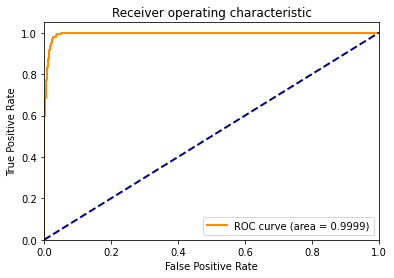

[[[ 993    4]
  [   4  285]]

 [[1125    1]
  [   3  157]]

 [[ 992   24]
  [   9  261]]

 [[1125   22]
  [  50   89]]

 [[1138   12]
  [  12  124]]

 [[ 958   36]
  [  21  271]]]


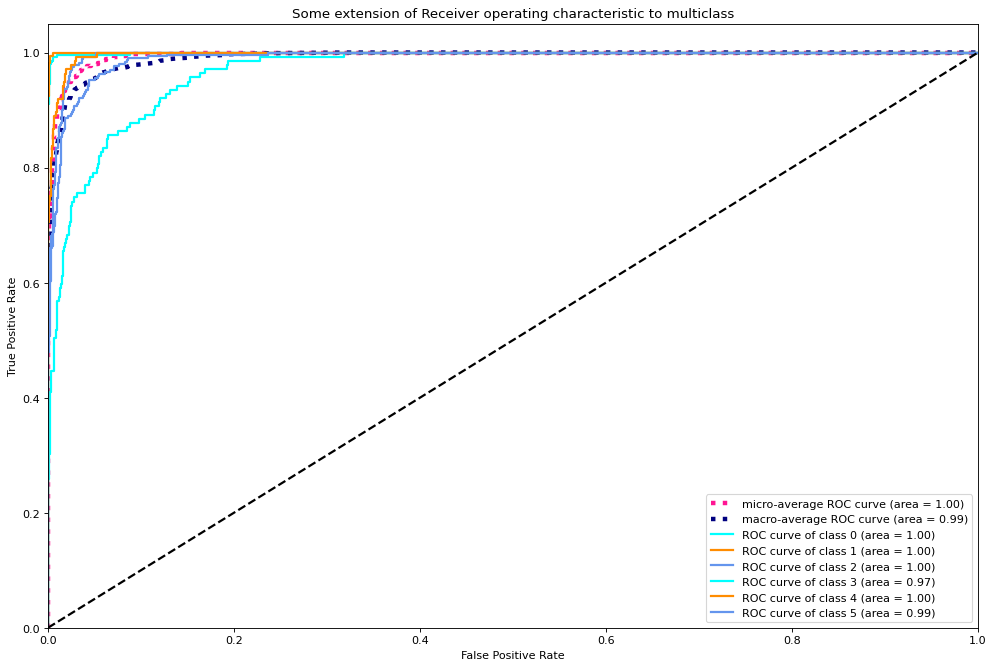

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       289
           1       0.99      0.97      0.98       160
           2       0.91      0.96      0.93       270
           3       0.77      0.64      0.70       139
           4       0.88      0.91      0.90       136
           5       0.88      0.91      0.89       292

    accuracy                           0.91      1286
   macro avg       0.90      0.89      0.90      1286
weighted avg       0.91      0.91      0.91      1286


Model name: CatBoost, calibration algo: sigmoid cv


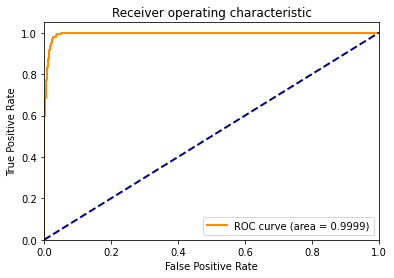

[[[ 993    4]
  [   4  285]]

 [[1125    1]
  [   3  157]]

 [[ 992   24]
  [   9  261]]

 [[1125   22]
  [  50   89]]

 [[1138   12]
  [  12  124]]

 [[ 958   36]
  [  21  271]]]


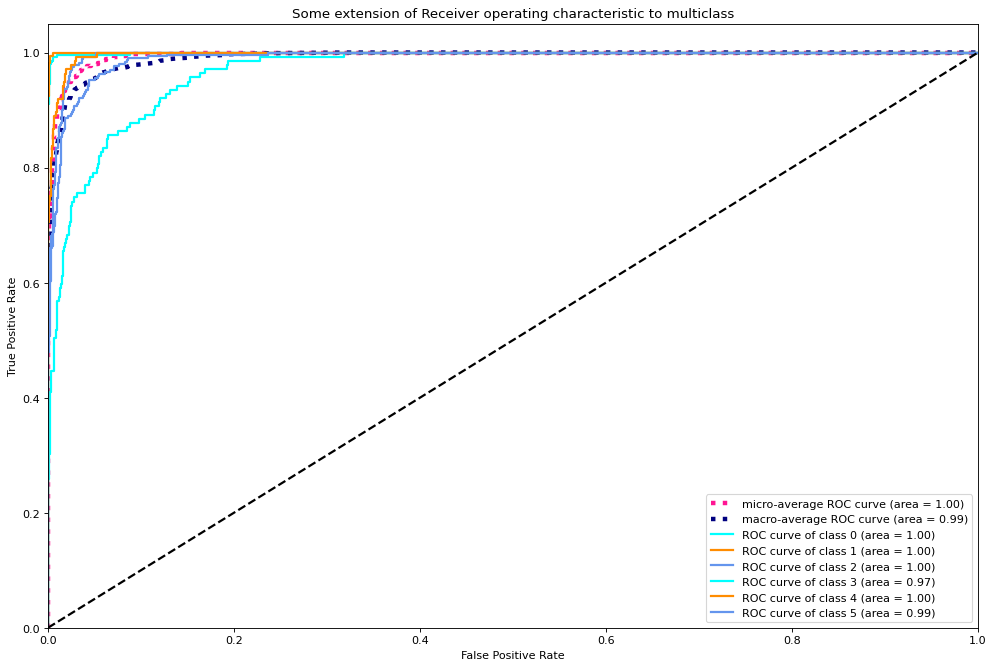

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       289
           1       0.99      0.98      0.99       160
           2       0.91      0.96      0.94       270
           3       0.84      0.65      0.73       139
           4       0.92      0.90      0.91       136
           5       0.88      0.95      0.91       292

    accuracy                           0.93      1286
   macro avg       0.92      0.90      0.91      1286
weighted avg       0.92      0.93      0.92      1286


Model name: CatBoost, calibration algo: isotonic cv


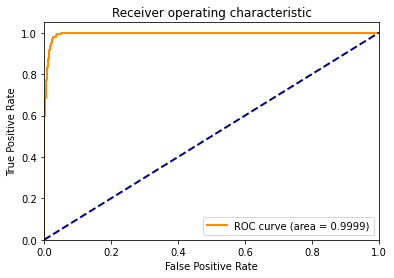

[[[ 993    4]
  [   4  285]]

 [[1125    1]
  [   3  157]]

 [[ 992   24]
  [   9  261]]

 [[1125   22]
  [  50   89]]

 [[1138   12]
  [  12  124]]

 [[ 958   36]
  [  21  271]]]


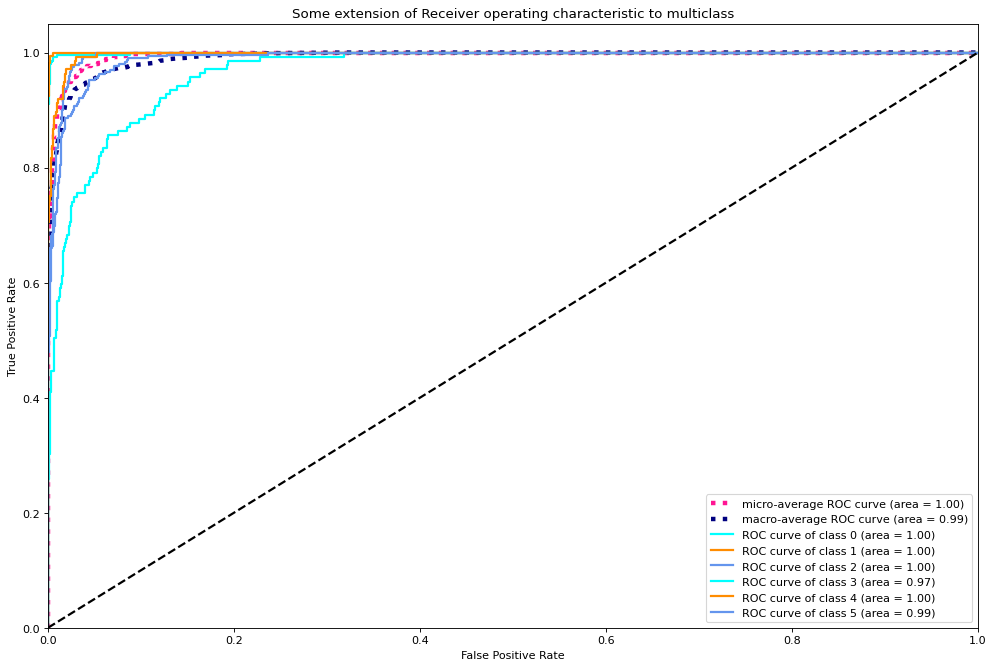

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       289
           1       0.98      0.99      0.98       160
           2       0.91      0.96      0.94       270
           3       0.86      0.64      0.73       139
           4       0.91      0.90      0.91       136
           5       0.88      0.94      0.91       292

    accuracy                           0.92      1286
   macro avg       0.92      0.90      0.91      1286
weighted avg       0.92      0.92      0.92      1286


Model name: CatBoost, calibration algo: ivap


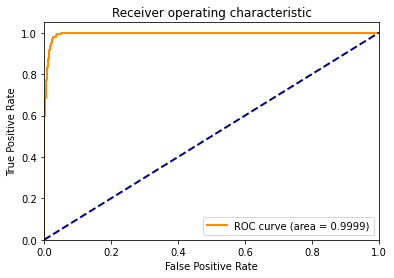

[[[ 993    4]
  [   4  285]]

 [[1125    1]
  [   3  157]]

 [[ 992   24]
  [   9  261]]

 [[1125   22]
  [  50   89]]

 [[1138   12]
  [  12  124]]

 [[ 958   36]
  [  21  271]]]


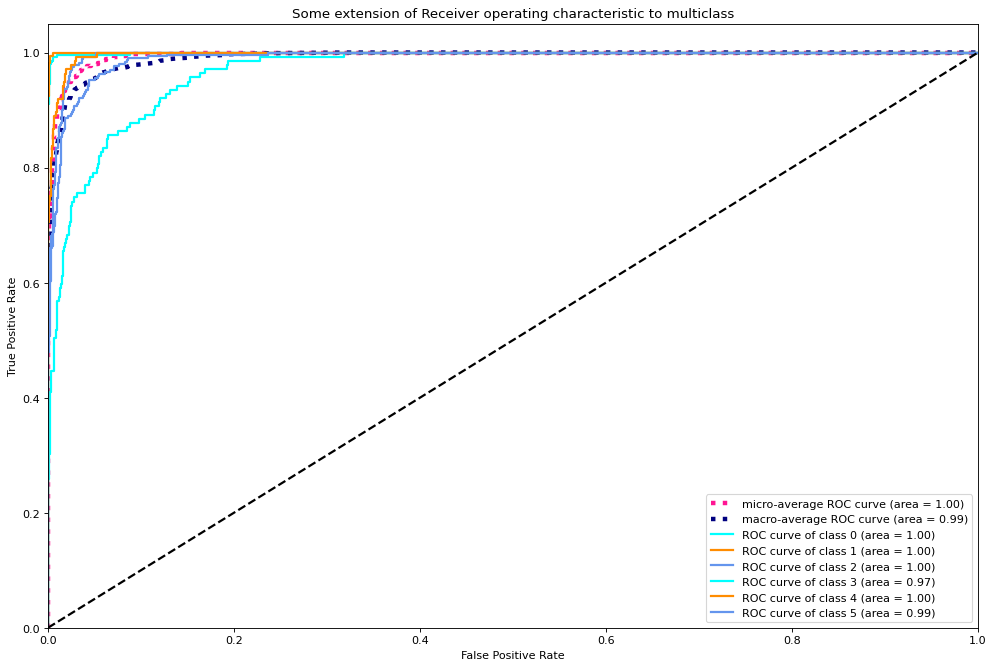

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       289
           1       0.99      0.97      0.98       160
           2       0.91      0.96      0.93       270
           3       0.77      0.63      0.69       139
           4       0.88      0.91      0.90       136
           5       0.87      0.91      0.89       292

    accuracy                           0.91      1286
   macro avg       0.90      0.89      0.89      1286
weighted avg       0.91      0.91      0.91      1286


Model name: CatBoost, calibration algo: cvap


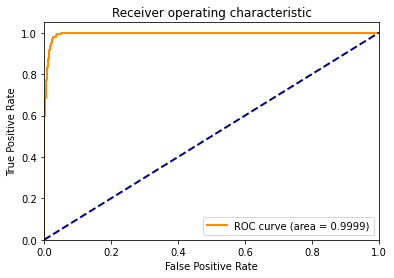

[[[ 993    4]
  [   4  285]]

 [[1125    1]
  [   3  157]]

 [[ 992   24]
  [   9  261]]

 [[1125   22]
  [  50   89]]

 [[1138   12]
  [  12  124]]

 [[ 958   36]
  [  21  271]]]


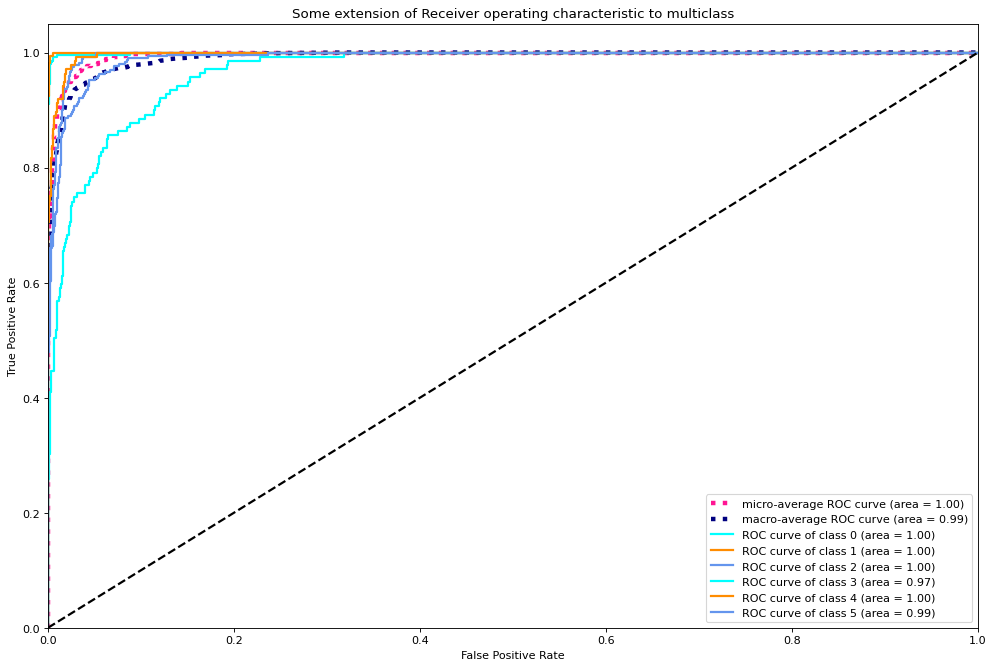

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       289
           1       0.99      0.99      0.99       160
           2       0.91      0.96      0.94       270
           3       0.82      0.63      0.71       139
           4       0.88      0.90      0.89       136
           5       0.88      0.94      0.91       292

    accuracy                           0.92      1286
   macro avg       0.91      0.90      0.90      1286
weighted avg       0.92      0.92      0.92      1286



In [88]:
clf_CBC = CatBoostClassifier(iterations=100, random_state=42)

[pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_CBC, 
                    model_name = 'CatBoost')

In [89]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   1.015793  0.165134  0.162719    0.163699   
KNN                           0.184904  0.080174  0.114040    0.074169   
Support Vector Machine        0.074044  0.079434  0.140253    0.079558   
logistic regression           0.094054  0.098962  0.140865    0.098415   
neural network                0.103468  0.092251  0.113879    0.083388   
Random Forest                 0.074795  0.076784  0.133131    0.072907   
LightGBM                      0.073200  0.080600  0.115338    0.072283   
XGBoost                       0.070926  0.084546  0.118047    0.072678   
CatBoost                      0.063931  0.078486  0.137346    0.071831   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.140868  0.155458  0.152873  
KNN                        0.066965  0.269102  0.271722  
Support Vector Machine     0.078090  0.089106  0.090691  
logistic regression        0.096940  0.106434  0.104999  
neural network             0.072697  0.180124  0.176570  
Random Forest              0.070622  0.094740  0.094769  
LightGBM                   0.071776  0.078733  0.077461  
XGBoost                    0.066182  0.083191  0.080031  
CatBoost                   0.066013  0.082369  0.081189  
Ada Boost                       NaN       NaN       NaN

### Ada Boost


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:0
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 0, j:3
fitting model for i: 0, j:4
fitting model for i: 0, j:5
fitting model for i: 1, j:0
fitting model for i: 1, j:1
fitting model for i: 1, j:2
fitting model for i: 1, j:3
fitting model for i: 1, j:4
fitting model for i: 1, j:5
fitting model for i: 2, j:0
fitting model for i: 2, j:1
fitting model for i: 2, j:2
fitting model for i: 2, j:3
fitting model for i: 2, j:4
fitting model for i: 2, j:5
fitting model for i: 3, j:0
fitting model for i: 3, j:1
fitting model for i: 3, j:2
fitting model for i: 3, j:3
fitting model for i: 3, j:4
fitting model for i: 3, j:5
fitting model for i: 4, j:0
fitting model for i: 4, j:1
fitting model for i: 4, j:2
fitting model for i: 4, j:3
fitting model for i: 4, j:4
fitting model for i: 4, j:5
fitting model for i: 5, j:0
fitting model for i: 5, j:1
fitting model for i: 5, j:2
fitting model for i: 5, j:3
fit

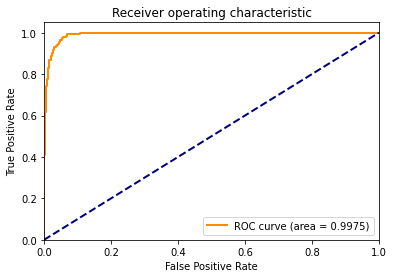

[[[ 976   21]
  [   8  281]]

 [[1120    6]
  [   2  158]]

 [[ 961   55]
  [   7  263]]

 [[1110   37]
  [  74   65]]

 [[1140   10]
  [  32  104]]

 [[ 952   42]
  [  48  244]]]


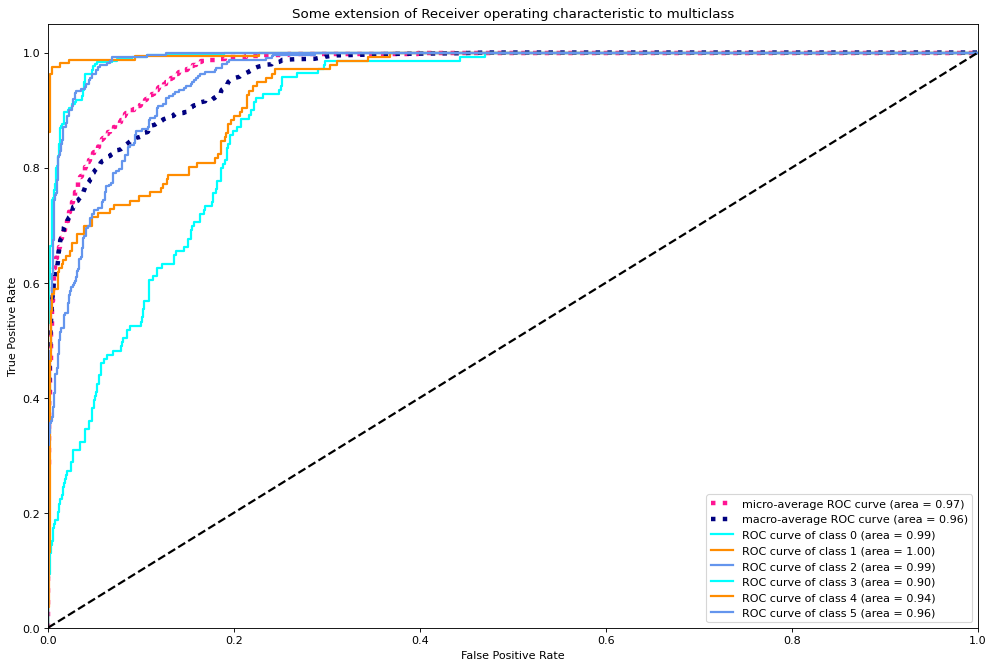

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       289
           1       0.96      0.99      0.98       160
           2       0.83      0.97      0.89       270
           3       0.64      0.47      0.54       139
           4       0.91      0.76      0.83       136
           5       0.85      0.84      0.84       292

    accuracy                           0.87      1286
   macro avg       0.85      0.83      0.84      1286
weighted avg       0.86      0.87      0.86      1286


Model name: Ada Boost, calibration algo: sigmoid


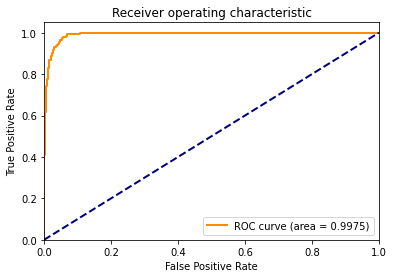

[[[ 976   21]
  [   8  281]]

 [[1120    6]
  [   2  158]]

 [[ 961   55]
  [   7  263]]

 [[1110   37]
  [  74   65]]

 [[1140   10]
  [  32  104]]

 [[ 952   42]
  [  48  244]]]


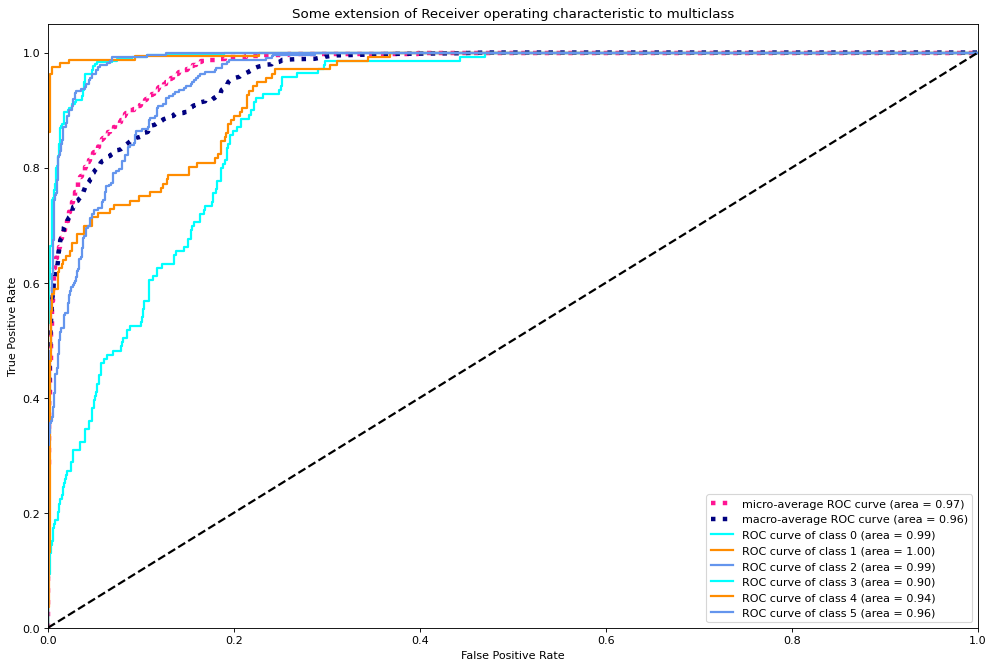

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       289
           1       0.99      0.97      0.98       160
           2       0.89      0.96      0.93       270
           3       0.76      0.45      0.57       139
           4       0.92      0.84      0.88       136
           5       0.80      0.93      0.86       292

    accuracy                           0.89      1286
   macro avg       0.89      0.86      0.86      1286
weighted avg       0.89      0.89      0.88      1286


Model name: Ada Boost, calibration algo: isotonic


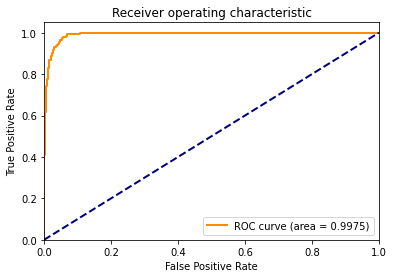

[[[ 976   21]
  [   8  281]]

 [[1120    6]
  [   2  158]]

 [[ 961   55]
  [   7  263]]

 [[1110   37]
  [  74   65]]

 [[1140   10]
  [  32  104]]

 [[ 952   42]
  [  48  244]]]


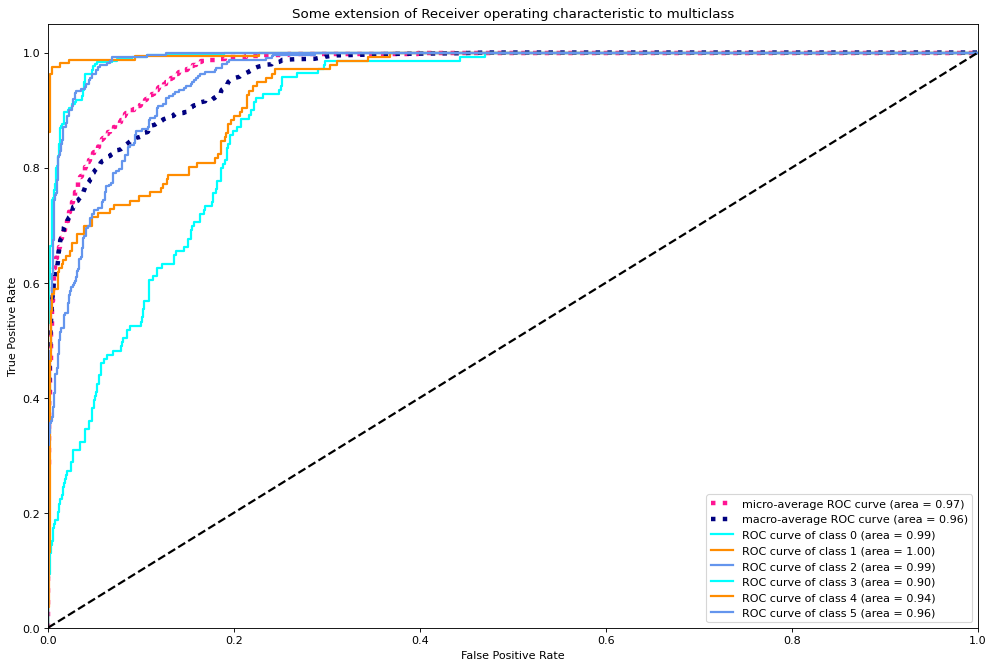

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       289
           1       0.99      0.97      0.98       160
           2       0.91      0.94      0.93       270
           3       0.71      0.50      0.58       139
           4       0.85      0.90      0.88       136
           5       0.82      0.91      0.86       292

    accuracy                           0.89      1286
   macro avg       0.88      0.86      0.87      1286
weighted avg       0.89      0.89      0.89      1286


Model name: Ada Boost, calibration algo: sigmoid cv


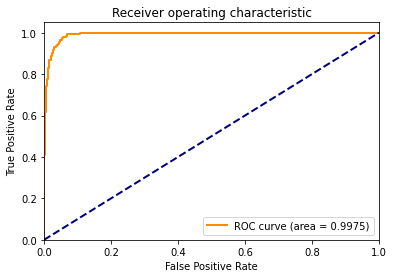

[[[ 976   21]
  [   8  281]]

 [[1120    6]
  [   2  158]]

 [[ 961   55]
  [   7  263]]

 [[1110   37]
  [  74   65]]

 [[1140   10]
  [  32  104]]

 [[ 952   42]
  [  48  244]]]


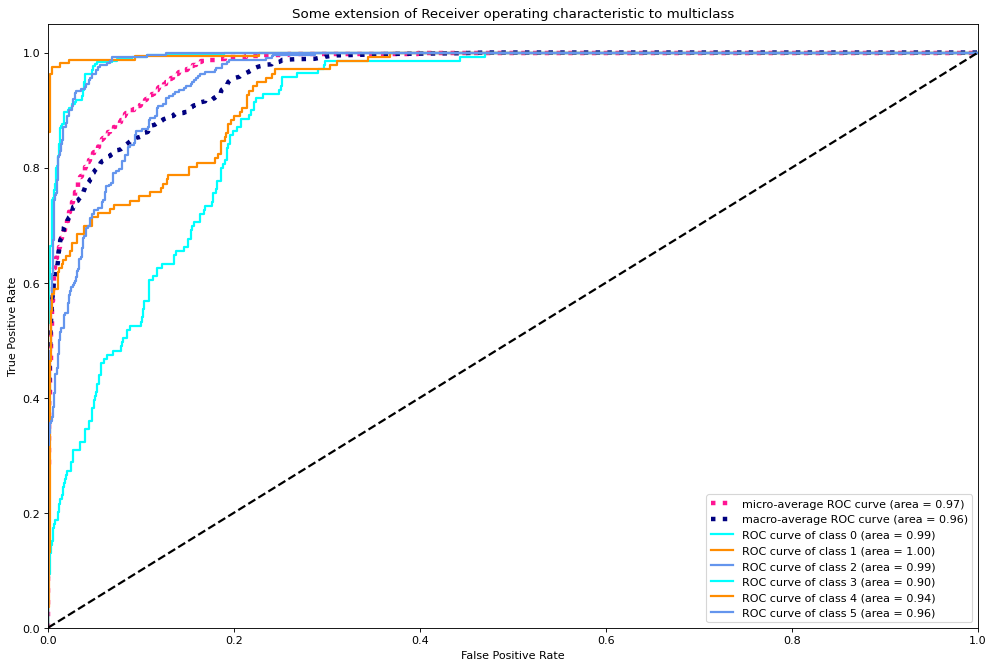

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       289
           1       0.99      0.97      0.98       160
           2       0.89      0.98      0.93       270
           3       0.77      0.54      0.63       139
           4       0.90      0.83      0.87       136
           5       0.84      0.92      0.88       292

    accuracy                           0.90      1286
   macro avg       0.89      0.87      0.88      1286
weighted avg       0.90      0.90      0.90      1286


Model name: Ada Boost, calibration algo: isotonic cv


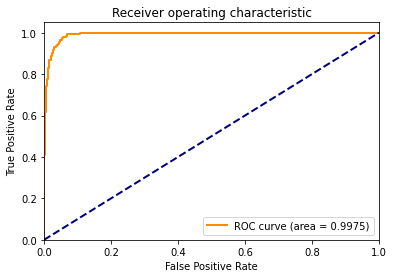

[[[ 976   21]
  [   8  281]]

 [[1120    6]
  [   2  158]]

 [[ 961   55]
  [   7  263]]

 [[1110   37]
  [  74   65]]

 [[1140   10]
  [  32  104]]

 [[ 952   42]
  [  48  244]]]


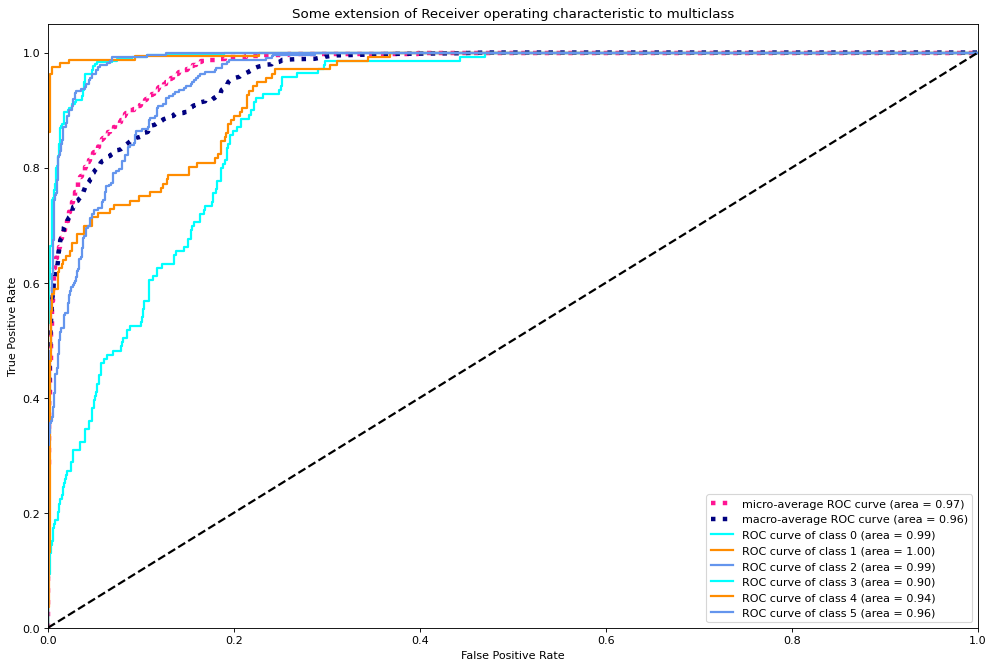

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       289
           1       0.99      0.99      0.99       160
           2       0.90      0.96      0.93       270
           3       0.70      0.60      0.65       139
           4       0.89      0.90      0.89       136
           5       0.87      0.88      0.87       292

    accuracy                           0.90      1286
   macro avg       0.89      0.88      0.88      1286
weighted avg       0.90      0.90      0.90      1286


Model name: Ada Boost, calibration algo: ivap


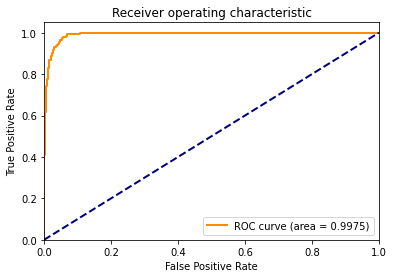

[[[ 976   21]
  [   8  281]]

 [[1120    6]
  [   2  158]]

 [[ 961   55]
  [   7  263]]

 [[1110   37]
  [  74   65]]

 [[1140   10]
  [  32  104]]

 [[ 952   42]
  [  48  244]]]


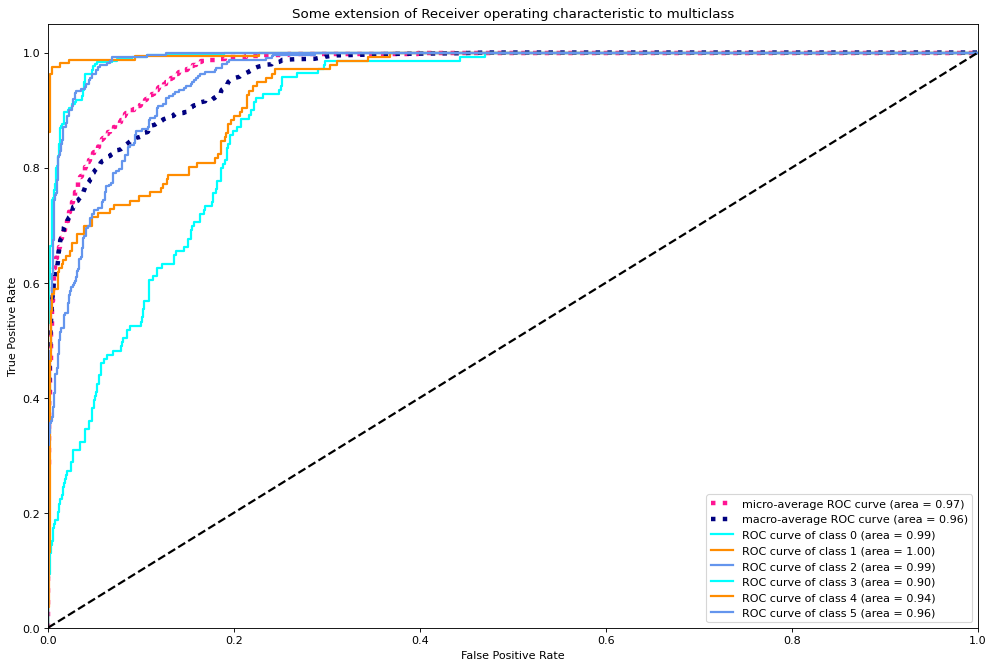

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       289
           1       0.98      0.97      0.98       160
           2       0.91      0.95      0.93       270
           3       0.73      0.48      0.58       139
           4       0.87      0.90      0.88       136
           5       0.82      0.91      0.86       292

    accuracy                           0.89      1286
   macro avg       0.88      0.86      0.87      1286
weighted avg       0.89      0.89      0.89      1286


Model name: Ada Boost, calibration algo: cvap


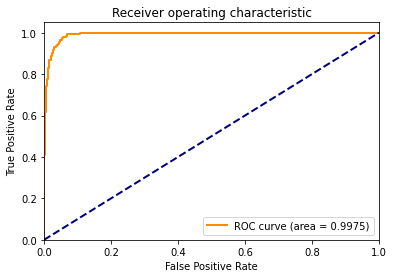

[[[ 976   21]
  [   8  281]]

 [[1120    6]
  [   2  158]]

 [[ 961   55]
  [   7  263]]

 [[1110   37]
  [  74   65]]

 [[1140   10]
  [  32  104]]

 [[ 952   42]
  [  48  244]]]


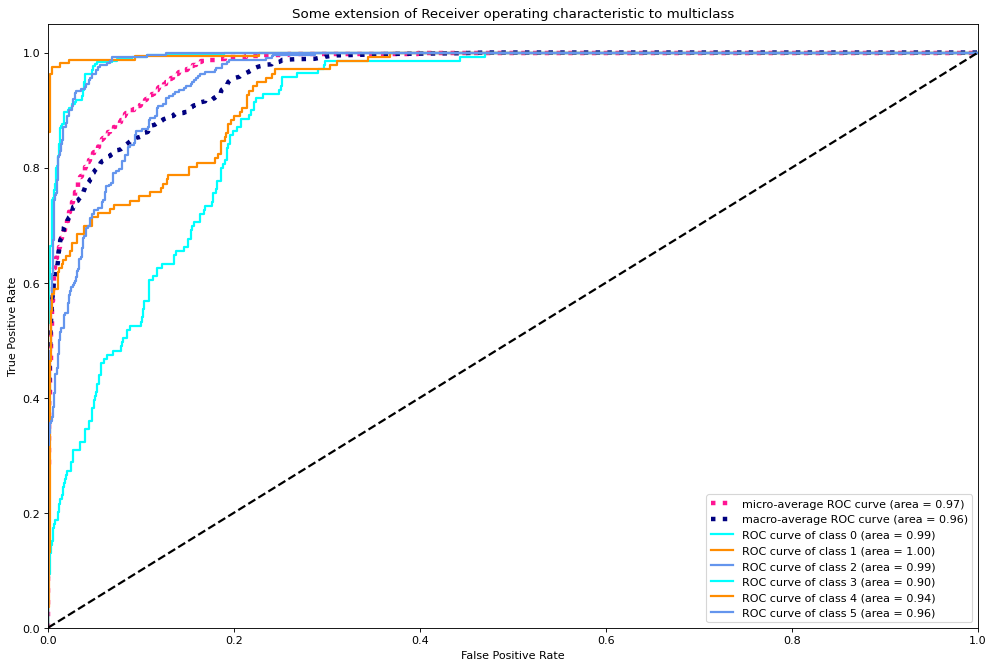

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       289
           1       0.99      0.97      0.98       160
           2       0.91      0.96      0.94       270
           3       0.73      0.61      0.66       139
           4       0.89      0.88      0.88       136
           5       0.87      0.90      0.88       292

    accuracy                           0.91      1286
   macro avg       0.89      0.88      0.89      1286
weighted avg       0.90      0.91      0.90      1286



In [90]:
clf_AdaBoost = AdaBoostClassifier()

[y_pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_AdaBoost, 
                    model_name = 'Ada Boost')

In [91]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   1.015793  0.165134  0.162719    0.163699   
KNN                           0.184904  0.080174  0.114040    0.074169   
Support Vector Machine        0.074044  0.079434  0.140253    0.079558   
logistic regression           0.094054  0.098962  0.140865    0.098415   
neural network                0.103468  0.092251  0.113879    0.083388   
Random Forest                 0.074795  0.076784  0.133131    0.072907   
LightGBM                      0.073200  0.080600  0.115338    0.072283   
XGBoost                       0.070926  0.084546  0.118047    0.072678   
CatBoost                      0.063931  0.078486  0.137346    0.071831   
Ada Boost                     0.309782  0.091400  0.149390    0.091414   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.140868  0.155458  0.152873  
KNN                        0.066965  0.269102  0.271722  
Support Vector Machine     0.078090  0.089106  0.090691  
logistic regression        0.096940  0.106434  0.104999  
neural network             0.072697  0.180124  0.176570  
Random Forest              0.070622  0.094740  0.094769  
LightGBM                   0.071776  0.078733  0.077461  
XGBoost                    0.066182  0.083191  0.080031  
CatBoost                   0.066013  0.082369  0.081189  
Ada Boost                  0.081032  0.093320  0.091549

In [92]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.061694  0.047837  0.043390    0.047269   
KNN                           0.021092  0.022677  0.022308    0.020846   
Support Vector Machine        0.021485  0.022648  0.023126    0.022211   
logistic regression           0.029080  0.029961  0.029896    0.029692   
neural network                0.023303  0.024415  0.023185    0.021816   
Random Forest                 0.021345  0.021780  0.022606    0.020135   
LightGBM                      0.019534  0.021431  0.019856    0.018854   
XGBoost                       0.018593  0.022630  0.021855    0.018824   
CatBoost                      0.019042  0.021692  0.021063    0.019149   
Ada Boost                     0.093307  0.026762  0.025348    0.026131   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.041502  0.044480  0.043124  
KNN                        0.019987  0.078450  0.078399  
Support Vector Machine     0.021815  0.023996  0.023693  
logistic regression        0.028742  0.030332  0.029657  
neural network             0.020917  0.046434  0.044640  
Random Forest              0.020072  0.023760  0.022836  
LightGBM                   0.018037  0.021027  0.019769  
XGBoost                    0.018658  0.022392  0.020512  
CatBoost                   0.018898  0.022027  0.020933  
Ada Boost                  0.022923  0.025645  0.024493

In [93]:
log_loss_df.to_csv('satimage_log_loss.csv')
brier_loss_df.to_csv('satimage_brier_loss.csv')